In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
from sklearn.preprocessing import normalize as norm
from sklearn import linear_model
import datetime
import time
from datetime import datetime , timedelta

import zipfile
import math

from csv import reader
from matplotlib.pyplot import figure
import seaborn as sns;
import re
import torch
from torch import nn
from IPython.display import clear_output

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
class MyNormalizer(TransformerMixin, BaseEstimator):
    def __init__(self, norm="l2", axis=1, *, copy=True):
        self.norm = norm
        self.copy = copy
        self.axis=axis

    def fit(self, X, y=None):
        self._validate_data(X, accept_sparse="csr")
        return self

    def transform(self, X, copy=None):
        copy = copy if copy is not None else self.copy
        X = self._validate_data(X, accept_sparse="csr", reset=False)
        return preprocessing.normalize(X, norm=self.norm, axis=self.axis, copy=copy)

    def _more_tags(self):
        return {"stateless": True}

In [3]:
list_of_companies_number = ['1080', '1113', '1221', '1229', '1243', '1388', '1431', '1472', '1694', '1769', '1865', '1907', '1956', '2028',
                           '2050', '2051', '2057', '2094', '2197', '2290', '2368', '2645', '2651', '2730', '2748', '2813', '2822', '2890', 
                           '3022', '3035', '3107', '3161', '3388', '3459', '3757', '3879', '4060', '4154', '4218', '4320', '4481', 
                            '4549', '4575', '4618', '4695', '4736', '4799', '4851', '5836', '7843', '7858', '8080', '9034', '9058', '9061',
                           '9062', '9063', '9064', '9065', '9067', '9069', '9074', '9086', '9094', '9265', '9266', '9268', '9269',
                            '9270', '9761', '10166', '10470', '10484', '10508', '10795', '10887', '11038', '11234', '11244', '11390', '11399',
                           '11583','11618','11714', '11867', '11869', '11946', '12059', '12098', '12255', '12327', '12417', '12456', '12534',
                           '12552', '12713', '13003', '13061', '13113']

In [4]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [5]:
def get_k_best_offers(record, k=5):
    count = 0
    count_bid = 0
    count_ask = 0
    k_best_bids_and_asks = np.zeros(shape = (2,2,k))
    while(record[count]!='ASK'):
        count+=1
    for counter in range(1,k*2 + 1):
        #bid
        if record[count-counter]=='BID':
            continue
        try:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=record[count-counter]
        except IndexError as err:
            k_best_bids_and_asks[0][counter%2][(counter-1)//2]=0
            print('bid', err, record)
        #ask
        try:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=record[count+counter]
        except IndexError as err:
            k_best_bids_and_asks[1][(counter-1)%2][(counter-1)//2]=0
            print("ask", err, record)        
    return k_best_bids_and_asks

In [6]:
def get_mid_price(record): #shape = (2,2,5) (bid/ask, price/volume, best offers):
    return (record[1][0][0]+record[0][0][0])/2

In [7]:
def get_true_price(record): # Qa*Pb/(Qa+Qb) + Qb*Pa/(Qa+Qb)
    Qa=record[1][1][0] #ask quantity
    Qb=record[0][1][0] #bid quantity
    Q=Qa+Qb
    Pa=record[1][0][0] #ask price
    Pb=record[0][0][0] #bid price
    return Qa*Pb/(Q+1e-10) + Qb*Pa/(Q+1e-10)

In [8]:
def get_sweep_to_fill_price(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5)
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            print("Unable to fill an order", order_size)
            return midprice
    return weighted_price/order_size
    

In [9]:
def get_sweep_to_fill_price_raising_error(record, order_size, midprice, sweep_buys=False): #record.shape=(2,2,5), for 5 best bids/asks
    if record.shape!=(2,2,10):
        raise Exception('Bad record shape!')
    if order_size==0:
        raise ValueError("Order size is 0")
    if sweep_buys:
        record=record[0] # sweep buys
    else:
        record=record[1] # sweep asks
    order_left = order_size
    counter=0
    weighted_price = 0
    while order_left>0:
        curr_vol = record[1][counter]
        curr_price = record[0][counter]
        if curr_vol >= order_left:
            weighted_price+=order_left*curr_price
            order_left =0
        else:
            weighted_price+=curr_vol*curr_price
            order_left-=curr_vol
        counter+=1
        if counter==record.shape[1]:
            raise ValueError("Unable to fill an order of size " + str(order_size))
    return weighted_price/order_size
    

In [10]:
#### PO co?
def apply_moving_average(record, num_of_days_prev):
    for i in range(num_of_days_prev, record.shape[0]):
        record[i] = np.sum(record[i-num_of_days_prev+1:i+1])/num_of_days_prev
    return record

In [11]:
def index_to_time(index):
    if index<0:
        raise ValueError("Index lower than 0!")
    hour=index//60
    minute=index%60
    return hour+8, minute, 0 
# why minute+1???? was because orderbook[0] was from 8:01
def time_tuple_to_hr_mn_str(time_tuple):
    if time_tuple[0]<10:
        hour='0'+str(time_tuple[0])
    else:
        hour=str(time_tuple[0])
    if time_tuple[1]<10:
        minute='0'+str(time_tuple[1])
    else:
        minute=str(time_tuple[1])
    return hour+':'+minute

In [12]:
### ADD valueerrors?

def get_true_price_after_sweep_to_fill(record, order_size, midprice):
    curr_record = record
    order_left = order_size
    counter=0
    while order_left>0:
        curr_vol = curr_record[1][1][counter]
        if curr_vol >= order_left:
            curr_record[1][1][counter]-=order_left
            order_left =0
            counter-=1
        else:
            curr_record[1][1][counter] = 0
            order_left-=curr_vol
        counter+=1
        if counter==5:
            print("Unable to fill an order", order_size)
            return midprice #???? bad?
    Qa=0 #ask quantity
    Qb=0 #bid quantity
    Pa=0 #ask price
    Pb=0 #bid price
    row_in_queue = 0
    while curr_record[1][1][row_in_queue]==0:
        row_in_queue+=1
    Qa=curr_record[1][1][row_in_queue]
    Pa=curr_record[1][0][row_in_queue]
    row_in_queue = 0
    while curr_record[0][1][row_in_queue]==0:
        row_in_queue+=1
    Qb=curr_record[0][1][row_in_queue] 
    Q=Qa+Qb 
    Pb=curr_record[0][0][row_in_queue] 
    return Qa*Pb/Q + Qb*Pa/Q

In [13]:
def my_confusion_matrix(y_true, y_pred, labels): # for binary clasification
    if len(labels)!=2:
        raise ValueError("wrong labels fro binary clasiffication")
    if len(y_true)!=len(y_pred):
        raise ValueError("shapes for y differ")
    truth=labels[0]
    tp=0 
    fp=0 #truth was false, prediction was true
    fn=0 #truth was true, prediction was false
    tn=0
    for i in range(len(y_true)):
        if y_true[i]==truth: # true positive or false negative
            if y_true[i]==y_pred[i]:
                tp+=1
            else:
                fn+=1
        else: # true negative or false positive
            if y_true[i]==y_pred[i]:
                tn+=1
            else:
                fp+=1
    return np.array([[tp, fp],[fn, tn]]) 

In [14]:
'''def get_order_inbalance(record): #single company
    
    timestamps=record.shape[0]
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)
    return result'''
#uhmmm wrong func???

'def get_order_inbalance(record): #single company\n    \n    timestamps=record.shape[0]\n    result=np.zeros(timestamps)\n    for i in range (0,timestamps):\n        result[i]=math.log((1e-10+np.sum(record[i][0][1]))/(1e-10+np.sum(record[i][1][1]))) # ln(bid size/ask size)\n    return result'

# READ DATA

In [15]:
#shape = [(nr of company, every possible timeslot from 8.00 till 16.29, bid/ask, price/volume, 5 best offers from 9.15!))]
data = np.zeros(shape = (100, 5100,2,2,10))

In [16]:
# read order books into data
mom_count = 0
count_comp = -1
for num_comp in list_of_companies_number:
    with open('FTSE100\OrderBookSnapshots.csv.'+num_comp+'\OrderBookSnapshots.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        count = 0
        count_comp+=1
        prev_hour = 8
        prev_date = '20130902'
        prev_min=0
        prev_elements = []
        for row in csv_reader:
            elements = row[0].split('\t')
            date_time = elements[0]
            date_holder, time_holder = date_time.split(' ')
            if date_holder != prev_date:
                prev_hour = 8
                prev_min=0
            cur_hour = int(time_holder[:2])
            cur_min = int(time_holder[2:4])
            if((cur_hour==8 and cur_min>=0) or (cur_hour>8 and cur_hour<16) or (cur_hour==16 and cur_min<30)):
                data[count_comp][count] = get_k_best_offers(elements[1:], k=10)  
                count+=1

ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '902.5', '306.0', '950.0', '400.0', '997.0', '500.0', '1000.0', '13000.0', '1014.0', '3000.0', '1034.0', '63.0', '1049.0', '3512.0', '1052.0', '315.0', '1054.0', '49.0', '1055.0', '600.0', '1058.0', '500.0', '1064.0', '1000.0', '1110.0', '108.0', '1184.0', '3.0', 'ASK', '1059.0', '1080.0', '1061.0', '600.0', '1063.0', '530.0', '1064.0', '315.0', '1066.0', '354.0', '1077.0', '62.0', '1150.0', '1309.0', '1200.0', '1600.0', '1250.0', '305.0']
ask list index out of range ['BID', '124

ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list index out of range ['BID', '771.0', '2460.0', '816.0', '2320.0', '900.0', '800.0', '919.0', '11870.0', '940.0', '1200.0', '968.0', '1200.0', '970.0', '1500.0', '972.0', '17729.0', '974.5', '509.0', '975.5', '8002.0', '978.0', '6454.0', '985.5', '71.0', '986.5', '389.0', '987.0', '149.0', '987.5', '838.0', 'ASK', '989.0', '337.0', '989.5', '2331.0', '990.0', '902.0', '996.0', '10000.0', '998.0', '1107.0', '999.0', '509.0', '1000.0', '6312.0', '1002.0', '26934.0', '1021.0', '1200.0']
ask list

ask list index out of range ['BID', '1000.0', '6000.0', '1020.0', '500.0', '1180.0', '1000.0', '1193.0', '2466.0', '1375.0', '125.0', '1383.0', '40.0', '1410.0', '709.0', '1414.0', '173.0', '1473.0', '71.0', '1479.0', '476.0', '1496.0', '1483.0', '1498.0', '29.0', '1499.0', '304.0', '1503.0', '500.0', '1597.0', '4.0', 'ASK', '1504.0', '271.0', '1508.0', '406.0', '1510.0', '29.0', '1511.0', '654.0', '1515.0', '304.0', '1519.0', '1483.0', '1530.0', '476.0', '1536.0', '72.0']
ask list index out of range ['BID', '1000.0', '6000.0', '1020.0', '500.0', '1180.0', '1000.0', '1193.0', '2466.0', '1375.0', '125.0', '1383.0', '40.0', '1410.0', '709.0', '1414.0', '173.0', '1473.0', '71.0', '1479.0', '476.0', '1496.0', '1483.0', '1498.0', '29.0', '1499.0', '304.0', '1503.0', '500.0', '1597.0', '4.0', 'ASK', '1504.0', '271.0', '1508.0', '406.0', '1510.0', '29.0', '1511.0', '654.0', '1515.0', '304.0', '1519.0', '1483.0', '1530.0', '476.0', '1536.0', '72.0']
ask list index out of range ['BID', '1000.0'

ask list index out of range ['BID', '976.0', '1482.0', '980.0', '912.0', '990.0', '305.0', '995.0', '5000.0', '1000.0', '2000.0', '1005.0', '888.0', '1009.0', '10057.0', '1010.0', '127.0', '1016.0', '853.0', '1017.0', '265.0', '1018.0', '2645.0', 'ASK', '1025.0', '5631.0', '1026.0', '877.0', '1030.0', '125.0', '1033.0', '7499.0', '1037.0', '895.0', '1049.0', '1482.0', '1051.0', '1000.0', '1064.0', '1208.0', '1200.0', '217.0']
ask list index out of range ['BID', '976.0', '1482.0', '980.0', '912.0', '990.0', '305.0', '995.0', '5000.0', '1000.0', '2000.0', '1005.0', '888.0', '1009.0', '10057.0', '1010.0', '127.0', '1016.0', '853.0', '1017.0', '265.0', '1018.0', '2645.0', 'ASK', '1025.0', '5631.0', '1026.0', '877.0', '1030.0', '125.0', '1033.0', '7499.0', '1037.0', '895.0', '1049.0', '1482.0', '1051.0', '1000.0', '1064.0', '1208.0', '1200.0', '217.0']
ask list index out of range ['BID', '943.5', '218.0', '970.0', '5000.0', '981.0', '2500.0', '988.5', '89.0', '1000.0', '6250.0', '1003.0', '

ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0', '578.0', '585.5', '8.0', 'ASK', '551.5', '751.0', '553.5', '16.0', '554.0', '1700.0', '554.5', '3986.0', '557.5', '2470.0', '560.0', '181.0', '561.5', '1254.0']
ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0', '578.0', '585.5', '8.0', 'ASK', '551.5', '751.0', '553.5', '16.0', '554.0', '1700.0', '554.5', '3986.0', '557.5', '2470.0', '560.0', '181.0', '561.5', '1254.0']
ask list index out of range ['BID', '500.0', '500.0', '506.5', '33.0', '542.5', '1254.0', '543.0', '181.0', '548.0', '2470.0', '549.0', '16.0', '549.5', '2048.0', '550.0', '2206.0', '551.0', '1281.0', '551.5', '81.0', '552.0

ask list index out of range ['BID', '1016.0', '992.0', '1025.0', '75.0', '1110.0', '4000.0', '1140.0', '176.0', '1164.0', '239.0', '1180.0', '895.0', '1181.0', '1120.0', '1182.0', '83.0', '1184.0', '464.0', '1185.0', '600.0', '1187.0', '1877.0', '1188.0', '92.0', '1189.0', '194.0', '1191.0', '194.0', '1247.0', '83.0', '1259.0', '7.0', 'ASK', '1188.0', '486.0', '1189.0', '1688.0', '1190.0', '195.0', '1191.0', '1309.0', '1193.0', '1191.0', '1194.0', '1438.0', '1197.0', '464.0', '1200.0', '500.0', '1213.0', '245.0']
ask list index out of range ['BID', '1016.0', '992.0', '1025.0', '75.0', '1110.0', '4000.0', '1140.0', '176.0', '1164.0', '239.0', '1180.0', '895.0', '1181.0', '1120.0', '1182.0', '83.0', '1184.0', '464.0', '1185.0', '600.0', '1187.0', '1877.0', '1188.0', '92.0', '1189.0', '194.0', '1191.0', '194.0', '1247.0', '83.0', '1259.0', '7.0', 'ASK', '1188.0', '486.0', '1189.0', '1688.0', '1190.0', '195.0', '1191.0', '1309.0', '1193.0', '1191.0', '1194.0', '1438.0', '1197.0', '464.0', 

ask list index out of range ['BID', '290.0', '1243.0', '293.1', '757.0', '293.8', '1000.0', '295.2', '16.0', '296.0', '20000.0', '298.0', '2932.0', '298.4', '21152.0', '300.4', '1231.0', '300.9', '1313.0', '301.2', '1463.0', '301.4', '775.0', '301.5', '306.0', 'ASK', '302.0', '2144.0', '302.2', '4268.0', '303.6', '884.0', '304.4', '20735.0', '306.0', '12500.0']
ask list index out of range ['BID', '290.0', '1243.0', '293.1', '757.0', '293.8', '1000.0', '295.2', '16.0', '296.0', '20000.0', '298.0', '2932.0', '298.4', '21152.0', '300.4', '1231.0', '300.9', '1313.0', '301.2', '1463.0', '301.4', '775.0', '301.5', '306.0', 'ASK', '302.0', '2144.0', '302.2', '4268.0', '303.6', '884.0', '304.4', '20735.0', '306.0', '12500.0']
ask list index out of range ['BID', '290.0', '1243.0', '293.1', '757.0', '293.8', '1000.0', '295.2', '16.0', '296.0', '20000.0', '298.0', '2932.0', '298.4', '21152.0', '300.4', '1231.0', '300.9', '1313.0', '301.2', '1463.0', '301.4', '775.0', '301.5', '306.0', 'ASK', '302

ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '511.0', '1200.0', '512.0', '3010.0', '512.5', '3869.0', '514.0', '1230.0', '517.0', '1377.0', '542.0', '600.0']
ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '511.0', '1200.0', '512.0', '3010.0', '512.5', '3869.0', '514.0', '1230.0', '517.0', '1377.0', '542.0', '600.0']
ask list index out of range ['BID', '459.7', '15.0', '500.5', '1631.0', '503.0', '1490.0', '505.5', '3035.0', '506.0', '3046.0', '506.5', '838.0', '508.0', '8269.0', '509.0', '428.0', '510.5', '93.0', '540.0', '5.0', 'ASK', '491.4', '25.0', '510.5', '6.0', '51

In [17]:
data[1,0]

array([[[  874. ,   873. ,   872. ,   870. ,   865. ,   862.5,   861. ,
           860. ,   859. ,   858. ],
        [ 5000. ,  1096. , 10000. ,  6000. , 38000. ,   850. ,   555. ,
          5460. , 28555. , 12134. ]],

       [[  804. ,   838. ,   859.5,   864. ,   865. ,   865.5,   866. ,
           866.5,   868. ,   868.5],
        [  137. ,  1042. ,   347. ,   850. ,   702. ,   371. ,   555. ,
          1110. ,  1671. ,   918. ]]])

In [18]:
# read trades into trades
days={
    2:0,
    3:1,
    4:2,
    5:3,
    6:4,
    9:5,
    10:6,
    11:7,
    12:8,
    13:9,
}
if_first_row = True
which_comp = 0

#comp = list_of_companies_number
comp = list_of_companies_number
comp_id = -1
trades = np.empty( shape=(len(comp), 10), dtype = list)
for i in range(trades.shape[0]):
    for j in range(10):
        trades[i,j]=list()
for num_comp in comp:
    comp_id+=1
    if_first_row = True
    with open('FTSE100trades\TradeDetailsExtract.'+num_comp+'.csv', 'r') as read_obj:
        csv_reader = reader(read_obj)
        for row in csv_reader:
            if if_first_row:
                if_first_row = False
                continue
            date = row[4]
            date_elem = date.split(" ")
            act_day = int(date_elem[0][8:10])
            time_tuple=time.strptime(date_elem[1], '%H:%M:%S')
            time_tuple=(time_tuple.tm_hour, time_tuple.tm_min, time_tuple.tm_sec)
          #  trades=np.append(trades, (row[2], row[3], time_tuple),  axis=1)
            #print("XD", comp_id, act_day, date_elem, row[2], row[3], time_tuple)
            try:
                trades[comp_id][days[act_day]].append((float(row[2]), int(row[3]), time_tuple)) # price, volume, timestamp
            except:
                print("Bad acting day or data, please check both\n", comp_id, act_day)
                print((row[2]), (row[3]), time_tuple)

Bad acting day or data, please check both
 1 30
854.5066 4596 (7, 5, 24)
Bad acting day or data, please check both
 1 8
900.0 4848 (0, 0, 0)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 2 30
561.9 670 (9, 52, 54)
Bad acting day or data, please check both
 3 30
841.9143 11354 (7, 5, 24)
Bad acting day or data, please check both
 5 30
389.3276 3223 (7, 5, 24)
Bad acting day or data, please check both
 7 30
435.4457 4675 (7, 5, 24)
Bad acting day or data, please check both
 9 30
2146.5318 1115 (7, 5, 24)
Bad acting day or data, please check both
 12 30
290.7493 3328 (7, 5, 24)
Bad acting day or data, please check both
 13 30
120.01 100 (7, 5, 24)
Bad acting day or data, please check both
 16 30
1103.1111 414 (7, 5, 24)
Bad acting day or data, please check both
 17 30
1090.5 25000 (17, 37, 50)
Bad acting day or data, please check both
 20 30
761.5762 127

Bad acting day or data, please check both
 97 30
345.1342 1168 (7, 5, 24)
Bad acting day or data, please check both
 98 30
1596.4102 231 (7, 5, 24)


In [19]:
print(data.shape)
print(trades.shape)

(100, 5100, 2, 2, 10)
(99, 10)


# parameters calculation functions

In [20]:


def get_order_inbalance_interval(record, interval=1): #interval in minutes
    timestamps=record.shape[0]//interval
    result=np.zeros(timestamps)
    for i in range (0,timestamps):
        pom=i*interval
        result[i]=math.log((1e-10+np.sum(record[pom:pom+interval,0,1]))/(1e-10+np.sum(record[pom:pom+interval,1,1]))) # ln(bid size/ask size)
    return result

def get_order_inbalance_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    order_inbalance_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_inbalance_comp[i]=get_order_inbalance_interval(data[comp_id, 510*i+time_to_skip:510*(i+1)], interval)
    return order_inbalance_comp

In [21]:
pom=data[3, 510:510*(2)]
pom[1:5,0,1]

array([[ 1504.,   466.,  2115.,  8682.,   667.,   500.,  6922.,  3677.,
         4357., 28300.],
       [ 3396.,   701.,  2615.,  8682.,   501.,   667.,   500., 11935.,
           77.,  4357.],
       [ 3582.,   701.,  2115.,  8682.,  1001.,   667.,  3600.,   500.,
        11935.,    77.],
       [ 3323.,  3262.,  3146.,  9713.,  2032.,   667.,   500., 11935.,
           77.,  4357.]])

In [22]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.03052776,  0.11092192,  0.26586873, -0.10167188,  0.06743892,
        0.07931277, -0.07177632, -0.30107863])

In [23]:
get_order_inbalance_comp(interval=60, time_to_skip=30)[0]

array([ 0.03052776,  0.11092192,  0.26586873, -0.10167188,  0.06743892,
        0.07931277, -0.07177632, -0.30107863])

In [24]:
def get_vwap_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True, max_vol=math.inf):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    vwaps=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #vwaps_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
   # last_time=index_to_time(0)
    for day in range(vwaps.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(timestamps):
            true_price=get_true_price(order_book_comp[day,counter])
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            last_time=time_tuple
            buys=[]
            sells=[]
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys.append(trades_time_comp[day][trade_counter][0])
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells.append(trades_time_comp[day][trade_counter][0])
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_avg, buys_vol=np.average(buys, weights=buys_weights, returned=True)
                vwaps[day,2*counter]=buys_avg-true_price
            except:
                buys_avg=true_price
                buys_vol=0
                empty_buys+=1
                vwaps[day,2*counter]=math.nan
            try:
                sells_avg, sells_vol=np.average(sells, weights=sells_weights, returned=True)
                if use_abs:
                    vwaps[day,2*counter +1]=true_price-sells_avg
                else:
                    vwaps[day,2*counter +1]=sells_avg-true_price 
            except:
                sells_avg=true_price
                sells_vol=0
                empty_sells+=1
                vwaps[day,2*counter +1]=math.nan
            if sells_vol>max_vol:
               # print(day, time_tuple)
                sells_vol=math.nan
            if buys_vol>max_vol:
                #print(day, time_tuple)
                buys_vol=math.nan 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
  #  print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
   # print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
  #  print(last_time)
    return vwaps, order_sizes

In [25]:
def get_next_trade_x_comp(comp_id=3, interval=5, time_to_skip=0, get_x='price'):

    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time
    timestamps=(510-time_to_skip)//interval
        
    next_trade_x=np.empty(shape=(10,timestamps))
    for day in range(next_trade_x.shape[0]):
        trade_counter=0
        start_time=index_to_time(0+time_to_skip-interval)
        while start_time>=trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for book_counter in range(timestamps):            
            time_tuple=index_to_time(time_to_skip+(book_counter-1)*interval)
            while time_tuple>=trades_time_comp[day][trade_counter][2]:
                trade_counter+=1
            if get_x=='price':
                next_trade_price=trades_time_comp[day][trade_counter][0]
                true_price=get_true_price(order_book_comp[day, book_counter])
                next_trade_x[day, book_counter]=(next_trade_price-true_price) #no abs
                #why abs?#abs(nexttradeprice-trueprice)
            elif get_x=='size':
                next_trade_size=trades_time_comp[day][trade_counter][1]
                next_trade_x[day, book_counter]=next_trade_size                
            elif get_x=='time':
                trade_time_tuple=trades_time_comp[day][trade_counter][2]
                next_trade_x[day, book_counter]=(timedelta(hours=trade_time_tuple[0],minutes=trade_time_tuple[1],seconds=trade_time_tuple[2])
                                                 -timedelta(hours=time_tuple[0],minutes=time_tuple[1],seconds=time_tuple[2])).seconds
            # time to next trade given in seconds
            else:
                raise ValueError("trying to get nonexisting parameter")
    return next_trade_x

In [26]:
def get_s2f_impact_and_ordersizes_comp(comp_id=3, interval=5, time_to_skip=0, use_abs=True):
    order_book_comp=np.empty(shape=(10, 510-time_to_skip, 2, 2, 10))
    for i in range(10): #we have data from 10 days, 2 work weeks
        order_book_comp[i]=data[comp_id, 510*i+time_to_skip:510*(i+1)]

    trades_time_comp=np.copy(trades[comp_id])
    for day in trades_time_comp:
        day.sort(key=lambda hour: hour[2]) # sort by trade time

    timestamps=(510-time_to_skip)//interval
    # buys on even, sells on odd
    s2f_impacts=np.zeros(shape=(10,2*timestamps)) 
    order_sizes=np.zeros(shape=(10,2*timestamps))
    #s2f_impacts_sells=np.zeros(shape=(10,timestamps))
    empty_sells=0
    empty_buys=0
    orders_not_filled=0
    for day in range(s2f_impacts.shape[0]):
        trade_counter=0
        skip_time_tuple=index_to_time(time_to_skip-interval)
        while skip_time_tuple>trades_time_comp[day][trade_counter][2]:
            trade_counter+=1
        for counter in range(s2f_impacts.shape[1]//2):
            true_price=get_true_price(order_book_comp[day,counter])   # true price at start of the intertval, as in pdf
            time_tuple=index_to_time(time_to_skip+interval*(counter))
            buys_weights=[]
            sells_weights=[]
            while time_tuple>trades_time_comp[day][trade_counter][2]:
                if true_price<trades_time_comp[day][trade_counter][0]:
                    buys_weights.append(trades_time_comp[day][trade_counter][1])
                else:
                    sells_weights.append(trades_time_comp[day][trade_counter][1])               
                trade_counter+=1
            try:
                buys_vol=np.sum(buys_weights)
                # when buying we sweep asks
                buys_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], buys_vol, true_price, sweep_buys=False)  # order book at start of the intertval, as in pdf
                s2f_impacts[day,2*counter]=buys_s2f_price-true_price
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    buys_s2f_price=true_price
                    buys_vol=0
                    empty_buys+=1
                    s2f_impacts[day,2*counter]=math.nan
            try:
                sells_vol=np.sum(sells_weights)
                # when selling we sweep buys
                sells_s2f_price=get_sweep_to_fill_price_raising_error(order_book_comp[day,counter], sells_vol, true_price, sweep_buys=True)
                if use_abs:
                    s2f_impacts[day,2*counter +1]=true_price-sells_s2f_price
                else:
                    s2f_impacts[day,2*counter +1]=sells_s2f_price-true_price 
            except ValueError as err:
                if "Unable to fill an order of size " in str(err):
                    orders_not_filled+=1
                elif str(err)=="Order size is 0":
                    sells_s2f_price=true_price
                    sells_vol=0
                    empty_sells+=1
                    s2f_impacts[day,2*counter +1]=math.nan
         #   if sells_vol>10000 or buys_vol>10000: #discard super high volumes,
          #      continue 
                           
            order_sizes[day,2*counter]=buys_vol
            order_sizes[day,2*counter +1]=sells_vol
    print('{}% of intervals were SELL empty'.format(100*empty_sells/(10*2*timestamps)))
    print('{}% of intervals were BUY empty'.format(100*empty_buys/(10*2*timestamps)))    
    print('{}% of intervals were set not filled'.format(100*orders_not_filled/(10*2*timestamps)))    
    return s2f_impacts, order_sizes

In [27]:
s2f_imp,_=get_s2f_impact_and_ordersizes_comp(comp_id=0, time_to_skip=10,
                                   interval=1)
c=0
for day in s2f_imp:
    for i in day:
        if math.isnan(i):
            c+=1
print(c/s2f_imp.size)


37.94% of intervals were SELL empty
35.71% of intervals were BUY empty
0.07% of intervals were set not filled
0.7365


In [28]:
## prices on the start of interval
def get_true_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    true_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            true_price_comp[i,j]=get_true_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return true_price_comp

def get_mid_price_comp(comp_id=1, interval=1, time_to_skip=0): #interval in minutes
    mid_price_comp=np.empty(shape=(10,(510-time_to_skip)//interval))
    timestamps=(510-time_to_skip)//interval
    for i in range(10): #we have data from 10 days, 2 work weeks
        for j in range(timestamps):
            mid_price_comp[i,j]=get_mid_price(data[comp_id, 510*i+time_to_skip+j*interval])
    return mid_price_comp

In [29]:
def get_price_change_comp(comp_id=1, interval=1, time_to_skip=0, use_true_price=True): #interval in minutes
    if use_true_price:
        prices=np.asarray([get_true_price(data[comp_id][i]) for i in range (5100)])
    else:
        prices=np.asarray([get_mid_price(data[comp_id][i]) for i in range (5100)])
    
    timestamps=(510-time_to_skip)//interval
    price_diff=np.empty(shape=(10,timestamps))
    for i in range(10):
        for t in range(1,timestamps):
            pom=i*510 + time_to_skip + t
            price_diff[i,j]=prices[pom]-prices[pom-interval]
    return price_diff
    #inbalance_averageprice={}
    #for i in range(len(price_diff)):
    #    if order_inbalance_10_days[i] in inbalance_averageprice.keys():
    #        inbalance_averageprice[order_inbalance_10_days[i]].append(price_diff[i])
    #    else:
    #        inbalance_averageprice[order_inbalance_10_days[i]]=[price_diff[i]]
    #for k in inbalance_averageprice.keys():
    #    inbalance_averageprice[k]=np.average(np.asarray(inbalance_averageprice[k]))

In [30]:
def get_price_change_given_prices(prices): ### zero on start of the day
    if len(prices.shape)!=2:
        raise ValueError('bad shape')
    price_change=np.zeros(shape=prices.shape)
    for day in range(prices.shape[0]):
        for i in range(1, prices.shape[1]):
            price_change[day,i]=prices[day, i]-prices[day, i-1]
    return price_change

In [31]:
def get_trading_volume_and_price_volatility(company_id, interval = 5, time_to_skip = 0):
    how_many_days = trades[company_id].shape[0]
    num_of_interval_buck = (510-time_to_skip)//interval
    trading_volume_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    price_volatility_in_buckets = np.zeros(shape = (10, num_of_interval_buck))
    start_time=(8,time_to_skip,0)
    end_time=(16,29,0)
    for i in range(how_many_days): #for every day
        min_prices_in_buckets = np.ones(num_of_interval_buck) * 1e7
        max_prices_in_buckets = np.zeros(num_of_interval_buck)
        for trade in trades[company_id][i]:
            trade_time = trade[2]
            if trade_time<start_time and trade_time>end_time:
                continue
            which_bucket =np.dot(np.asarray(trade_time)-np.asarray(start_time), [60,1,0])//interval
            if(which_bucket>=num_of_interval_buck):
                which_bucket=num_of_interval_buck-1
            #print("XD", company_id, i, trade, which_bucket)
            min_prices_in_buckets[which_bucket] = min(float(min_prices_in_buckets[which_bucket]), float(trade[0]))
            max_prices_in_buckets[which_bucket] = max(float(max_prices_in_buckets[which_bucket]), float(trade[0]))
            trading_volume_in_buckets[i][which_bucket] += trade[1]
        price_volatility_in_buckets[i] = max_prices_in_buckets - min_prices_in_buckets
    return trading_volume_in_buckets, price_volatility_in_buckets

In [32]:
1e7

10000000.0

# HEATMAP

In [33]:
comp_id = 3
interval=1
time_to_skip=30

mid_price = get_mid_price_comp(comp_id, interval, time_to_skip)
print(mid_price.shape)
true_price = get_true_price_comp(comp_id, interval, time_to_skip)
print(true_price.shape)
order_inbalance = get_order_inbalance_comp(comp_id, interval, time_to_skip)
#order_inbalance = order_inbalance.reshape(10,-1)
print(order_inbalance.shape)
vwaps, order_sizes = get_vwap_and_ordersizes_comp(comp_id, interval, time_to_skip)
vwaps_buy = vwaps[:,::2]
vwaps_sell = vwaps[:,1::2]
print(vwaps_buy.shape)
print(vwaps_sell.shape)
s2f_impact, order_sizes = get_s2f_impact_and_ordersizes_comp(comp_id, interval, time_to_skip)
s2f_impact_buy = s2f_impact[:,::2]
s2f_impact_sell = s2f_impact[:,1::2]
print(s2f_impact_buy.shape)
print(s2f_impact_sell.shape)
order_sizes_buy = order_sizes[:,::2]
order_sizes_sell = order_sizes[:,1::2]
print(order_sizes_buy.shape)
print(order_sizes_sell.shape)
trading_volumes, price_volatilities = get_trading_volume_and_price_volatility(comp_id, interval, time_to_skip)
print(trading_volumes.shape)
print(price_volatilities.shape)
next_trade_time=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='time')
next_trade_size=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='size')
next_trade_price=get_next_trade_x_comp(comp_id, interval, time_to_skip, get_x='price')
price_change=get_price_change_given_prices(true_price)
print(next_trade_time.shape, next_trade_size.shape, next_trade_price.shape)
print(price_change.shape)

(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
31.6875% of intervals were SELL empty
33.104166666666664% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480)
(10, 480) (10, 480) (10, 480)
(10, 480)


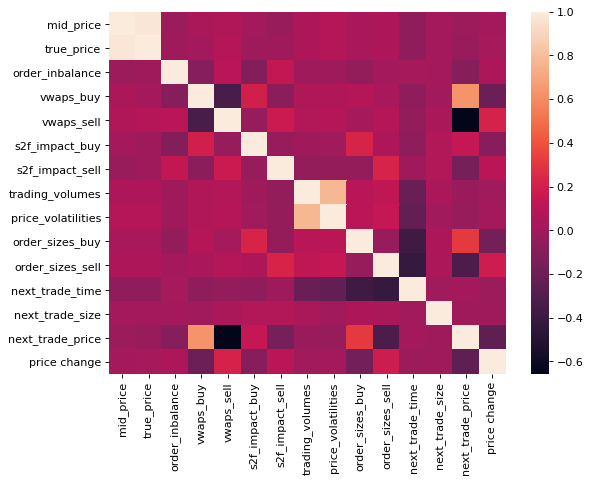

In [34]:
df = pd.DataFrame({
                'mid_price': mid_price.flatten(), 
                'true_price': true_price.flatten(), 
                'order_inbalance': order_inbalance.flatten(), 
                'vwaps_buy': vwaps_buy.flatten(), 
                'vwaps_sell': vwaps_sell.flatten(), 
                's2f_impact_buy': s2f_impact_buy.flatten(), 
                's2f_impact_sell': s2f_impact_sell.flatten(), 
                'trading_volumes': trading_volumes.flatten(), 
                'price_volatilities': price_volatilities.flatten(),
                'order_sizes_buy': order_sizes_buy.flatten(), 
                'order_sizes_sell': order_sizes_sell.flatten(),
                'next_trade_time': next_trade_time.flatten(),
                'next_trade_size': next_trade_size.flatten(),
                'next_trade_price': next_trade_price.flatten(),
                'price change': price_change.flatten()
                })

figure(figsize=(8, 6), dpi=80)
ax = sns.heatmap(df.corr(method='kendall'))
plt.show()

# models

In [35]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix



In [36]:
functions_to_call = {
    'mid_price'                              : get_mid_price_comp,
    'true_price'                             : get_true_price_comp,
    'order_inbalance'                        : get_order_inbalance_comp,
    'vwaps_buy'                              : get_vwap_and_ordersizes_comp,
    'vwaps_sell'                             : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_buy'                  : get_vwap_and_ordersizes_comp,
    'vwaps_order_sizes_sell'                 : get_vwap_and_ordersizes_comp,
    's2f_impact_buy'                         : get_s2f_impact_and_ordersizes_comp,
    's2f_impact_sell'                        : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_buy'                    : get_s2f_impact_and_ordersizes_comp,
    's2f_order_sizes_sell'                   : get_s2f_impact_and_ordersizes_comp,
    'trading_volumes'                        : get_trading_volume_and_price_volatility,
    'price_volatilities'                     : get_trading_volume_and_price_volatility,
    'next_trade_time'                        : get_next_trade_x_comp,
    'next_trade_size'                        : get_next_trade_x_comp,
    'next_trade_price'                       : get_next_trade_x_comp,
    'price_change'                           : get_price_change_given_prices
}

In [37]:
def average_smoothing(records, past):      #records - twodimensional array (days, nr_of_bucket), past - how many buckets we look in the past
  #  rolled_records = np.roll(records, past, axis = 1)
   # rolled_records = rolled_records[:,past:]
    rolled_records=records[:,:-past] # does the same as above 
    result = np.zeros(shape = rolled_records.shape)
    for day in range(rolled_records.shape[0]):
        for buck in range(rolled_records.shape[1]):
            count_elem = 0.0
            sum_elem = 0.0
            # loop for changing nans to zeros, np.sum(arr) returns nan if nan is in the arr
            for elem in records[day][buck:buck+past]:
                if not math.isnan(elem):
                    sum_elem+=elem
                    count_elem+=1
            if count_elem>0:
                result[day][buck] = sum_elem/count_elem
            else:
                result[day][buck] = 0
    return result

In [38]:
def up_still_down(x, epsilon = 10e-7):
    if x>epsilon:
        return 1
    elif x<-epsilon:
        return -1
    else:
        return 0
def test_high(x, epsilon = 0.01):
    if x>epsilon:
        return 1
    else:
        return 0
def test_down(x, epsilon = 0.01):
    if x<epsilon:
        return 1
    else:
        return 0
def up_down_bool(x):
    if x>0:
        return True
    else:
        return False
#np.vectorize(up_still_down)(price_change)

In [39]:
def get_y_to_test_max_bool(true_prices, period_of_getting_max, interval_in_data, threshold=1e-3):
    next_indices = period_of_getting_max//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            max_val=np.max(true_prices[i][j:j+next_indices])
            true_price=true_prices[i,j]
            if true_price==0:
                true_price=prev_true_price
                print("true price at index {},{} was zero!".format(i,j))
            else:
                prev_true_price=true_prices[i,j]
            if (max_val-true_price)/true_price>=threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False
    return res
def get_y_to_test_min_bool(true_prices, period_of_getting_min, interval_in_data, threshold=1e-3):
    next_indices = period_of_getting_min//interval_in_data
    num_of_days = true_prices.shape[0]
    num_of_averaged_minutes = true_prices.shape[1]
    res = np.empty(true_prices.shape)
    for i in range(num_of_days):
        for j in range(num_of_averaged_minutes):
            min_val=np.min(true_prices[i][j:j+next_indices])
            true_price=true_prices[i,j]
            if true_price==0:
                true_price=prev_true_price
                print("true price at index {},{} was zero!".format(i,j))
            else:
                prev_true_price=true_prices[i,j]
            if (min_val-true_price)/true_price<=-threshold: # price swing >= than threshold % of price
                res[i][j] = True
            else:
                res[i,j]=False

    return res

In [40]:
def get_X(comp_id=1, 
                    interval=5, 
                    time_to_skip=0, 
                    time_back=1, 
                    names=[], 
                    flat_out=True,
                   ): # use up_and_down or not 
    ## NEED TO ADD y_name PARAMETER AND USE IT!!!
    if flat_out:
        X = np.empty(shape=(-10*time_back+10*((510-time_to_skip)//interval), len(names)), dtype=np.float32)
    else:
        X = np.empty(shape=(10, len(names), -time_back+((510-time_to_skip)//interval)))

    #average_smoothing reduces shape "time_back" times per day
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]  
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')
        if flat_out:
            X[:,index]=np.asarray(average_smoothing(arr, time_back).flatten(), dtype=np.float32)
        else:
            pass
        index+=1
    return X

def get_y(comp_id=1, 
        interval=5, 
        time_to_skip=0, 
        time_back=1, 
        y_name='true_price', 
        check='change',
        swing_interval=30,
         threshold=1e-2):
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
   #??? y = average_smoothing(functions_to_call[y_name](comp_id, interval, time_to_skip), time_back)???
    if check=='change':
        y=functions_to_call['price_change'](y)    
      #  y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])
    elif check=='swing_max':
        y=get_y_to_test_max_bool(y, swing_interval, interval, threshold)
    elif check=='swing_min':
        y=get_y_to_test_min_bool(y, swing_interval, interval, threshold)
    else:
        raise ValueError('bad check argument')
    y = np.asarray(y[:,time_back:].flatten(), dtype=np.float32)
    return y

In [41]:
type(get_y()[0])

numpy.float32

In [42]:
np.unique(get_y())

array([-30.693243, -24.889122,  -8.999589, ...,  41.6205  ,  47.011253,
        64.156715], dtype=float32)

In [43]:
def get_X_y_raw(comp_id=1, 
                    interval=5, 
                    time_to_skip=30, 
                    names=[], 
                    y_name='true_price',
                   check_change=False): # use up_and_down or not 
    X = np.empty(shape=(len(names), 10, (510-time_to_skip)//interval))  # parameter, days, timestamps
    index=0
    s2f_called=False
    vwap_called=False
    volvol_called=False #volume and price volatility
    s2f_imp=np.empty(shape=(10, (510-time_to_skip)//interval))
    s2f_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap=np.empty(shape=(10, (510-time_to_skip)//interval))
    vwap_ord=np.empty(shape=(10, (510-time_to_skip)//interval))
    volume=np.empty(shape=(10, (510-time_to_skip)//interval))
    volatility=np.empty(shape=(10, (510-time_to_skip)//interval))
    for name in names:
        if name in ['mid_price', 'true_price', 'order_inbalance']:
            arr = functions_to_call[name](comp_id, interval, time_to_skip)
        elif name in ['trading_volumes', 'price_volatilities']:
            if not volvol_called:
                volume, volatility=functions_to_call[name](comp_id, interval, time_to_skip)
                volvol_called=True
            if name == 'trading_volumes':
                arr = volume
            elif name == 'price_volatilities':
                arr = volatility
        elif name == 'next_trade_time':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='time')
        elif name == 'next_trade_size':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='size')
        elif name == 'next_trade_price':
            arr = functions_to_call[name](comp_id, interval, time_to_skip, get_x='price')   
        elif re.search("vwap", name):
            if not vwap_called:
                vwap, vwap_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                vwap_called=True
            if name in ['vwaps_buy']:
                arr = vwap[:,::2]
            elif name in ['vwaps_sell']:
                arr = vwap[:,1::2]
            elif name in ['vwaps_order_sizes_buy']:
                arr = vwap_ord[:,::2]
            elif name in ['vwaps_order_sizes_sell']:
                arr = vwap_ord[:,1::2]
        elif re.search("s2f", name):
            if not s2f_called:
                s2f_imp, s2f_ord=functions_to_call[name](comp_id, interval, time_to_skip)
                s2f_called=True
            if name in ['s2f_impact_buy']:
                arr = s2f_imp[:,::2]
            elif name in ['s2f_impact_sell']:
                arr = s2f_imp[:,1::2]
            elif name in ['s2f_order_sizes_buy']:
                arr = s2f_ord[:,::2]
            elif name in ['s2f_order_sizes_sell']:
                arr = s2f_ord[:,1::2]            
        else:
            raise ValueError('parameter not found')
        X[index]=arr
        index+=1
    y = functions_to_call[y_name](comp_id, interval, time_to_skip)
    if check_change:
        y=functions_to_call['price_change'](y)    
    
    return X, y

In [44]:
def get_X_y_averaged(X_raw, y_raw, time_back):
    X_shape=X_raw.shape # parameters, days, timestamps
    X = np.empty(shape=(-X_shape[1]*time_back+X_shape[1]*X_shape[2], X_shape[0]))## we want features as columns, samples as rows
    y=y_raw[:,time_back:].flatten()
    for i in range(X_shape[0]):
        X[:,i]=average_smoothing(X_raw[i], time_back).flatten()
    return X, y

In [45]:
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
param_dict_logreg={}
for n in names:
    param_dict_logreg[n]=[]

In [46]:
np.exp(1)

2.718281828459045

In [47]:
def check_preds(y_pred, check_percent=0.98): #True if one class presence exceeds 'check_percent' of all predictions
  #  assert(y_true.shape==y_pred.shape)
    amount=y_pred.size
    if np.sum(y_pred)/amount >= check_percent or np.sum(y_pred)/amount <= 1-check_percent: #positive over 98% presence or negative...
        return True
    return False

In [48]:
check_preds(np.append(np.ones(100), np.zeros(1)))

True

In [49]:
def logistic_regr(X, y, split_percent, comp_id, epsilon=2.7e-6, 
                               use_pipe=preprocessing.MaxAbsScaler(), 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False,
                               param_dict_logreg=param_dict_logreg):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_pipe:
        clf=make_pipeline(use_pipe, LogisticRegression(max_iter=20 ,solver='sag', tol=1/np.exp(1))).fit(X[:split], y[:split])
      #  print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['logisticregression'].coef_[0,i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['logisticregression'].coef_[0,i])
    else:
        clf = LogisticRegression(max_iter=20).fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.coef_[0,i])  
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.coef_[0,i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    conf_mat=my_confusion_matrix(y[split:], y_predicted, labels=[1,0])
    print(conf_mat)
    precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
    recall=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0])
    
    return clf.score(X[split:], y[split:]), precision, recall#, check_preds(y_predicted) check the damn recall

In [50]:
def decision_tree(X, y, split_percent, comp_id, epsilon=2.7e-6,
                               use_scaling=False, 
                               check_up_down=True, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), DecisionTreeClassifier()).fit(X[:split], y[:split])
       # print(clf.named_steps)
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
        else:
            print("Coefficient impact:")
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.named_steps['decisiontreeclassifier'].feature_importances_[i])
    else:
        clf = DecisionTreeClassifier().fit(X[:split], y[:split])
        if track_params:
            for i in range(len(local_names)):
                param_dict_logreg[local_names[i]].append( clf.feature_importances_[i])  
        else:
            print("Coefficient impact:")
          #  print(clf.feature_importances_)
            for i in range(len(local_names)):
                print(local_names[i], " ", clf.feature_importances_[i])
    y_predicted=clf.predict(X[split:])
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
    conf_mat=my_confusion_matrix(y[split:], y_predicted, labels=[1,0])
    print(conf_mat)
    precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
    recall=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[1,0])
    
    return clf.score(X[split:], y[split:]), precision, recall#, check_preds(y_predicted) just look at the recall
   # return clf.score(X[split:], y[split:])

In [51]:
def xgb_model(X, y, split_percent, comp_id, epsilon=2.7e-6,
                               use_scaling=False, 
                               check_up_down=False, 
                               local_names=names,
                               track_params=False):
    if check_up_down:
        y=np.vectorize(up_still_down)(y,epsilon*average_comp_price[comp_id])#currently we hold price change in y
    split=int(y.size*split_percent)
    neg_class_count = np.sum(y[:split]==0)
    pos_class_count = np.sum(y[:split]==1)
    if use_scaling:
        clf=make_pipeline(preprocessing.MaxAbsScaler(), 
                          xgb.XGBClassifier(max_depth=5, scale_pos_weight=neg_class_count/pos_class_count)).fit(X[:split], y[:split])
    else:
        clf = xgb.XGBClassifier().fit(X[:split], y[:split])
    y_predicted=clf.predict(X[split:])

    print("Percent of correct classification:")
    print(np.sum(y_predicted ==  y[split:])/len(y_predicted))
    print("Confusion matrix:")
    conf_mat = confusion_matrix( y[split:], y_predicted, labels = [1, 0])
    print(conf_mat)
    if np.unique( y[split:]).size>1:
        print("Precision:")
        precision = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])
        print(precision)
        print("Recall:")
        recall = conf_mat[0][0]/(conf_mat[0][0]+conf_mat[1][0])
        print(recall)
    #print("mse: ", mse(y[split:], y_predicted))
    #print("logistic regr score: ", clf.score(X[split:], y[split:]))
        return clf.score(X[split:], y[split:]), precision, recall
    else:
        return clf.score(X[split:], y[split:]), math.nan, math.nan

In [52]:
def permutate_Xy(X, y):
    assert(len(X.shape)==2)
    s1, s2=X.shape
    assert(y.size==s1)
    Xy=np.empty(shape=(s1,s2+1))
    Xy[:,:s2]=X
    Xy[:,s2]=y
    Xy=np.random.permutation(Xy)
    return Xy[:,:s2], Xy[:,s2]

In [53]:
average_comp_price=np.zeros(len(list_of_companies_number))
for i in range(average_comp_price.size):
    average_comp_price[i]=np.average(get_true_price_comp(comp_id=i, interval=1, time_to_skip=30))

In [54]:
comp_id = 3
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=2.7e-6

In [55]:
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]

In [56]:
print(average_comp_price[comp_id])
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=0.0012)
print("decision_tree")
print("score: ",decision_tree(X, np.copy(y),split_percent, comp_id, epsilon, use_scaling=True, check_up_down=False, track_params=False,local_names=names))
print("log reg")
print("score: ",logistic_regr(X, y,split_percent, comp_id=comp_id, use_pipe=MyNormalizer(norm='l2', axis=0), check_up_down=False, track_params=False, local_names=names))

#print("xgb")
#print("score: ",xgb_model(X, np.copy(y),split_percent, epsilon, comp_id, use_scaling=True, local_names=names))


851.5752484506002
30.520833333333332% of intervals were SELL empty
17.34375% of intervals were BUY empty
1.09375% of intervals were set not filled
decision_tree
Coefficient impact:
true_price   0.177960468132627
order_inbalance   0.1176105817472754
vwaps_buy   0.0357857362502336
vwaps_sell   0.044743821655728516
s2f_impact_buy   0.06071120132164421
s2f_impact_sell   0.022502473884826537
trading_volumes   0.09692096857518634
price_volatilities   0.012893521005694634
vwaps_order_sizes_buy   0.06755444445328064
vwaps_order_sizes_sell   0.01970402264216259
s2f_order_sizes_buy   0.01734916238778048
s2f_order_sizes_sell   0.038319630776851216
next_trade_time   0.1119334482163642
next_trade_size   0.09655373659501082
next_trade_price   0.07945678235533364
[[21 35]
 [41 93]]
score:  (0.6, 0.375, 0.3387096774193548)
log reg
Coefficient impact:
true_price   -0.00053881115
order_inbalance   1.1491594
vwaps_buy   -0.10068717
vwaps_sell   0.44282514
s2f_impact_buy   0.1793229
s2f_impact_sell   0.20

<ipython-input-49-46b62b7d5573>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


In [90]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
threshold=0.0012
names_all=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
#s=get_X(0,interval=interval, time_back=time_back, time_to_skip=time_to_skip, names=names_all).shape
#X_allcomps=np.zeros((len(list_of_companies_number), s[0],s[1]))
#y_allcomps=np.zeros((len(list_of_companies_number), s[0]))

In [60]:
for c in range(len(list_of_companies_number)):
    print(c)
    X_allcomps[c]=get_X(comp_id=c,interval=interval, time_back=time_back, time_to_skip=time_to_skip, names=names_all)
    y_allcomps[c]=get_y(comp_id=c,interval=interval, time_back=time_back, time_to_skip=time_to_skip, y_name='true_price', 
                        check='swing_max', swing_interval=60, threshold=threshold)
clear_output()

In [91]:
X_all_df=pd.DataFrame(X_allcomps.reshape((len(list_of_companies_number)*s[0], s[1])))
y_all_df=pd.DataFrame(y_allcomps.flatten())
X_all_df.to_csv('X_all_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, threshold))
y_all_df.to_csv('y_all_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, threshold))

In [65]:
get_X(0,interval=interval, time_back=time_back, time_to_skip=time_to_skip, names=['price_volatilities'])

array([[-4.0000000e+06],
       [-6.0000000e+06],
       [-5.9999995e+06],
       ...,
       [ 2.9903999e-01],
       [-1.9999998e+06],
       [-1.9999996e+06]], dtype=float32)

In [ ]:
x_df = pd.DataFrame(torch.flatten(X,start_dim=0, end_dim=1).numpy())
x_df.to_csv('X_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, swing_interval))
y_df = pd.DataFrame(torch.flatten(y,start_dim=0, end_dim=1).numpy())
y_df.to_csv('y_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, swing_interval))

In [ ]:
log_scale=[]
log=[]
tree_scale=[]
tree=[]
for i in range(100):
    tree_scale.append(decision_tree(X, np.copy(y),split_percent, comp_id, epsilon, use_scaling=True, local_names=names))
    log_scale.append(logistic_regr(X, np.copy(y),split_percent, comp_id,epsilon, use_scaling=True, local_names=names))
    tree.append(decision_tree(X, np.copy(y),split_percent, comp_id, epsilon, use_scaling=False, local_names=names))
    log.append(logistic_regr(X, np.copy(y),split_percent, comp_id,epsilon, use_scaling=False, local_names=names))

In [ ]:
print("log_scale: ", np.sum(log_scale)/100)
print("log: ", np.sum(log)/100)
print("tree_scale: ", np.sum(tree_scale)/100)
print("tree: ", np.sum(tree)/100)

# try with different features

In [ ]:
interval=5
time_to_skip=30
time_back=1
split_percent = 0.8
epsilon=2.7e-6
names=[         
   # 'mid_price',
    #'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names:
    names_dict[name]=[]

In [ ]:
comps=np.arange(len(list_of_companies_number)//10)
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back , y_name='true_price', check='change')
    scores[c,0]=logistic_regr(X, np.copy(y),split_percent,  comps[c], epsilon, True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=logistic_regr(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               comps[c], epsilon, True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


In [ ]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
#plt.legend(comps)
 ### LOG REg

In [ ]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names
names_len=len(names)
scores=np.zeros(shape=(len(comps), names_len+1))
for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='change')
    scores[c,0]=decision_tree(X, np.copy(y),split_percent, epsilon, comps[c], True, local_names=names)
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names.pop(0)
        scores[c,i]=decision_tree(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               epsilon, comps[c], True, local_names=names)
        names.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING


In [ ]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model score')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['all_comps'])
 ### DRZEWO

# find threshold for price swing

In [56]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=1
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
thresholds=np.logspace(-8, -3, num=6)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds),3))

In [57]:
thresholds

array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03])

In [288]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        X,y=permutate_Xy(X_hold,y)
        print(y.shape)
        comp_ths[comp_id,th,0],comp_ths[comp_id,th,1],comp_ths[comp_id,th,2]=logistic_regr(X, y,split_percent, comp_id=comp_id, check_up_down=False, track_params=False, local_names=names)
clear_output()
print("calculations took: {} seconds".format(  time.time()-time_start))

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
threshold  0.0012
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -0.6593626154666995
order_inbalance   -1.0790266370369868
vwaps_buy   1.9305981124128808
vwaps_sell   0.2502005775090994
s2f_impact_buy   0.533165965518571
s2f_impact_sell   0.7121285495867179
trading_volumes   -0.6424039717327021
price_volatilities   -0.6163947721226696
vwaps_order_sizes_buy   -0.7924520104895671
vwaps_order_sizes_sell   -0.8267522244652908
s2f_order_sizes_buy   -0.7924520104895671
s2f_order_sizes_sell   -0.8267522244652908
next_trade_time   -1.2078878378274065
next_trade_size   1.1051381566527085
next_trade_price   1.8827125793383357
[[551 303]
 [ 38  58]]


NameError: name 'comp_ths' is not defined

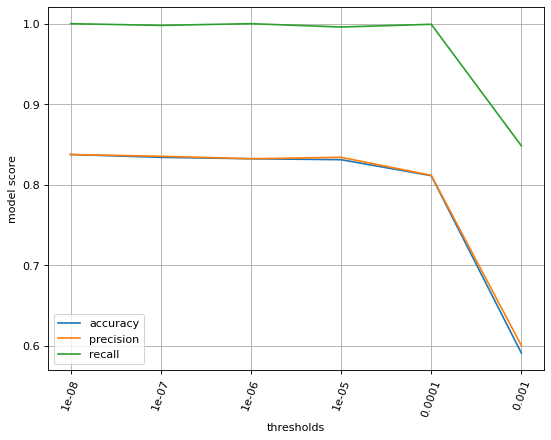

In [112]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
plt.xticks(np.arange(len(thresholds)), thresholds, rotation='70')
plt.grid()
for i in range(3):
    plt.plot(np.sum(comp_ths, axis=0)[:,i]/9)
plt.legend(['accuracy', 'precision', 'recall'])

In [123]:
thresholds=np.arange(8*1e-4, 3*1e-3, step=1e-4)
comp_ths=np.zeros((len(list_of_companies_number), len(thresholds),3))

In [107]:
thresholds

array([0.0008, 0.0009, 0.001 , 0.0011, 0.0012, 0.0013, 0.0014, 0.0015,
       0.0016, 0.0017, 0.0018, 0.0019, 0.002 , 0.0021, 0.0022, 0.0023,
       0.0024, 0.0025, 0.0026, 0.0027, 0.0028, 0.0029])

In [289]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    for th in range(len(thresholds)):
        print('threshold ', thresholds[th])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=thresholds[th])
        X,y=permutate_Xy(X_hold,y)
        print(y.shape)
        comp_ths[comp_id,th,0],comp_ths[comp_id,th,1],comp_ths[comp_id,th,2]=logistic_regr(X, y,split_percent, 
                                                                                           comp_id=comp_id, check_up_down=False, track_params=False, local_names=names)
clear_output()
print("calculations took: {} seconds".format(  time.time()-time_start))

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
threshold  0.0012
(4750, 15)
true price at index 9,479 was zero!
(4750,)
Coefficient impact:
true_price   -1.012797914118934
order_inbalance   -0.3867799585603471
vwaps_buy   1.6186972892453892
vwaps_sell   0.7825431962730162
s2f_impact_buy   0.5884287210985297
s2f_impact_sell   0.6512605903122366
trading_volumes   -0.7399361729972095
price_volatilities   -0.5343634132722088
vwaps_order_sizes_buy   -0.38599109475676413
vwaps_order_sizes_sell   -0.7607003097016776
s2f_order_sizes_buy   -0.38599109475676413
s2f_order_sizes_sell   -0.7607003097016776
next_trade_time   -1.4729804043821124
next_trade_size   1.484668185747839
next_trade_price   1.6744207153347856
[[458 250]
 [105 137]]


NameError: name 'comp_ths' is not defined

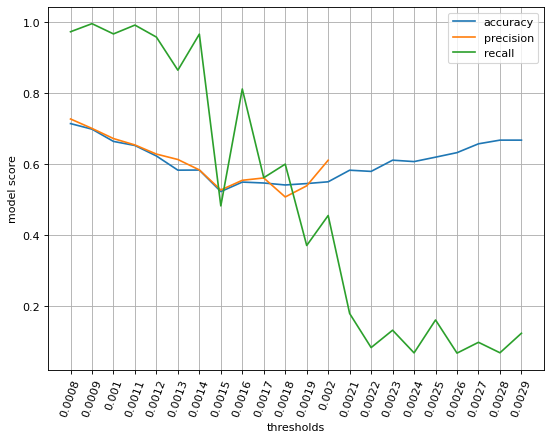

In [125]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='thresholds', ylabel='model score')
plt.xticks(np.arange(len(thresholds)), np.round(thresholds, decimals=4), rotation='70')
plt.grid()
for i in range(3):
    plt.plot(np.sum(comp_ths, axis=0)[:,i]/9)
plt.legend(['accuracy', 'precision', 'recall'])

# check interval

In [129]:
time_back=1
time_to_skip=30
split_percent = 0.8
threshold = 0.0012
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
intervals=[1,3,5,10,15,30]
comp_ints=np.zeros((len(list_of_companies_number), len(intervals),3))

In [290]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    for i in range(len(intervals)):
        X_hold=get_X(comp_id, intervals[i], time_to_skip, time_back, names) 
        print('interval ', intervals[i])
        print(X.shape)
        y=get_y(comp_id, intervals[i], time_to_skip, time_back, y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=threshold)
        print(y.shape)
        X,y=permutate_Xy(X_hold,y)
        comp_ints[comp_id,i,0],comp_ints[comp_id,i,1],comp_ints[comp_id,i,2]=logistic_regr(X, y,split_percent, 
                                                                                           comp_id=comp_id, check_up_down=False, track_params=False, local_names=names)
clear_output()

print("calculations took: {} seconds".format(  time.time()-time_start))

SyntaxError: invalid syntax (<ipython-input-290-e6a0ff42e177>, line 16)

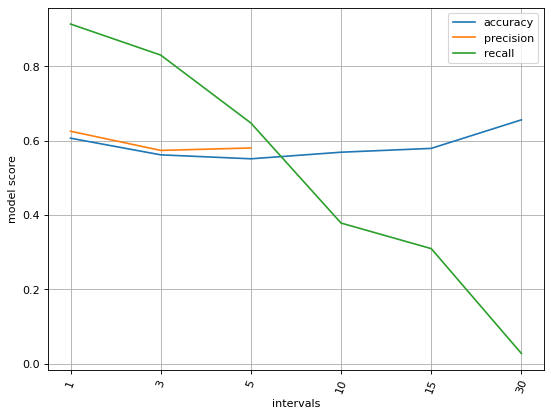

In [135]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='intervals', ylabel='model score')
plt.xticks(np.arange(len(intervals)), intervals, rotation='70')
plt.grid()
for i in range(3):
    plt.plot(np.sum(comp_ints, axis=0)[:,i]/9)
plt.legend(['accuracy', 'precision', 'recall'])

# pick threshold for most balanced dataset


In [131]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
thresholds=np.append(np.array([1.2*1e-3]),np.arange(1.6*1e-3, 1.7*1e-3, step=1e-5))
balance=np.zeros((len(list_of_companies_number), 10, len(thresholds), 2))

In [129]:
np.append(np.array([1.2*1e-3]),np.arange(1.6*1e-3, 1.7*1e-3, step=1e-5))

array([0.0012 , 0.0016 , 0.00161, 0.00162, 0.00163, 0.00164, 0.00165,
       0.00166, 0.00167, 0.00168, 0.00169])

In [132]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    for th in range(len(thresholds)):
        y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=thresholds[th])
        pom=y.size//10
        for day in range(10):
            balance[comp_id,day, th, 0]=np.sum(y[day*pom:(day+1)*pom])
            balance[comp_id,day, th, 1]=pom - np.sum(y[day*pom:(day+1)*pom])
    clear_output(wait=True)

98


In [72]:
balance[0,0,0]

array([338., 137.])

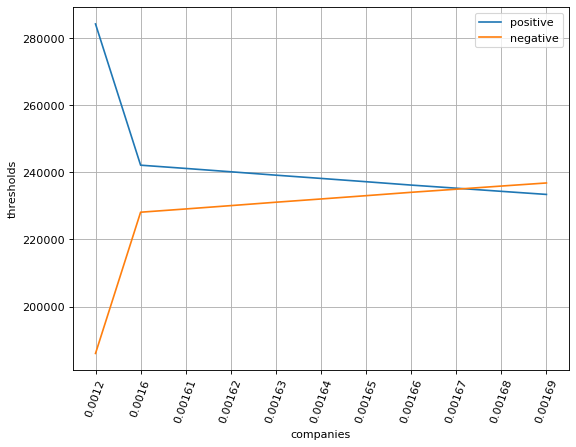

In [134]:
# all companies on all days

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='companies', ylabel='thresholds')
plt.xticks(np.arange(len(thresholds)), np.round(thresholds, decimals=5), rotation='70')
plt.grid()
for i in range(2):
    plt.plot(np.sum(balance, axis=(0,1))[:,i])
plt.legend(['positive', 'negative'])

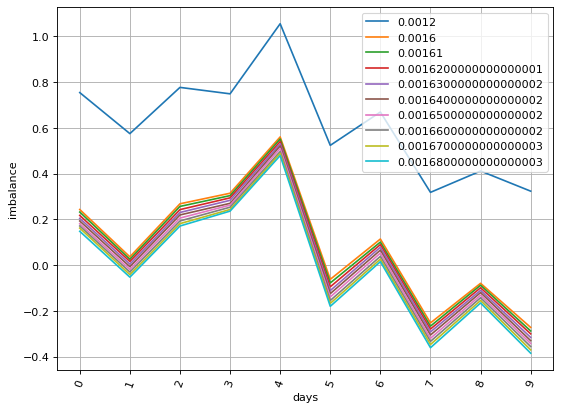

In [135]:
# all companies on all thresholds   ##0.00167 =thresholds[8]
# plot log2(positive/negative)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='days', ylabel='imbalance')
plt.xticks(np.arange(10),  rotation='70')
plt.grid()
for i in range(10):
    plt.plot(np.log2(np.sum(balance, axis=(0))[:,i,0]/np.sum(balance, axis=(0))[:,i,1]))
#plt.legend(['positive', 'negative'])
plt.legend(thresholds)

In [136]:
for i in range(10):
    print("threshold: " ,thresholds[i], "average class imbalance: ")
    print(np.sum(np.log2(np.sum(balance, axis=(0))[:,i,0]/np.sum(balance, axis=(0))[:,i,1])/10))

threshold:  0.0012 average class imbalance: 
0.615342798824659
threshold:  0.0016 average class imbalance: 
0.08684610685264377
threshold:  0.00161 average class imbalance: 
0.07486345368106365
threshold:  0.0016200000000000001 average class imbalance: 
0.06254473076539538
threshold:  0.0016300000000000002 average class imbalance: 
0.050007007146666796
threshold:  0.0016400000000000002 average class imbalance: 
0.03806130609272214
threshold:  0.0016500000000000002 average class imbalance: 
0.02588153784237071
threshold:  0.0016600000000000002 average class imbalance: 
0.013460541888116004
threshold:  0.0016700000000000003 average class imbalance: 
0.0020228091177978136
threshold:  0.0016800000000000003 average class imbalance: 
-0.009594211974930659


In [138]:
thresholds[8]

0.0016700000000000003

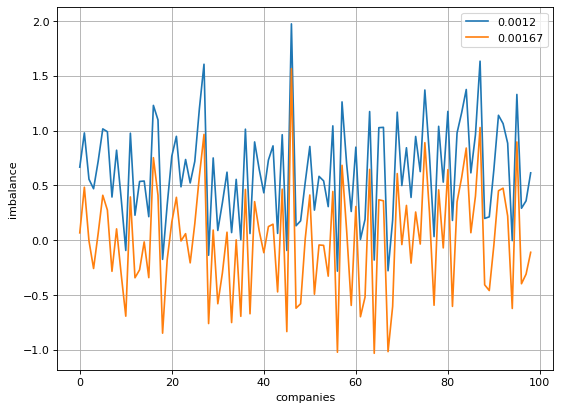

In [139]:
# companies (x) on all days  0.00167 =thresholds[7]
# plot log2(positive/negative)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='companies', ylabel='imbalance')
#plt.xticks(np.arange(10),  rotation='70')
plt.grid()
#for i in range(10):
plt.plot(np.log2(np.sum(balance, axis=(1))[:,0,0]/np.sum(balance, axis=(1))[:,0,1]))

plt.plot(np.log2(np.sum(balance, axis=(1))[:,8,0]/np.sum(balance, axis=(1))[:,8,1]))
#plt.legend(['positive', 'negative'])
plt.legend([0.0012, 0.00167])

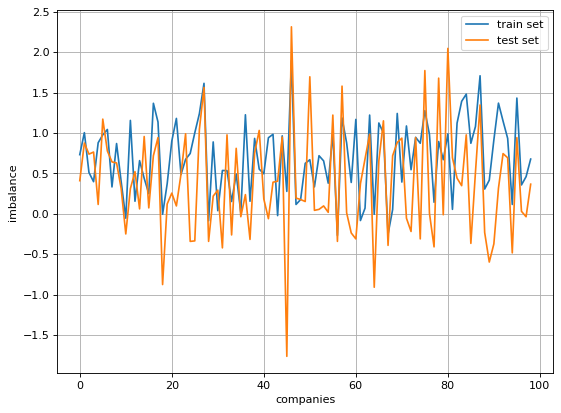

In [141]:
# companies (x) on each day 
# plot log2(positive/negative)

figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='companies', ylabel='imbalance')
#plt.xticks(np.arange(10),  rotation='70')
plt.grid()
#for i in range(10):
plt.plot(np.log2(np.sum(balance[:,0:8], axis=(1))[:,0,0]/np.sum(balance[:,0:8], axis=(1))[:,0,1]))
plt.plot(np.log2(np.sum(balance[:,8:], axis=(1))[:,0,0]/np.sum(balance[:,8:], axis=(1))[:,0,1]))

#plt.plot(np.abs(np.log2(np.sum(balance[:,0:8], axis=(1))[:,0,0]/np.sum(balance[:,0:8], axis=(1))[:,0,1])
 #       -np.log2(np.sum(balance[:,8:], axis=(1))[:,0,0]/np.sum(balance[:,8:], axis=(1))[:,0,1])))
#plt.legend(['positive', 'negative'])
plt.legend(["train set", "test set", "abs(difference)"])

In [127]:
np.sum(balance[:,0:8], axis=(1))[:,7,1].shape

(99,)

## compare times when model is bad, almost always(recall>0.9 or <0.1) predicts either pos or neg class

In [159]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
thresholds_compare = (0.0012, 0.00167)
names_all=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
comps=np.arange(len(list_of_companies_number))
scores_all_compare_th=np.zeros(shape=(len(comps), 10, 2, 4)) #company, i-th try, threshold, (acc,prec,recall,check_preds)

In [174]:
thresholds_compare[0]

0.0012

In [291]:
for c in range(len(comps)):
    print(c)
    X_hold=get_X(comps[c], interval, time_to_skip, time_back, names_all)
    for th in range(2):
        y_hold=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=thresholds_compare[th])
        for i in range(10):
            X,y=permutate_Xy(X_hold,y_hold)
            scores_all_compare_th[c,i,th,0], scores_all_compare_th[c,i,th,1],scores_all_compare_th[c,i,th,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names_all))
            if  scores_all_compare_th[c,i,th,2]>0.9 or  scores_all_compare_th[c,i,th,2]<0.1:
                 scores_all_compare_th[c,i,th,3]=True 
#np will parse above to one, true as if model is super bad, almost always returns either pos or neg class
clear_output(wait)

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,479 was zero!


TypeError: logistic_regr() got an unexpected keyword argument 'use_scaling'

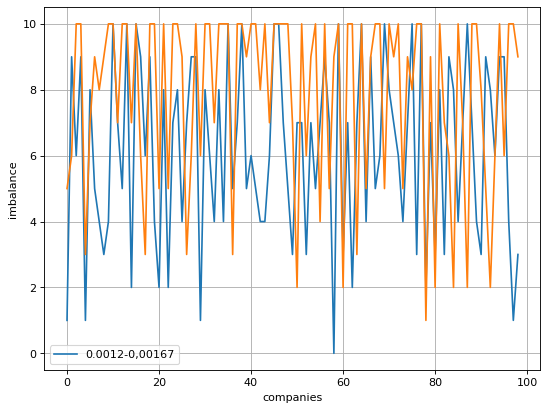

In [183]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='companies', ylabel='imbalance')
#plt.xticks(np.arange(10),  rotation='70')
plt.grid()
#for i in range(10):
plt.plot(np.sum(scores_all_compare_th[:,:,0,3], axis=(1)))#-
plt.plot(np.sum(scores_all_compare_th[:,:,1,3], axis=(1)))


#plt.legend(['positive', 'negative'])
plt.legend(["0.0012","0,00167",])


In [184]:
print("0.0012: ", (np.sum(scores_all_compare_th[:,:,0,3], axis=(0,1))))
print("0.00167: ",(np.sum(scores_all_compare_th[:,:,1,3], axis=(0,1))))


0.0012:  610.0
0.00167:  777.0


In [178]:
scores_all_compare_th_no_perm=np.zeros(shape=(len(comps), 10, 2, 4)) #company, i-th try, threshold, (acc,prec,recall,check_preds)

In [179]:
#same as above, but no permutation

for c in range(len(comps)):
    print(c)
    X=get_X(comps[c], interval, time_to_skip, time_back, names_all)
    for th in range(2):
        y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=thresholds_compare[th])
        for i in range(10):
           # X,y=permutate_Xy(X_hold,y_hold)
          #  X,y=X_hold,y_hold
            scores_all_compare_th_no_perm[c,i,th,0], scores_all_compare_th_no_perm[c,i,th,1],scores_all_compare_th_no_perm[c,i,th,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names_all))
            if  scores_all_compare_th_no_perm[c,i,th,2]>0.9 or  scores_all_compare_th_no_perm[c,i,th,2]<0.1:
                 scores_all_compare_th_no_perm[c,i,th,3]=True 
#np will parse above to one, true as if model is super bad, almost always returns either pos or neg class
clear_output(wait=True)

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.8626047
order_inbalance   -1.0315343
vwaps_buy   1.6480994
vwaps_sell   0.41856942
s2f_impact_buy   -0.2174339
s2f_impact_sell   0.34641722
trading_volumes   -0.7341439
price_volatilities   0.7351986
vwaps_order_sizes_buy   -0.0760045
vwaps_order_sizes_sell   -0.3220271
s2f_order_sizes_buy   -0.0760045
s2f_order_sizes_sell   -0.3220271
next_trade_time   0.3485928
next_trade_size   2.1449323
next_trade_price   1.4911623
[[ 86  97]
 [370 397]]
Coefficient impact:
true_price   -0.65749353
order_inbalance   -1.3097459
vwaps_buy   1.3847609
vwaps_sell   0.3517165
s2f_impact_buy   -0.07353058
s2f_impact_sell   0.43479452
trading_volumes   -0.80422366
price_volatilities   0.76464427
vwaps_order_sizes_buy   -0.14855774
vwaps_order_sizes_sell   -0.5545125
s2f_order_sizes_buy   -0.148557

26.052083333333332% of intervals were SELL empty
27.729166666666668% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
Coefficient impact:
true_price   -1.975829
order_inbalance   0.035244156
vwaps_buy   0.4290497
vwaps_sell   1.067583
s2f_impact_buy   0.71298575
s2f_impact_sell   0.19548863
trading_volumes   -1.0821316
price_volatilities   -0.14274243
vwaps_order_sizes_buy   0.5532004
vwaps_order_sizes_sell   -0.4505134
s2f_order_sizes_buy   0.5532004
s2f_order_sizes_sell   -0.4505134
next_trade_time   0.13134983
next_trade_size   0.8087953
next_trade_price   -0.36299935
[[528 421]
 [  1   0]]
Coefficient impact:
true_price   -2.0912702
order_inbalance   0.018996477
vwaps_buy   0.085124865
vwaps_sell   1.0896504
s2f_impact_buy   0.8135809
s2f_impact_sell   0.27555093
trading_volumes   -1.4412903
price_volatilities   0.046436816
vwaps_order_sizes_buy   0.688367
vwaps_order_sizes_sell   -0.6264596
s2f_order_sizes_buy   0.688367
s2f_order_sizes_sell   -0.6

Coefficient impact:
true_price   -2.4985037
order_inbalance   0.45631957
vwaps_buy   0.51928663
vwaps_sell   1.34371
s2f_impact_buy   0.93216425
s2f_impact_sell   0.5162862
trading_volumes   -1.1331877
price_volatilities   0.10103208
vwaps_order_sizes_buy   0.62753963
vwaps_order_sizes_sell   -0.47489285
s2f_order_sizes_buy   0.62753963
s2f_order_sizes_sell   -0.47489285
next_trade_time   0.6700482
next_trade_size   0.9509264
next_trade_price   -0.14816207
[[114 147]
 [313 376]]
2
30.0% of intervals were SELL empty
27.25% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
Coefficient impact:
true_price   -0.028070882
order_inbalance   -0.21417269
vwaps_buy   -1.6923369
vwaps_sell   0.055664003
s2f_impact_buy   0.91283476
s2f_impact_sell   -0.7331768
trading_volumes   0.5105683
price_volatilities   -0.022116918
vwaps_order_sizes_buy   -0.34039176
vwaps_order_sizes_sell   -0.07649905
s2f_order_sizes_buy   -0.34039176
s2f_order_sizes_sell   -0.07649905
next

[[ 87 122]
 [284 457]]
Coefficient impact:
true_price   -0.33098635
order_inbalance   -0.58651793
vwaps_buy   -1.3165259
vwaps_sell   0.88928676
s2f_impact_buy   0.87222797
s2f_impact_sell   -1.230994
trading_volumes   0.6667732
price_volatilities   -0.13749114
vwaps_order_sizes_buy   -0.056783132
vwaps_order_sizes_sell   0.22401702
s2f_order_sizes_buy   -0.056783132
s2f_order_sizes_sell   0.22401702
next_trade_time   -2.3451505
next_trade_size   -0.071663566
next_trade_price   0.6959915
[[  1  16]
 [370 563]]
Coefficient impact:
true_price   -0.13297589
order_inbalance   -0.68155736
vwaps_buy   -1.704722
vwaps_sell   0.6877346
s2f_impact_buy   0.66274196
s2f_impact_sell   -0.85238266
trading_volumes   0.33559313
price_volatilities   -0.1450423
vwaps_order_sizes_buy   -0.10765856
vwaps_order_sizes_sell   0.06743992
s2f_order_sizes_buy   -0.10765856
s2f_order_sizes_sell   0.06743992
next_trade_time   -2.2255619
next_trade_size   -0.185753
next_trade_price   0.47678128
[[  0   3]
 [371 5

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


  -0.06170881
vwaps_sell   -0.23515607
s2f_impact_buy   -0.10363204
s2f_impact_sell   -0.08718551
trading_volumes   0.85177493
price_volatilities   0.38670462
vwaps_order_sizes_buy   -0.38596636
vwaps_order_sizes_sell   0.4831002
s2f_order_sizes_buy   -0.38596636
s2f_order_sizes_sell   0.4831002
next_trade_time   -0.13830541
next_trade_size   0.5950739
next_trade_price   -0.3603841
[[  0   1]
 [354 595]]
Coefficient impact:
true_price   -0.49682644
order_inbalance   1.0859932
vwaps_buy   -0.3034742
vwaps_sell   -0.12034805
s2f_impact_buy   -0.16694419
s2f_impact_sell   0.10051571
trading_volumes   0.76103455
price_volatilities   0.47898066
vwaps_order_sizes_buy   -0.34103996
vwaps_order_sizes_sell   0.50323695
s2f_order_sizes_buy   -0.34103996
s2f_order_sizes_sell   0.50323695
next_trade_time   -0.029040534
next_trade_size   0.43971232
next_trade_price   -0.32053468
[[  0   1]
 [354 595]]
Coefficient impact:
true_price   -0.4308896
order_inbalance   1.0103813
vwaps_buy   -0.15590155
vw

vwaps_order_sizes_buy   -0.11720558
vwaps_order_sizes_sell   -0.17272726
s2f_order_sizes_buy   -0.11720558
s2f_order_sizes_sell   -0.17272726
next_trade_time   -0.83864045
next_trade_size   -0.25020388
next_trade_price   0.9661828
[[ 15 100]
 [195 640]]
Coefficient impact:
true_price   -1.5733572
order_inbalance   1.0888201
vwaps_buy   -0.7503427
vwaps_sell   -0.2229495
s2f_impact_buy   1.4566545
s2f_impact_sell   0.4262376
trading_volumes   0.5856837
price_volatilities   0.4639887
vwaps_order_sizes_buy   -0.12615894
vwaps_order_sizes_sell   0.10428621
s2f_order_sizes_buy   -0.12615894
s2f_order_sizes_sell   0.10428621
next_trade_time   -0.9304198
next_trade_size   -0.052254777
next_trade_price   1.1063337
[[  4  17]
 [206 723]]
Coefficient impact:
true_price   -1.5941277
order_inbalance   0.97618604
vwaps_buy   -0.6233568
vwaps_sell   -0.14860845
s2f_impact_buy   1.3544923
s2f_impact_sell   0.0738442
trading_volumes   0.65587294
price_volatilities   0.3119706
vwaps_order_sizes_buy   -

[[ 51  79]
 [301 519]]
Coefficient impact:
true_price   -2.4318135
order_inbalance   -0.7862708
vwaps_buy   -0.09012641
vwaps_sell   -1.4467803
s2f_impact_buy   0.4771528
s2f_impact_sell   0.98929995
trading_volumes   0.26680073
price_volatilities   -0.40353295
vwaps_order_sizes_buy   1.0964386
vwaps_order_sizes_sell   0.37142503
s2f_order_sizes_buy   1.0964386
s2f_order_sizes_sell   0.37142503
next_trade_time   -0.40798885
next_trade_size   1.315936
next_trade_price   -0.25361907
[[109 162]
 [243 436]]
Coefficient impact:
true_price   -2.569019
order_inbalance   -0.81500196
vwaps_buy   0.27889925
vwaps_sell   -1.6918039
s2f_impact_buy   0.85217047
s2f_impact_sell   0.50186735
trading_volumes   0.40125328
price_volatilities   -0.05440749
vwaps_order_sizes_buy   1.3081547
vwaps_order_sizes_sell   0.085902005
s2f_order_sizes_buy   1.3081547
s2f_order_sizes_sell   0.085902005
next_trade_time   -0.5038179
next_trade_size   1.3262439
next_trade_price   -0.32159033
[[  0   0]
 [352 598]]
Coe

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  0   0]
 [352 598]]
Coefficient impact:
true_price   -2.0400665
order_inbalance   -0.99660087
vwaps_buy   0.17876564
vwaps_sell   -1.4258633
s2f_impact_buy   0.687539
s2f_impact_sell   0.7400103
trading_volumes   0.2900812
price_volatilities   -0.24120317
vwaps_order_sizes_buy   1.1241064
vwaps_order_sizes_sell   0.10919242
s2f_order_sizes_buy   1.1241064
s2f_order_sizes_sell   0.10919242
next_trade_time   -0.30424654
next_trade_size   1.143144
next_trade_price   0.13174136
[[ 43  57]
 [309 541]]
6
35.71875% of intervals were SELL empty
35.46875% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
Coefficient impact:
true_price   -2.488489
order_inbalance   0.5246048
vwaps_buy   0.15911223
vwaps_sell   0.41972587
s2f_impact_buy   0.1752
s2f_impact_sell   0.011997166
trading_volumes   -1.6976593
price_volatilities   -0.3013223
vwaps_order_sizes_buy   -0.36451128
vwaps_order_sizes_sell   -0.6136165
s2f_order_sizes_buy   -0.36451128
s2f_order_sizes_sell  

 [251 467]]
Coefficient impact:
true_price   -2.4005818
order_inbalance   0.11136441
vwaps_buy   0.60939556
vwaps_sell   1.2744377
s2f_impact_buy   0.7203825
s2f_impact_sell   -0.5721848
trading_volumes   -1.8130786
price_volatilities   0.0292025
vwaps_order_sizes_buy   -0.3560169
vwaps_order_sizes_sell   -0.38180697
s2f_order_sizes_buy   -0.3560169
s2f_order_sizes_sell   -0.38180697
next_trade_time   0.44607005
next_trade_size   -0.7388044
next_trade_price   0.23524782
[[252 447]
 [ 68 183]]
Coefficient impact:
true_price   -2.412464
order_inbalance   0.13147801
vwaps_buy   0.39066964
vwaps_sell   0.88518584
s2f_impact_buy   0.28768286
s2f_impact_sell   -0.2755761
trading_volumes   -1.8543782
price_volatilities   -0.023249147
vwaps_order_sizes_buy   -0.27963412
vwaps_order_sizes_sell   -0.39256918
s2f_order_sizes_buy   -0.27963412
s2f_order_sizes_sell   -0.39256918
next_trade_time   0.3581918
next_trade_size   -0.8745053
next_trade_price   0.38091514
[[ 22  49]
 [298 581]]
Coefficient

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[ 10   8]
 [455 477]]
Coefficient impact:
true_price   -1.7366815
order_inbalance   -0.79682577
vwaps_buy   -0.093446195
vwaps_sell   2.3374207
s2f_impact_buy   1.0135794
s2f_impact_sell   0.9262799
trading_volumes   -1.5228038
price_volatilities   1.1597447
vwaps_order_sizes_buy   -0.7841035
vwaps_order_sizes_sell   0.5272518
s2f_order_sizes_buy   -0.7841035
s2f_order_sizes_sell   0.5272518
next_trade_time   0.92667234
next_trade_size   2.3557947
next_trade_price   1.9004326
[[282 272]
 [183 213]]
Coefficient impact:
true_price   -1.4553531
order_inbalance   -0.84025866
vwaps_buy   -0.123800755
vwaps_sell   2.649426
s2f_impact_buy   0.7891024
s2f_impact_sell   0.75726104
trading_volumes   -1.6984022
price_volatilities   1.175643
vwaps_order_sizes_buy   -0.743651
vwaps_order_sizes_sell   0.74729466
s2f_order_sizes_buy   -0.743651
s2f_order_sizes_sell   0.74729466
next_trade_time   0.90382373
next_trade_size   2.0070028
next_trade_price   1.8341267
[[ 68  80]
 [397 405]]
Coefficient im

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


30.75% of intervals were SELL empty
29.59375% of intervals were BUY empty
0.21875% of intervals were set not filled
Coefficient impact:
true_price   -0.16694391
order_inbalance   0.009328837
vwaps_buy   0.35205406
vwaps_sell   0.89799607
s2f_impact_buy   0.27398762
s2f_impact_sell   -1.0877335
trading_volumes   -0.60458356
price_volatilities   0.07920715
vwaps_order_sizes_buy   -1.0780379
vwaps_order_sizes_sell   1.4781364
s2f_order_sizes_buy   -1.0780379
s2f_order_sizes_sell   1.4781364
next_trade_time   0.63380873
next_trade_size   -1.9398478
next_trade_price   0.2819613
[[447 454]
 [  7  42]]
Coefficient impact:
true_price   -0.2041906
order_inbalance   -0.03636159
vwaps_buy   0.6586968
vwaps_sell   0.64891064
s2f_impact_buy   0.5956183
s2f_impact_sell   -0.8901492
trading_volumes   -0.963412
price_volatilities   0.365858
vwaps_order_sizes_buy   -0.81518924
vwaps_order_sizes_sell   1.4282556
s2f_order_sizes_buy   -0.81518924
s2f_order_sizes_sell   1.4282556
next_trade_time   0.69273

 [312 638]]
Coefficient impact:
true_price   -0.9195216
order_inbalance   -0.36876968
vwaps_buy   -0.27154845
vwaps_sell   1.7728688
s2f_impact_buy   1.0642132
s2f_impact_sell   -0.7809239
trading_volumes   0.053189803
price_volatilities   0.36967215
vwaps_order_sizes_buy   -0.6928403
vwaps_order_sizes_sell   1.5885504
s2f_order_sizes_buy   -0.6928403
s2f_order_sizes_sell   1.5885504
next_trade_time   0.3095236
next_trade_size   -2.0684776
next_trade_price   0.83186084
[[196 428]
 [116 210]]
Coefficient impact:
true_price   -1.0265021
order_inbalance   -0.71565914
vwaps_buy   -0.26679888
vwaps_sell   1.8182473
s2f_impact_buy   0.61237633
s2f_impact_sell   -0.9220014
trading_volumes   -0.41698545
price_volatilities   0.25966215
vwaps_order_sizes_buy   -0.89961094
vwaps_order_sizes_sell   1.337427
s2f_order_sizes_buy   -0.89961094
s2f_order_sizes_sell   1.337427
next_trade_time   0.44790402
next_trade_size   -2.1676204
next_trade_price   0.68448573
[[ 26 114]
 [286 524]]
Coefficient impa

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


25.604166666666668% of intervals were SELL empty
24.010416666666668% of intervals were BUY empty
0.1875% of intervals were set not filled
Coefficient impact:
true_price   -1.0288553
order_inbalance   0.47490358
vwaps_buy   1.0276903
vwaps_sell   -0.24803336
s2f_impact_buy   0.4088701
s2f_impact_sell   0.45528615
trading_volumes   1.313366
price_volatilities   0.5527042
vwaps_order_sizes_buy   0.65550786
vwaps_order_sizes_sell   1.0510242
s2f_order_sizes_buy   0.65550786
s2f_order_sizes_sell   1.0510242
next_trade_time   0.5256683
next_trade_size   -0.5786879
next_trade_price   -0.332899
[[ 56 140]
 [307 447]]
Coefficient impact:
true_price   -0.7350473
order_inbalance   0.3717923
vwaps_buy   0.7991423
vwaps_sell   -0.20475137
s2f_impact_buy   0.35822475
s2f_impact_sell   0.63559484
trading_volumes   1.3821042
price_volatilities   0.41183218
vwaps_order_sizes_buy   0.565701
vwaps_order_sizes_sell   1.1218961
s2f_order_sizes_buy   0.565701
s2f_order_sizes_sell   1.1218961
next_trade_time

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.88995767
order_inbalance   0.7700695
vwaps_buy   -0.18857859
vwaps_sell   -0.021432828
s2f_impact_buy   0.5113209
s2f_impact_sell   0.25186494
trading_volumes   0.78458405
price_volatilities   -0.3842764
vwaps_order_sizes_buy   1.0668622
vwaps_order_sizes_sell   0.7670841
s2f_order_sizes_buy   1.0668622
s2f_order_sizes_sell   0.7670841
next_trade_time   -1.9826711
next_trade_size   -0.8577439
next_trade_price   -0.027118515
[[  3   1]
 [264 682]]
Coefficient impact:
true_price   -0.68984586
order_inbalance   0.73564774
vwaps_buy   -0.24538122
vwaps_sell   0.11649599
s2f_impact_buy   0.6740645
s2f_impact_sell   0.73310655
trading_volumes   1.0934497
price_volatilities   0.059565056
vwaps_order_sizes_buy   0.85275096
vwaps_order_sizes_sell   0.94893956
s2f_order_sizes_buy   0.85275096
s2f_order_sizes_sell   0.94893956
next_trade_time   -1.6978055
next_trade_size   -0.5189922
next_trade_price   -0.19855209
[[  2   1]
 [265 682]]
Coefficient impact:
true

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.0091344
order_inbalance   0.4857662
vwaps_buy   -0.2806433
vwaps_sell   0.24792689
s2f_impact_buy   0.61382633
s2f_impact_sell   0.48784792
trading_volumes   1.2997434
price_volatilities   0.025537971
vwaps_order_sizes_buy   0.6406932
vwaps_order_sizes_sell   0.8915305
s2f_order_sizes_buy   0.6406932
s2f_order_sizes_sell   0.8915305
next_trade_time   -1.7103219
next_trade_size   -0.760619
next_trade_price   0.0876489
[[  3   1]
 [264 682]]
10
30.197916666666668% of intervals were SELL empty
28.90625% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
true_price   -0.7904064
order_inbalance   -0.09535335
vwaps_buy   0.26265228
vwaps_sell   0.8039019
s2f_impact_buy   0.16517289
s2f_impact_sell   0.16928858
trading_volumes   0.25558084
price_volatilities   -0.10009591
vwaps_order_sizes_buy   0.05218554
vwaps_order_sizes_sell   0.99782145
s2f_order_sizes_buy   0.05218554
s2f_order_sizes_sell   0.9978214

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.77281713
order_inbalance   0.6003092
vwaps_buy   0.39300504
vwaps_sell   -0.273072
s2f_impact_buy   0.0074601052
s2f_impact_sell   0.2848612
trading_volumes   0.63048315
price_volatilities   -0.17106399
vwaps_order_sizes_buy   -0.030691624
vwaps_order_sizes_sell   1.0008091
s2f_order_sizes_buy   -0.030691624
s2f_order_sizes_sell   1.0008091
next_trade_time   -0.39926875
next_trade_size   0.42013937
next_trade_price   1.0380785
[[  3   1]
 [247 699]]
Coefficient impact:
true_price   -0.76634705
order_inbalance   0.367884
vwaps_buy   0.49306956
vwaps_sell   -0.2684696
s2f_impact_buy   0.1789306
s2f_impact_sell   0.25430113
trading_volumes   0.6423619
price_volatilities   -0.058636606
vwaps_order_sizes_buy   -0.07131582
vwaps_order_sizes_sell   0.9395415
s2f_order_sizes_buy   -0.07131582
s2f_order_sizes_sell   0.9395415
next_trade_time   -0.2256003
next_trade_size   0.48468837
next_trade_price   1.0954014
[[  0   0]
 [250 700]]
Coefficient impact:
true_

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



vwaps_buy   0.5434051
vwaps_sell   -0.3394479
s2f_impact_buy   -0.0028123567
s2f_impact_sell   0.43191302
trading_volumes   0.5650852
price_volatilities   0.012299419
vwaps_order_sizes_buy   0.10545322
vwaps_order_sizes_sell   1.1431545
s2f_order_sizes_buy   0.10545322
s2f_order_sizes_sell   1.1431545
next_trade_time   -0.32957882
next_trade_size   0.30838788
next_trade_price   0.7935569
[[  8   3]
 [242 697]]
Coefficient impact:
true_price   -0.7390896
order_inbalance   0.414759
vwaps_buy   0.49794078
vwaps_sell   -0.23008995
s2f_impact_buy   0.057486497
s2f_impact_sell   0.28674304
trading_volumes   0.5614342
price_volatilities   -0.15832585
vwaps_order_sizes_buy   -0.008029385
vwaps_order_sizes_sell   0.9298927
s2f_order_sizes_buy   -0.008029385
s2f_order_sizes_sell   0.9298927
next_trade_time   -0.469996
next_trade_size   0.22748688
next_trade_price   0.9694584
[[  2   0]
 [248 700]]
11
26.5625% of intervals were SELL empty
26.260416666666668% of intervals were BUY empty
0.0729166

[[  2   0]
 [233 715]]
Coefficient impact:
true_price   -1.5267367
order_inbalance   0.8801869
vwaps_buy   0.20434797
vwaps_sell   0.17923696
s2f_impact_buy   -0.1235503
s2f_impact_sell   0.08047026
trading_volumes   0.6807381
price_volatilities   -0.81989586
vwaps_order_sizes_buy   1.0192482
vwaps_order_sizes_sell   -0.33481503
s2f_order_sizes_buy   1.0192482
s2f_order_sizes_sell   -0.33481503
next_trade_time   -1.5482706
next_trade_size   -0.91438866
next_trade_price   0.4316367
[[155 509]
 [ 80 206]]
12
25.177083333333332% of intervals were SELL empty
26.302083333333332% of intervals were BUY empty
0.4895833333333333% of intervals were set not filled
Coefficient impact:
true_price   -2.2957826
order_inbalance   -0.20977244
vwaps_buy   0.06463904
vwaps_sell   0.6587782
s2f_impact_buy   1.2520696
s2f_impact_sell   1.4782002
trading_volumes   -1.3024777
price_volatilities   -0.116278484
vwaps_order_sizes_buy   0.0793476
vwaps_order_sizes_sell   -0.3426785
s2f_order_sizes_buy   0.079347

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.0660632
order_inbalance   -0.5500318
vwaps_buy   0.3528865
vwaps_sell   0.28979325
s2f_impact_buy   1.3330532
s2f_impact_sell   1.5150212
trading_volumes   -0.55996424
price_volatilities   -0.19608454
vwaps_order_sizes_buy   -1.0586501
vwaps_order_sizes_sell   -0.3816143
s2f_order_sizes_buy   -1.0586501
s2f_order_sizes_sell   -0.3816143
next_trade_time   -1.7632871
next_trade_size   0.9539
next_trade_price   0.5133181
[[ 17  10]
 [368 555]]
Coefficient impact:
true_price   -2.4562545
order_inbalance   -0.30615678
vwaps_buy   -0.08082507
vwaps_sell   0.24056186
s2f_impact_buy   1.1652635
s2f_impact_sell   1.5254424
trading_volumes   -0.63579214
price_volatilities   -0.18047094
vwaps_order_sizes_buy   -0.88483065
vwaps_order_sizes_sell   -0.35978806
s2f_order_sizes_buy   -0.88483065
s2f_order_sizes_sell   -0.35978806
next_trade_time   -1.3105385
next_trade_size   0.89305836
next_trade_price   0.32282186
[[  2   0]
 [383 565]]
Coefficient impact:
true_p

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


33.6875% of intervals were SELL empty
31.802083333333332% of intervals were BUY empty
0.020833333333333332% of intervals were set not filled
Coefficient impact:
true_price   -1.1854705
order_inbalance   -0.24440734
vwaps_buy   0.1324202
vwaps_sell   0.47261658
s2f_impact_buy   0.84366965
s2f_impact_sell   0.15157932
trading_volumes   0.3501521
price_volatilities   0.16215977
vwaps_order_sizes_buy   -0.70053774
vwaps_order_sizes_sell   0.865391
s2f_order_sizes_buy   -0.70053774
s2f_order_sizes_sell   0.865391
next_trade_time   -0.32065967
next_trade_size   0.8460105
next_trade_price   -0.32812592
[[  9  38]
 [321 582]]
Coefficient impact:
true_price   -1.1025225
order_inbalance   -0.20748635
vwaps_buy   0.18820684
vwaps_sell   0.18159519
s2f_impact_buy   1.0858135
s2f_impact_sell   0.022779776
trading_volumes   0.3386448
price_volatilities   0.4355459
vwaps_order_sizes_buy   -0.7317536
vwaps_order_sizes_sell   0.7858098
s2f_order_sizes_buy   -0.7317536
s2f_order_sizes_sell   0.7858098
n

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.2775421
order_inbalance   -0.2558202
vwaps_buy   0.49579474
vwaps_sell   0.8951275
s2f_impact_buy   1.0057123
s2f_impact_sell   0.14357686
trading_volumes   -1.245887
price_volatilities   0.27177116
vwaps_order_sizes_buy   -0.217575
vwaps_order_sizes_sell   0.59389174
s2f_order_sizes_buy   -0.217575
s2f_order_sizes_sell   0.59389174
next_trade_time   -1.9429255
next_trade_size   0.1882907
next_trade_price   -0.4445399
[[  0   0]
 [218 732]]
Coefficient impact:
true_price   -1.0915533
order_inbalance   -0.8111131
vwaps_buy   0.6421695
vwaps_sell   0.64035356
s2f_impact_buy   0.9203082
s2f_impact_sell   -0.3083113
trading_volumes   -1.3143262
price_volatilities   0.013299128
vwaps_order_sizes_buy   -0.43359986
vwaps_order_sizes_sell   0.52226335
s2f_order_sizes_buy   -0.43359986
s2f_order_sizes_sell   0.52226335
next_trade_time   -1.6008108
next_trade_size   0.47779077
next_trade_price   -0.23758775
[[ 23  42]
 [195 690]]
14
31.5625% of intervals were 

Coefficient impact:
true_price   -0.1381113
order_inbalance   1.4287492
vwaps_buy   1.2622831
vwaps_sell   -0.19878452
s2f_impact_buy   1.550941
s2f_impact_sell   -0.46192133
trading_volumes   -0.21907477
price_volatilities   -0.7941937
vwaps_order_sizes_buy   1.0247747
vwaps_order_sizes_sell   -0.47645596
s2f_order_sizes_buy   1.0247747
s2f_order_sizes_sell   -0.47645596
next_trade_time   0.099264115
next_trade_size   -1.9559557
next_trade_price   0.78228366
[[  8  24]
 [375 543]]
Coefficient impact:
true_price   0.062176984
order_inbalance   1.2195512
vwaps_buy   0.8407928
vwaps_sell   -0.20162444
s2f_impact_buy   1.5138663
s2f_impact_sell   -0.6010356
trading_volumes   0.24883406
price_volatilities   -0.01347478
vwaps_order_sizes_buy   0.58274126
vwaps_order_sizes_sell   -0.44650704
s2f_order_sizes_buy   0.58274126
s2f_order_sizes_sell   -0.44650704
next_trade_time   0.13620923
next_trade_size   -1.0608088
next_trade_price   0.7399465
[[  0   8]
 [383 559]]
Coefficient impact:
true_

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   0.025890172
order_inbalance   0.51481724
vwaps_buy   0.83440995
vwaps_sell   1.1676793
s2f_impact_buy   -1.4848576
s2f_impact_sell   -0.29472017
trading_volumes   0.2038238
price_volatilities   -0.42489567
vwaps_order_sizes_buy   0.032937743
vwaps_order_sizes_sell   0.032614224
s2f_order_sizes_buy   0.032937743
s2f_order_sizes_sell   0.032614224
next_trade_time   -0.51130867
next_trade_size   -0.15684171
next_trade_price   0.23387346
[[  0   6]
 [383 561]]
Coefficient impact:
true_price   -0.028823525
order_inbalance   0.26417753
vwaps_buy   0.5010846
vwaps_sell   0.8661803
s2f_impact_buy   -1.4346749
s2f_impact_sell   -0.45235133
trading_volumes   -0.021575809
price_volatilities   -0.7237971
vwaps_order_sizes_buy   -0.05141341
vwaps_order_sizes_sell   0.26763228
s2f_order_sizes_buy   -0.05141341
s2f_order_sizes_sell   0.26763228
next_trade_time   -0.46219602
next_trade_size   0.36538154
next_trade_price   0.21382716
[[  0   1]
 [383 566]]
Coefficient 

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


30.416666666666668% of intervals were SELL empty
30.333333333333332% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
Coefficient impact:
true_price   -2.8945434
order_inbalance   0.15089126
vwaps_buy   0.07950746
vwaps_sell   1.7660719
s2f_impact_buy   -0.46291965
s2f_impact_sell   -0.77011
trading_volumes   0.20049779
price_volatilities   0.7642892
vwaps_order_sizes_buy   -0.083895914
vwaps_order_sizes_sell   0.95291317
s2f_order_sizes_buy   -0.083895914
s2f_order_sizes_sell   0.95291317
next_trade_time   0.6770477
next_trade_size   1.2976731
next_trade_price   1.2787862
[[460 483]
 [  6   1]]
Coefficient impact:
true_price   -3.3663852
order_inbalance   0.20232353
vwaps_buy   0.2615983
vwaps_sell   1.8658509
s2f_impact_buy   -0.5181605
s2f_impact_sell   -0.20290549
trading_volumes   0.2076206
price_volatilities   0.60403216
vwaps_order_sizes_buy   -0.41141433
vwaps_order_sizes_sell   1.1782043
s2f_order_sizes_buy   -0.41141433
s2f_order_sizes_sell   

Coefficient impact:
true_price   -3.167577
order_inbalance   -0.28019497
vwaps_buy   0.04593242
vwaps_sell   0.38219538
s2f_impact_buy   -0.34270158
s2f_impact_sell   -0.23200102
trading_volumes   0.19815415
price_volatilities   0.63157874
vwaps_order_sizes_buy   -0.16466178
vwaps_order_sizes_sell   1.4494084
s2f_order_sizes_buy   -0.16466178
s2f_order_sizes_sell   1.4494084
next_trade_time   0.3495879
next_trade_size   1.5430193
next_trade_price   1.8987823
[[345 567]
 [ 17  21]]
17
25.5% of intervals were SELL empty
25.5625% of intervals were BUY empty
0.125% of intervals were set not filled
Coefficient impact:
true_price   -2.8486562
order_inbalance   -0.5576499
vwaps_buy   1.3715146
vwaps_sell   -0.013392751
s2f_impact_buy   0.2577807
s2f_impact_sell   0.7804752
trading_volumes   -0.91783047
price_volatilities   -0.1679755
vwaps_order_sizes_buy   0.32208154
vwaps_order_sizes_sell   -0.13901187
s2f_order_sizes_buy   0.32208154
s2f_order_sizes_sell   -0.13901187
next_trade_time   0.1

Coefficient impact:
true_price   -2.3008301
order_inbalance   -0.4520577
vwaps_buy   1.6087409
vwaps_sell   -0.11858047
s2f_impact_buy   -0.12145009
s2f_impact_sell   0.6840661
trading_volumes   -0.518827
price_volatilities   -0.0066665895
vwaps_order_sizes_buy   0.32003453
vwaps_order_sizes_sell   0.3610971
s2f_order_sizes_buy   0.32003453
s2f_order_sizes_sell   0.3610971
next_trade_time   -1.4120072
next_trade_size   -1.3992851
next_trade_price   1.0492342
[[130 100]
 [264 456]]
Coefficient impact:
true_price   -2.178697
order_inbalance   -0.31199193
vwaps_buy   1.4824991
vwaps_sell   0.28685355
s2f_impact_buy   -0.20502949
s2f_impact_sell   0.5958199
trading_volumes   -0.9522289
price_volatilities   -0.15596265
vwaps_order_sizes_buy   0.7335234
vwaps_order_sizes_sell   -0.2453517
s2f_order_sizes_buy   0.7335234
s2f_order_sizes_sell   -0.2453517
next_trade_time   -0.61208695
next_trade_size   -1.7577363
next_trade_price   1.0033675
[[  0   1]
 [394 555]]
Coefficient impact:
true_pric

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -2.3416874
order_inbalance   0.8547108
vwaps_buy   -0.12617853
vwaps_sell   -0.6119322
s2f_impact_buy   0.46027803
s2f_impact_sell   0.6869326
trading_volumes   -1.368587
price_volatilities   0.10507438
vwaps_order_sizes_buy   0.10780237
vwaps_order_sizes_sell   -0.4819578
s2f_order_sizes_buy   0.10780237
s2f_order_sizes_sell   -0.4819578
next_trade_time   -0.015784161
next_trade_size   1.7979153
next_trade_price   0.039727002
[[  0   9]
 [226 715]]
Coefficient impact:
true_price   -2.2511995
order_inbalance   0.87279433
vwaps_buy   -0.36810333
vwaps_sell   -0.76782364
s2f_impact_buy   0.5788155
s2f_impact_sell   0.69963914
trading_volumes   -1.7048396
price_volatilities   0.07629819
vwaps_order_sizes_buy   -0.06004062
vwaps_order_sizes_sell   -0.5623445
s2f_order_sizes_buy   -0.06004062
s2f_order_sizes_sell   -0.5623445
next_trade_time   -0.21368437
next_trade_size   1.724581
next_trade_price   -0.040769048
[[  0   7]
 [226 717]]
Coefficient impact:
t

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.8169832
order_inbalance   0.99615276
vwaps_buy   -2.1219816
vwaps_sell   0.39627036
s2f_impact_buy   0.5109922
s2f_impact_sell   -0.07327426
trading_volumes   -1.7763901
price_volatilities   -0.27901912
vwaps_order_sizes_buy   0.023034375
vwaps_order_sizes_sell   -0.19715665
s2f_order_sizes_buy   0.023034375
s2f_order_sizes_sell   -0.19715665
next_trade_time   -0.08900114
next_trade_size   1.5121849
next_trade_price   0.5783296
[[  0   0]
 [134 816]]
Coefficient impact:
true_price   -2.0963724
order_inbalance   0.9045772
vwaps_buy   -1.9183292
vwaps_sell   0.45409492
s2f_impact_buy   0.6591179
s2f_impact_sell   0.004455746
trading_volumes   -1.2767622
price_volatilities   0.013727035
vwaps_order_sizes_buy   -0.06909637
vwaps_order_sizes_sell   0.06680275
s2f_order_sizes_buy   -0.06909637
s2f_order_sizes_sell   0.06680275
next_trade_time   0.19072782
next_trade_size   1.6763047
next_trade_price   0.5315629
[[  0   0]
 [134 816]]
Coefficient impact:
tr

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  0   0]
 [134 816]]
Coefficient impact:
true_price   -2.0372741
order_inbalance   0.7646572
vwaps_buy   -1.9787242
vwaps_sell   0.33390886
s2f_impact_buy   0.353021
s2f_impact_sell   -0.17569262
trading_volumes   -1.5963627
price_volatilities   -0.08275381
vwaps_order_sizes_buy   0.11029953
vwaps_order_sizes_sell   -0.16925307
s2f_order_sizes_buy   0.11029953
s2f_order_sizes_sell   -0.16925307
next_trade_time   0.07001792
next_trade_size   1.6010275
next_trade_price   0.55542237
[[  0   0]
 [134 816]]
Coefficient impact:
true_price   -1.6577463
order_inbalance   0.940178
vwaps_buy   -1.8908097
vwaps_sell   0.50453126
s2f_impact_buy   0.38904268
s2f_impact_sell   -0.22938356
trading_volumes   -1.64122
price_volatilities   0.13780098
vwaps_order_sizes_buy   -0.081575826
vwaps_order_sizes_sell   -0.076376446
s2f_order_sizes_buy   -0.081575826
s2f_order_sizes_sell   -0.076376446
next_trade_time   0.78187144
next_trade_size   1.5777899
next_trade_price   0.63738114
[[  0   0]
 [134 816]]

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


30.458333333333332% of intervals were SELL empty
31.770833333333332% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
Coefficient impact:
true_price   -1.5233061
order_inbalance   0.75773615
vwaps_buy   0.64081234
vwaps_sell   1.5264313
s2f_impact_buy   -0.41761127
s2f_impact_sell   0.13176283
trading_volumes   -0.020125253
price_volatilities   -0.43737495
vwaps_order_sizes_buy   -0.07497458
vwaps_order_sizes_sell   0.06438085
s2f_order_sizes_buy   -0.07497458
s2f_order_sizes_sell   0.06438085
next_trade_time   0.3045352
next_trade_size   0.89757377
next_trade_price   0.33519092
[[ 44  54]
 [363 489]]
Coefficient impact:
true_price   -1.6586435
order_inbalance   0.4706113
vwaps_buy   0.5399261
vwaps_sell   1.8766708
s2f_impact_buy   -0.30346534
s2f_impact_sell   0.046762183
trading_volumes   0.32298234
price_volatilities   -0.34711933
vwaps_order_sizes_buy   -0.06653511
vwaps_order_sizes_sell   0.030952897
s2f_order_sizes_buy   -0.06653511
s2f_order_si

32.270833333333336% of intervals were SELL empty
35.125% of intervals were BUY empty
0.03125% of intervals were set not filled
Coefficient impact:
true_price   -1.068735
order_inbalance   0.8624355
vwaps_buy   0.19995813
vwaps_sell   1.4668859
s2f_impact_buy   -0.2707157
s2f_impact_sell   -0.19350038
trading_volumes   -0.09296779
price_volatilities   -0.6077721
vwaps_order_sizes_buy   -0.41681445
vwaps_order_sizes_sell   0.13585171
s2f_order_sizes_buy   -0.41681445
s2f_order_sizes_sell   0.13585171
next_trade_time   -1.2485833
next_trade_size   1.14235
next_trade_price   1.392592
[[ 21  17]
 [371 541]]
Coefficient impact:
true_price   -1.1067086
order_inbalance   0.8067183
vwaps_buy   -0.08934844
vwaps_sell   1.5065775
s2f_impact_buy   -0.16894677
s2f_impact_sell   -0.24145043
trading_volumes   -0.049822636
price_volatilities   -0.7788535
vwaps_order_sizes_buy   -0.4272016
vwaps_order_sizes_sell   0.1462102
s2f_order_sizes_buy   -0.4272016
s2f_order_sizes_sell   0.1462102
next_trade_ti

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.4227474
order_inbalance   0.33471572
vwaps_buy   0.18269229
vwaps_sell   1.3456879
s2f_impact_buy   0.19421187
s2f_impact_sell   -0.22340001
trading_volumes   0.5494685
price_volatilities   -0.39944386
vwaps_order_sizes_buy   -0.46972156
vwaps_order_sizes_sell   0.32499298
s2f_order_sizes_buy   -0.46972156
s2f_order_sizes_sell   0.32499298
next_trade_time   -0.35145867
next_trade_size   1.1521895
next_trade_price   1.9083844
[[  7   0]
 [238 705]]
Coefficient impact:
true_price   -1.176077
order_inbalance   0.86328155
vwaps_buy   0.17225555
vwaps_sell   1.4429067
s2f_impact_buy   -0.32310468
s2f_impact_sell   -0.46948272
trading_volumes   0.5550121
price_volatilities   -0.3636944
vwaps_order_sizes_buy   -0.15648705
vwaps_order_sizes_sell   0.26069242
s2f_order_sizes_buy   -0.15648705
s2f_order_sizes_sell   0.26069242
next_trade_time   -0.041974116
next_trade_size   1.3255928
next_trade_price   1.3780029
[[ 56 114]
 [189 591]]
Coefficient impact:
true

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.4002426
order_inbalance   -0.002479947
vwaps_buy   -0.96745235
vwaps_sell   0.05195708
s2f_impact_buy   0.35427126
s2f_impact_sell   1.3364785
trading_volumes   -0.18295716
price_volatilities   0.14529549
vwaps_order_sizes_buy   -0.8025341
vwaps_order_sizes_sell   1.1988533
s2f_order_sizes_buy   -0.8025341
s2f_order_sizes_sell   1.1988533
next_trade_time   0.8925799
next_trade_size   0.008877428
next_trade_price   1.2506373
[[  7  21]
 [302 620]]
Coefficient impact:
true_price   -2.39892
order_inbalance   0.27244523
vwaps_buy   -1.1455274
vwaps_sell   -0.10755604
s2f_impact_buy   0.19743048
s2f_impact_sell   1.2725474
trading_volumes   -0.26852447
price_volatilities   -0.026642377
vwaps_order_sizes_buy   -0.9859774
vwaps_order_sizes_sell   1.021086
s2f_order_sizes_buy   -0.9859774
s2f_order_sizes_sell   1.021086
next_trade_time   0.9834261
next_trade_size   -0.2517824
next_trade_price   0.9873637
[[ 19  56]
 [290 585]]
Coefficient impact:
true_price 

Coefficient impact:
true_price   1.8955814
order_inbalance   0.61676234
vwaps_buy   1.5867336
vwaps_sell   1.4320755
s2f_impact_buy   0.17248638
s2f_impact_sell   -0.013320538
trading_volumes   -0.8108227
price_volatilities   0.83171237
vwaps_order_sizes_buy   -0.08885613
vwaps_order_sizes_sell   1.6457009
s2f_order_sizes_buy   -0.08885613
s2f_order_sizes_sell   1.6457009
next_trade_time   -1.2656329
next_trade_size   1.4681804
next_trade_price   0.22298498
[[ 34  39]
 [374 503]]
Coefficient impact:
true_price   1.8540573
order_inbalance   0.93773204
vwaps_buy   1.2368906
vwaps_sell   1.5565888
s2f_impact_buy   -0.16657658
s2f_impact_sell   0.11459807
trading_volumes   -0.48913094
price_volatilities   0.72128356
vwaps_order_sizes_buy   0.23520641
vwaps_order_sizes_sell   1.6803348
s2f_order_sizes_buy   0.23520641
s2f_order_sizes_sell   1.6803348
next_trade_time   -1.892339
next_trade_size   1.1785983
next_trade_price   0.410114
[[179 156]
 [229 386]]
Coefficient impact:
true_price   1.

s2f_order_sizes_buy   0.2587926
s2f_order_sizes_sell   -0.34269637
next_trade_time   -0.8062704
next_trade_size   0.65839344
next_trade_price   0.11124122
[[ 15  60]
 [244 631]]
Coefficient impact:
true_price   -1.6067722
order_inbalance   -0.4346723
vwaps_buy   0.63795096
vwaps_sell   0.7812202
s2f_impact_buy   0.26563552
s2f_impact_sell   -0.106193446
trading_volumes   -0.08264178
price_volatilities   -0.7032555
vwaps_order_sizes_buy   0.20254888
vwaps_order_sizes_sell   -0.28304353
s2f_order_sizes_buy   0.20254888
s2f_order_sizes_sell   -0.28304353
next_trade_time   -0.700958
next_trade_size   0.75172067
next_trade_price   -0.036019374
[[ 14  55]
 [245 636]]
Coefficient impact:
true_price   -1.413495
order_inbalance   -0.13790451
vwaps_buy   0.80380183
vwaps_sell   0.7064877
s2f_impact_buy   0.15171565
s2f_impact_sell   -0.10487899
trading_volumes   -0.05482877
price_volatilities   -0.9689067
vwaps_order_sizes_buy   0.28812063
vwaps_order_sizes_sell   -0.29782128
s2f_order_sizes_buy

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.4833028
order_inbalance   -0.44681033
vwaps_buy   -0.6324493
vwaps_sell   0.7586373
s2f_impact_buy   0.41780892
s2f_impact_sell   0.6708342
trading_volumes   -0.72563565
price_volatilities   -0.25065583
vwaps_order_sizes_buy   0.70894843
vwaps_order_sizes_sell   -1.6547433
s2f_order_sizes_buy   0.70894843
s2f_order_sizes_sell   -1.6547433
next_trade_time   -0.8945813
next_trade_size   -0.1025674
next_trade_price   0.35146478
[[  4   5]
 [213 728]]
Coefficient impact:
true_price   -1.5239906
order_inbalance   -0.5682169
vwaps_buy   -0.49913737
vwaps_sell   0.84257907
s2f_impact_buy   0.37979147
s2f_impact_sell   0.6579296
trading_volumes   -0.5398576
price_volatilities   -0.26752794
vwaps_order_sizes_buy   0.65335083
vwaps_order_sizes_sell   -1.2372938
s2f_order_sizes_buy   0.65335083
s2f_order_sizes_sell   -1.2372938
next_trade_time   -1.0488107
next_trade_size   -0.31406802
next_trade_price   -0.23300485
[[  9  17]
 [208 716]]
Coefficient impact:
tr

Coefficient impact:
true_price   0.16642536
order_inbalance   0.4202872
vwaps_buy   1.2663162
vwaps_sell   1.7381744
s2f_impact_buy   0.9242821
s2f_impact_sell   -0.43317884
trading_volumes   0.0639685
price_volatilities   0.629122
vwaps_order_sizes_buy   0.40426207
vwaps_order_sizes_sell   -0.42097494
s2f_order_sizes_buy   0.40426207
s2f_order_sizes_sell   -0.42097494
next_trade_time   0.6686432
next_trade_size   0.63180196
next_trade_price   0.36936927
[[ 10  20]
 [229 691]]
Coefficient impact:
true_price   0.36118942
order_inbalance   0.40947485
vwaps_buy   1.4083056
vwaps_sell   1.562775
s2f_impact_buy   0.6411199
s2f_impact_sell   -0.27679706
trading_volumes   0.12169132
price_volatilities   0.30162346
vwaps_order_sizes_buy   0.20279264
vwaps_order_sizes_sell   -0.5294129
s2f_order_sizes_buy   0.20279264
s2f_order_sizes_sell   -0.5294129
next_trade_time   0.38296723
next_trade_size   0.15340438
next_trade_price   0.23087837
[[  8  12]
 [231 699]]
Coefficient impact:
true_price   0

Coefficient impact:
true_price   -1.8413025
order_inbalance   0.23093604
vwaps_buy   1.2573185
vwaps_sell   1.7241209
s2f_impact_buy   -1.1114103
s2f_impact_sell   -1.251358
trading_volumes   -0.09142765
price_volatilities   0.00773707
vwaps_order_sizes_buy   0.87367755
vwaps_order_sizes_sell   -0.45227292
s2f_order_sizes_buy   0.87367755
s2f_order_sizes_sell   -0.45227292
next_trade_time   -1.467748
next_trade_size   0.9329495
next_trade_price   0.9568836
[[457 485]
 [  1   7]]
Coefficient impact:
true_price   -1.8917586
order_inbalance   0.38426262
vwaps_buy   1.3259416
vwaps_sell   1.7746478
s2f_impact_buy   -1.0561266
s2f_impact_sell   -1.1132905
trading_volumes   -0.10313764
price_volatilities   0.15799497
vwaps_order_sizes_buy   0.77078336
vwaps_order_sizes_sell   -0.5810091
s2f_order_sizes_buy   0.77078336
s2f_order_sizes_sell   -0.5810091
next_trade_time   -1.2649348
next_trade_size   1.0396868
next_trade_price   0.9999505
[[350 364]
 [108 128]]
Coefficient impact:
true_price  

 [ 53 108]]
Coefficient impact:
true_price   -3.2113643
order_inbalance   -0.08225325
vwaps_buy   1.4603113
vwaps_sell   -0.8110652
s2f_impact_buy   -0.2500327
s2f_impact_sell   0.74249595
trading_volumes   0.65077263
price_volatilities   -0.74906784
vwaps_order_sizes_buy   0.9714352
vwaps_order_sizes_sell   -0.39964598
s2f_order_sizes_buy   0.9714352
s2f_order_sizes_sell   -0.39964598
next_trade_time   0.1252852
next_trade_size   -0.3428493
next_trade_price   -0.869057
[[407 389]
 [ 47 107]]
Coefficient impact:
true_price   -3.101912
order_inbalance   0.4679103
vwaps_buy   1.9534992
vwaps_sell   -0.5111644
s2f_impact_buy   -0.28215042
s2f_impact_sell   0.33296794
trading_volumes   0.9150108
price_volatilities   -0.9415491
vwaps_order_sizes_buy   0.8242298
vwaps_order_sizes_sell   -0.09169033
s2f_order_sizes_buy   0.8242298
s2f_order_sizes_sell   -0.09169033
next_trade_time   -0.49198925
next_trade_size   -0.2891835
next_trade_price   -1.0241406
[[ 30  33]
 [424 463]]
Coefficient impac

 [319 587]]
Coefficient impact:
true_price   -0.7946045
order_inbalance   0.641707
vwaps_buy   0.3818274
vwaps_sell   2.0545714
s2f_impact_buy   -0.12724812
s2f_impact_sell   -0.17736518
trading_volumes   -1.5527902
price_volatilities   0.22643636
vwaps_order_sizes_buy   0.8002272
vwaps_order_sizes_sell   0.21193853
s2f_order_sizes_buy   0.8002272
s2f_order_sizes_sell   0.21193853
next_trade_time   0.6010008
next_trade_size   -1.0192941
next_trade_price   0.3253567
[[  2   1]
 [221 726]]
Coefficient impact:
true_price   -0.73522973
order_inbalance   0.807918
vwaps_buy   0.10713693
vwaps_sell   2.18355
s2f_impact_buy   0.324074
s2f_impact_sell   -0.2882762
trading_volumes   -1.3802315
price_volatilities   0.30088758
vwaps_order_sizes_buy   0.6536383
vwaps_order_sizes_sell   0.27763405
s2f_order_sizes_buy   0.6536383
s2f_order_sizes_sell   0.27763405
next_trade_time   0.44666746
next_trade_size   -0.95755714
next_trade_price   0.81373286
[[  3   5]
 [220 722]]
Coefficient impact:
true_pr

Coefficient impact:
true_price   -0.5261611
order_inbalance   0.25722557
vwaps_buy   2.1501007
vwaps_sell   0.22557028
s2f_impact_buy   1.182751
s2f_impact_sell   0.93807185
trading_volumes   0.8697036
price_volatilities   -0.94919115
vwaps_order_sizes_buy   0.573779
vwaps_order_sizes_sell   0.32734329
s2f_order_sizes_buy   0.573779
s2f_order_sizes_sell   0.32734329
next_trade_time   -0.05310494
next_trade_size   0.27912766
next_trade_price   -0.48693877
[[194 360]
 [168 228]]
Coefficient impact:
true_price   -0.4899496
order_inbalance   -0.09402734
vwaps_buy   2.0047865
vwaps_sell   0.28988728
s2f_impact_buy   0.9798954
s2f_impact_sell   0.96880037
trading_volumes   0.46719834
price_volatilities   -0.6508721
vwaps_order_sizes_buy   0.5573114
vwaps_order_sizes_sell   0.12794565
s2f_order_sizes_buy   0.5573114
s2f_order_sizes_sell   0.12794565
next_trade_time   -0.2753952
next_trade_size   -0.0886092
next_trade_price   -0.6113069
[[ 74 113]
 [288 475]]
Coefficient impact:
true_price   -

Coefficient impact:
true_price   -0.81724936
order_inbalance   -0.14437662
vwaps_buy   1.195156
vwaps_sell   -0.72566885
s2f_impact_buy   0.30150622
s2f_impact_sell   0.14473717
trading_volumes   -0.9293533
price_volatilities   0.6383268
vwaps_order_sizes_buy   -0.16164158
vwaps_order_sizes_sell   0.07345976
s2f_order_sizes_buy   -0.16164158
s2f_order_sizes_sell   0.07345976
next_trade_time   0.6082726
next_trade_size   -0.7890523
next_trade_price   2.9958296
[[  0   0]
 [359 591]]
Coefficient impact:
true_price   -0.8811208
order_inbalance   0.0039160447
vwaps_buy   1.0379788
vwaps_sell   -0.42351753
s2f_impact_buy   0.28253913
s2f_impact_sell   0.7674065
trading_volumes   -0.9541894
price_volatilities   0.0830531
vwaps_order_sizes_buy   -0.74905515
vwaps_order_sizes_sell   1.1698222
s2f_order_sizes_buy   -0.74905515
s2f_order_sizes_sell   1.1698222
next_trade_time   1.0760858
next_trade_size   -0.94397914
next_trade_price   2.2257807
[[  0   0]
 [359 591]]
Coefficient impact:
true_pr

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.9871612
order_inbalance   -0.056536056
vwaps_buy   1.0667514
vwaps_sell   -0.51399285
s2f_impact_buy   0.6109889
s2f_impact_sell   0.37688532
trading_volumes   -1.4297125
price_volatilities   0.6584429
vwaps_order_sizes_buy   -0.34870872
vwaps_order_sizes_sell   0.31092563
s2f_order_sizes_buy   -0.34870872
s2f_order_sizes_sell   0.31092563
next_trade_time   1.7939667
next_trade_size   0.20910183
next_trade_price   3.0033576
[[  0   5]
 [218 727]]
Coefficient impact:
true_price   -0.85265106
order_inbalance   -0.000867204
vwaps_buy   1.1903061
vwaps_sell   -0.47502062
s2f_impact_buy   0.58684474
s2f_impact_sell   0.4303911
trading_volumes   -0.99392265
price_volatilities   0.20538656
vwaps_order_sizes_buy   -0.2350627
vwaps_order_sizes_sell   0.5068817
s2f_order_sizes_buy   -0.2350627
s2f_order_sizes_sell   0.5068817
next_trade_time   0.9016436
next_trade_size   0.5310622
next_trade_price   2.5562472
[[  0   0]
 [218 732]]
Coefficient impact:
true_pri

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.1648546
order_inbalance   -0.08108438
vwaps_buy   1.2636437
vwaps_sell   -0.34103754
s2f_impact_buy   0.47836545
s2f_impact_sell   0.3302694
trading_volumes   -1.4035174
price_volatilities   0.024194188
vwaps_order_sizes_buy   -0.07307845
vwaps_order_sizes_sell   0.6881797
s2f_order_sizes_buy   -0.07307845
s2f_order_sizes_sell   0.6881797
next_trade_time   1.2718873
next_trade_size   0.32659116
next_trade_price   2.8910139
[[  0   1]
 [218 731]]
Coefficient impact:
true_price   -0.77680707
order_inbalance   -0.321471
vwaps_buy   1.0947219
vwaps_sell   -0.4364102
s2f_impact_buy   0.2667787
s2f_impact_sell   0.14451362
trading_volumes   -1.0975775
price_volatilities   -0.11468394
vwaps_order_sizes_buy   -0.09207455
vwaps_order_sizes_sell   0.3436712
s2f_order_sizes_buy   -0.09207455
s2f_order_sizes_sell   0.3436712
next_trade_time   0.7251893
next_trade_size   0.4905095
next_trade_price   2.6411307
[[  0   9]
 [218 723]]
Coefficient impact:
true_price 

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


19.21875% of intervals were SELL empty
22.552083333333332% of intervals were BUY empty
0.0625% of intervals were set not filled
Coefficient impact:
true_price   -0.92630416
order_inbalance   0.73396397
vwaps_buy   -0.18920445
vwaps_sell   0.6283225
s2f_impact_buy   2.3491802
s2f_impact_sell   -0.31911415
trading_volumes   -1.809689
price_volatilities   0.29601783
vwaps_order_sizes_buy   0.9353693
vwaps_order_sizes_sell   -0.3362907
s2f_order_sizes_buy   0.9353693
s2f_order_sizes_sell   -0.3362907
next_trade_time   2.5313768
next_trade_size   -0.7181848
next_trade_price   0.068713814
[[  5   5]
 [293 647]]
Coefficient impact:
true_price   -0.88871264
order_inbalance   0.67709917
vwaps_buy   -0.5722474
vwaps_sell   0.70822686
s2f_impact_buy   2.0922587
s2f_impact_sell   -0.5428245
trading_volumes   -1.5900296
price_volatilities   0.60240364
vwaps_order_sizes_buy   0.6641615
vwaps_order_sizes_sell   0.010904912
s2f_order_sizes_buy   0.6641615
s2f_order_sizes_sell   0.010904912
next_trade_

 [196 750]]
Coefficient impact:
true_price   -1.0418794
order_inbalance   -0.025206445
vwaps_buy   -1.0146708
vwaps_sell   0.22509742
s2f_impact_buy   1.4391595
s2f_impact_sell   0.532809
trading_volumes   -0.91567963
price_volatilities   1.1645898
vwaps_order_sizes_buy   0.7057089
vwaps_order_sizes_sell   -0.023198558
s2f_order_sizes_buy   0.7057089
s2f_order_sizes_sell   -0.023198558
next_trade_time   2.287553
next_trade_size   -0.68969524
next_trade_price   -0.09736069
[[  0   0]
 [196 754]]
Coefficient impact:
true_price   -1.023404
order_inbalance   0.32572097
vwaps_buy   -1.0436064
vwaps_sell   0.83297294
s2f_impact_buy   1.6829
s2f_impact_sell   0.5293919
trading_volumes   -0.89996094
price_volatilities   0.88546824
vwaps_order_sizes_buy   0.6664426
vwaps_order_sizes_sell   0.2073243
s2f_order_sizes_buy   0.6664426
s2f_order_sizes_sell   0.2073243
next_trade_time   2.3972192
next_trade_size   -0.43307802
next_trade_price   -0.2150782
[[  2   5]
 [194 749]]
Coefficient impact:
tr

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


37.052083333333336% of intervals were SELL empty
36.625% of intervals were BUY empty
0.010416666666666666% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
true_price   0.3421625
order_inbalance   0.26994154
vwaps_buy   1.7049252
vwaps_sell   0.495016
s2f_impact_buy   -0.7391609
s2f_impact_sell   -0.26121533
trading_volumes   0.8627464
price_volatilities   1.0046755
vwaps_order_sizes_buy   -0.1761257
vwaps_order_sizes_sell   -0.33246216
s2f_order_sizes_buy   -0.1761257
s2f_order_sizes_sell   -0.33246216
next_trade_time   2.4127784
next_trade_size   -1.2020688
next_trade_price   -0.113397956
[[ 17  24]
 [474 435]]
Coefficient impact:
true_price   0.5940351
order_inbalance   0.46284235
vwaps_buy   1.4176128
vwaps_sell   0.8701416
s2f_impact_buy   -1.0658107
s2f_impact_sell   -0.44545674
trading_volumes   1.2207904
price_volatilities   0.7678991
vwaps_order_sizes_buy   -0.30531067
vwaps_order_sizes_sell   -0.2820756
s2f_order_sizes_buy   -0.30531067

 [372 568]]
Coefficient impact:
true_price   0.15767851
order_inbalance   1.0250674
vwaps_buy   1.2049729
vwaps_sell   0.2612193
s2f_impact_buy   -1.7910539
s2f_impact_sell   -0.26560363
trading_volumes   1.6877319
price_volatilities   1.7673934
vwaps_order_sizes_buy   0.10827764
vwaps_order_sizes_sell   -0.6821447
s2f_order_sizes_buy   0.10827764
s2f_order_sizes_sell   -0.6821447
next_trade_time   0.23561361
next_trade_size   -1.0270367
next_trade_price   -0.48888305
[[  2   7]
 [372 569]]
33
20.9375% of intervals were SELL empty
15.59375% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
true_price   -1.0357574
order_inbalance   -0.45273092
vwaps_buy   1.5701227
vwaps_sell   -0.44205922
s2f_impact_buy   -0.7876904
s2f_impact_sell   -1.1485523
trading_volumes   0.4720732
price_volatilities   -0.69727075
vwaps_order_sizes_buy   -0.5463875
vwaps_order_sizes_sell   -0.13416962
s2f_order_sizes_buy   -0.5463875
s2f_order_sizes_sell   -0.

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars

[[  0   0]
 [178 772]]
Coefficient impact:
true_price   -1.2520154
order_inbalance   -0.30776924
vwaps_buy   1.7289654
vwaps_sell   -0.06469623
s2f_impact_buy   -0.056181017
s2f_impact_sell   -0.93323505
trading_volumes   -0.76457566
price_volatilities   -0.695698
vwaps_order_sizes_buy   -0.7046911
vwaps_order_sizes_sell   -0.1588963
s2f_order_sizes_buy   -0.7046911
s2f_order_sizes_sell   -0.1588963
next_trade_time   -1.2688297
next_trade_size   -1.5527416
next_trade_price   0.30046132
[[  3   6]
 [175 766]]
Coefficient impact:
true_price   -1.4038906
order_inbalance   -0.110970885
vwaps_buy   1.5934792
vwaps_sell   -0.019322759
s2f_impact_buy   0.033375382
s2f_impact_sell   -1.0365269
trading_volumes   -0.6167938
price_volatilities   -0.75446206
vwaps_order_sizes_buy   -0.5472493
vwaps_order_sizes_sell   -0.37275934
s2f_order_sizes_buy   -0.5472493
s2f_order_sizes_sell   -0.37275934
next_trade_time   -1.1930406
next_trade_size   -1.54182
next_trade_price   0.1732766
[[  0   0]
 [178 7

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


36.645833333333336% of intervals were SELL empty
35.979166666666664% of intervals were BUY empty
0.0% of intervals were set not filled
Coefficient impact:
true_price   -2.2150388
order_inbalance   0.53717494
vwaps_buy   0.2105964
vwaps_sell   1.3661829
s2f_impact_buy   0.53662616
s2f_impact_sell   0.8957246
trading_volumes   0.14552252
price_volatilities   -0.6001667
vwaps_order_sizes_buy   -0.14229514
vwaps_order_sizes_sell   0.3401018
s2f_order_sizes_buy   -0.14229514
s2f_order_sizes_sell   0.3401018
next_trade_time   -0.46848366
next_trade_size   1.1047733
next_trade_price   -0.05361
[[160 187]
 [301 302]]
Coefficient impact:
true_price   -2.4116302
order_inbalance   0.51439595
vwaps_buy   0.2219998
vwaps_sell   1.0103863
s2f_impact_buy   0.4584569
s2f_impact_sell   0.6041684
trading_volumes   0.40079686
price_volatilities   -0.3255365
vwaps_order_sizes_buy   0.031263974
vwaps_order_sizes_sell   0.41682446
s2f_order_sizes_buy   0.031263974
s2f_order_sizes_sell   0.41682446
next_trad

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -3.4917598
order_inbalance   0.5490419
vwaps_buy   0.27164882
vwaps_sell   0.93206584
s2f_impact_buy   -0.110999234
s2f_impact_sell   0.5970132
trading_volumes   0.07043235
price_volatilities   0.12746385
vwaps_order_sizes_buy   0.001021787
vwaps_order_sizes_sell   -0.08126468
s2f_order_sizes_buy   0.001021787
s2f_order_sizes_sell   -0.08126468
next_trade_time   -0.431991
next_trade_size   1.3322158
next_trade_price   -0.101019025
[[  0   0]
 [345 605]]
Coefficient impact:
true_price   -2.7716608
order_inbalance   0.8198142
vwaps_buy   0.7488851
vwaps_sell   0.6996559
s2f_impact_buy   -0.44214398
s2f_impact_sell   0.727409
trading_volumes   0.0647397
price_volatilities   0.14556432
vwaps_order_sizes_buy   0.37696698
vwaps_order_sizes_sell   -0.037202124
s2f_order_sizes_buy   0.37696698
s2f_order_sizes_sell   -0.037202124
next_trade_time   -0.82364964
next_trade_size   1.0788221
next_trade_price   -0.26294953
[[  3   7]
 [342 598]]
Coefficient impact:
tr

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  0   0]
 [345 605]]
Coefficient impact:
true_price   -2.7984724
order_inbalance   0.40906903
vwaps_buy   0.56162846
vwaps_sell   1.0437142
s2f_impact_buy   -0.0059292726
s2f_impact_sell   0.5457761
trading_volumes   -0.1085088
price_volatilities   -0.11711255
vwaps_order_sizes_buy   -0.112568565
vwaps_order_sizes_sell   -0.116818324
s2f_order_sizes_buy   -0.112568565
s2f_order_sizes_sell   -0.116818324
next_trade_time   0.1169117
next_trade_size   1.9401679
next_trade_price   -0.17876287
[[  0   2]
 [345 603]]
Coefficient impact:
true_price   -2.8034415
order_inbalance   0.17868006
vwaps_buy   0.7128135
vwaps_sell   0.52084845
s2f_impact_buy   0.14848065
s2f_impact_sell   0.73717505
trading_volumes   0.066865146
price_volatilities   0.16076326
vwaps_order_sizes_buy   0.03131138
vwaps_order_sizes_sell   0.05175147
s2f_order_sizes_buy   0.03131138
s2f_order_sizes_sell   0.05175147
next_trade_time   -0.52670956
next_trade_size   2.0699687
next_trade_price   -0.047857348
[[  0   0]
 [34

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


21.479166666666668% of intervals were SELL empty
16.864583333333332% of intervals were BUY empty
0.041666666666666664% of intervals were set not filled
Coefficient impact:
true_price   -1.2965482
order_inbalance   -0.6543899
vwaps_buy   1.5951165
vwaps_sell   1.7422886
s2f_impact_buy   0.9139305
s2f_impact_sell   0.37864912
trading_volumes   -0.93262297
price_volatilities   0.10274442
vwaps_order_sizes_buy   -0.3051699
vwaps_order_sizes_sell   1.0607722
s2f_order_sizes_buy   -0.3051699
s2f_order_sizes_sell   1.0607722
next_trade_time   -0.17774297
next_trade_size   -0.93805057
next_trade_price   1.7146337
[[  0   9]
 [342 599]]
Coefficient impact:
true_price   -1.2560211
order_inbalance   -0.66517735
vwaps_buy   1.5116954
vwaps_sell   2.0415287
s2f_impact_buy   1.1265211
s2f_impact_sell   0.33501196
trading_volumes   -0.9275219
price_volatilities   0.4504764
vwaps_order_sizes_buy   -0.037575137
vwaps_order_sizes_sell   1.0698582
s2f_order_sizes_buy   -0.037575137
s2f_order_sizes_sell  

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars


Coefficient impact:
true_price   -1.8646172
order_inbalance   -0.93506575
vwaps_buy   2.3418906
vwaps_sell   0.04041818
s2f_impact_buy   0.8574258
s2f_impact_sell   0.6174143
trading_volumes   -0.5500017
price_volatilities   -0.2623604
vwaps_order_sizes_buy   -0.80408096
vwaps_order_sizes_sell   1.3056922
s2f_order_sizes_buy   -0.80408096
s2f_order_sizes_sell   1.3056922
next_trade_time   -1.3136388
next_trade_size   -0.83699447
next_trade_price   0.8594045
[[  0   0]
 [198 752]]
Coefficient impact:
true_price   -1.6944152
order_inbalance   -0.7065409
vwaps_buy   2.927948
vwaps_sell   0.48835653
s2f_impact_buy   0.67869735
s2f_impact_sell   0.06774842
trading_volumes   -0.5648411
price_volatilities   0.3752188
vwaps_order_sizes_buy   -0.60876745
vwaps_order_sizes_sell   0.87097794
s2f_order_sizes_buy   -0.60876745
s2f_order_sizes_sell   0.87097794
next_trade_time   -1.4036525
next_trade_size   -0.33360574
next_trade_price   0.37275755
[[  0   0]
 [198 752]]
36


<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


23.708333333333332% of intervals were SELL empty
23.96875% of intervals were BUY empty
0.25% of intervals were set not filled
Coefficient impact:
true_price   -0.5096696
order_inbalance   0.6725412
vwaps_buy   0.31293318
vwaps_sell   1.0475297
s2f_impact_buy   -0.109201245
s2f_impact_sell   -0.025348457
trading_volumes   -0.31352186
price_volatilities   -0.46266872
vwaps_order_sizes_buy   0.16942644
vwaps_order_sizes_sell   -0.14369625
s2f_order_sizes_buy   0.16942644
s2f_order_sizes_sell   -0.14369625
next_trade_time   -0.6053068
next_trade_size   -0.89612615
next_trade_price   0.08097351
[[416 533]
 [  0   1]]
Coefficient impact:
true_price   -0.7300883
order_inbalance   0.35152936
vwaps_buy   0.455708
vwaps_sell   1.1555007
s2f_impact_buy   -0.064712144
s2f_impact_sell   -0.20489198
trading_volumes   -0.38551202
price_volatilities   -0.5456419
vwaps_order_sizes_buy   0.18209925
vwaps_order_sizes_sell   -0.039126597
s2f_order_sizes_buy   0.18209925
s2f_order_sizes_sell   -0.039126597

 [ 22  70]]
Coefficient impact:
true_price   -1.4871725
order_inbalance   0.3201998
vwaps_buy   0.71411526
vwaps_sell   0.022282735
s2f_impact_buy   -0.2518258
s2f_impact_sell   0.016874636
trading_volumes   -0.16026902
price_volatilities   -1.0267127
vwaps_order_sizes_buy   0.1697109
vwaps_order_sizes_sell   0.18982694
s2f_order_sizes_buy   0.1697109
s2f_order_sizes_sell   0.18982694
next_trade_time   -1.3402218
next_trade_size   -0.97889644
next_trade_price   0.12544698
[[ 30  21]
 [288 611]]
Coefficient impact:
true_price   -1.332197
order_inbalance   0.1079508
vwaps_buy   0.6043204
vwaps_sell   -0.2400235
s2f_impact_buy   -0.49352387
s2f_impact_sell   -0.025496198
trading_volumes   0.077506505
price_volatilities   -1.2391512
vwaps_order_sizes_buy   0.19640663
vwaps_order_sizes_sell   0.19294612
s2f_order_sizes_buy   0.19640663
s2f_order_sizes_sell   0.19294612
next_trade_time   -1.2875528
next_trade_size   -1.0530548
next_trade_price   0.29031062
[[ 28  23]
 [290 609]]
Coefficient 

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  0   0]
 [296 654]]
Coefficient impact:
true_price   -0.33603582
order_inbalance   0.1338925
vwaps_buy   -0.6486944
vwaps_sell   -1.4651656
s2f_impact_buy   1.4994847
s2f_impact_sell   -0.63024706
trading_volumes   0.86964864
price_volatilities   -0.45695972
vwaps_order_sizes_buy   0.39659244
vwaps_order_sizes_sell   0.18305098
s2f_order_sizes_buy   0.39659244
s2f_order_sizes_sell   0.18305098
next_trade_time   -0.77011514
next_trade_size   0.52591246
next_trade_price   1.6147919
[[ 62 154]
 [234 500]]
Coefficient impact:
true_price   -1.4367746
order_inbalance   -0.13965079
vwaps_buy   -0.50580716
vwaps_sell   -2.093581
s2f_impact_buy   1.5072086
s2f_impact_sell   -0.51256436
trading_volumes   1.1385925
price_volatilities   -0.65932304
vwaps_order_sizes_buy   0.08680257
vwaps_order_sizes_sell   0.34780753
s2f_order_sizes_buy   0.08680257
s2f_order_sizes_sell   0.34780753
next_trade_time   -0.276086
next_trade_size   0.23144959
next_trade_price   1.5392711
[[  0   0]
 [296 654]]
Coe

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


s2f_impact_buy   1.1122209
s2f_impact_sell   -0.8349914
trading_volumes   0.6883079
price_volatilities   -0.08302887
vwaps_order_sizes_buy   0.27181047
vwaps_order_sizes_sell   0.30203623
s2f_order_sizes_buy   0.27181047
s2f_order_sizes_sell   0.30203623
next_trade_time   -1.3485564
next_trade_size   0.37929085
next_trade_price   1.190703
[[  0   0]
 [163 787]]
Coefficient impact:
true_price   -0.36136332
order_inbalance   0.039342057
vwaps_buy   -0.862089
vwaps_sell   -1.5010865
s2f_impact_buy   1.3054605
s2f_impact_sell   -0.832984
trading_volumes   0.78508586
price_volatilities   -0.120104685
vwaps_order_sizes_buy   0.4518876
vwaps_order_sizes_sell   0.23849379
s2f_order_sizes_buy   0.4518876
s2f_order_sizes_sell   0.23849379
next_trade_time   -1.4308765
next_trade_size   0.5258262
next_trade_price   1.4403211
[[  0   0]
 [163 787]]
Coefficient impact:
true_price   -0.51376474
order_inbalance   -0.4198006
vwaps_buy   -0.85466313
vwaps_sell   -1.3314072
s2f_impact_buy   1.2754673
s2f

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


36.65625% of intervals were SELL empty
33.583333333333336% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
true price at index 9,474 was zero!
true price at index 9,475 was zero!
true price at index 9,476 was zero!
true price at index 9,477 was zero!
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.2508233
order_inbalance   0.31945765
vwaps_buy   0.0758109
vwaps_sell   -2.2182314
s2f_impact_buy   0.7692329
s2f_impact_sell   -0.20342918
trading_volumes   2.5109577
price_volatilities   0.5217233
vwaps_order_sizes_buy   -0.2337403
vwaps_order_sizes_sell   0.3216434
s2f_order_sizes_buy   -0.2337403
s2f_order_sizes_sell   0.3216434
next_trade_time   1.2195979
next_trade_size   1.6789906
next_trade_price   1.2386941
[[445 478]
 [ 13  14]]
Coefficient impact:
true_price   -0.7238715
order_inbalance   -0.0456626
vwaps_buy   -0.90206015
vwaps_sell   -1.654244
s2f_impact_buy   0.43938437
s2f_impact_sell 

true_price   -0.05318776
order_inbalance   -0.3378265
vwaps_buy   -1.0586902
vwaps_sell   -1.7270875
s2f_impact_buy   1.234549
s2f_impact_sell   -0.558354
trading_volumes   2.1576657
price_volatilities   0.1726845
vwaps_order_sizes_buy   0.023195958
vwaps_order_sizes_sell   0.42428184
s2f_order_sizes_buy   0.023195958
s2f_order_sizes_sell   0.42428184
next_trade_time   0.15569974
next_trade_size   2.0082538
next_trade_price   0.10438295
[[206 314]
 [174 256]]
Coefficient impact:
true_price   -0.14051588
order_inbalance   -0.5853704
vwaps_buy   -0.9527619
vwaps_sell   -1.9034473
s2f_impact_buy   1.0434797
s2f_impact_sell   -0.7343525
trading_volumes   2.3473325
price_volatilities   0.54470277
vwaps_order_sizes_buy   -0.018344237
vwaps_order_sizes_sell   0.24721815
s2f_order_sizes_buy   -0.018344237
s2f_order_sizes_sell   0.24721815
next_trade_time   0.76325065
next_trade_size   1.7638606
next_trade_price   -0.24902038
[[ 12  13]
 [368 557]]
Coefficient impact:
true_price   -0.40380338
o

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  0   0]
 [380 570]]
39
24.84375% of intervals were SELL empty
25.75% of intervals were BUY empty
0.23958333333333334% of intervals were set not filled
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.4053838
order_inbalance   0.047199443
vwaps_buy   2.2983296
vwaps_sell   -0.31745464
s2f_impact_buy   0.4974108
s2f_impact_sell   0.5262119
trading_volumes   2.1049776
price_volatilities   0.20831037
vwaps_order_sizes_buy   -0.8187582
vwaps_order_sizes_sell   -0.788166
s2f_order_sizes_buy   -0.8187582
s2f_order_sizes_sell   -0.788166
next_trade_time   -0.9295943
next_trade_size   -0.87787074
next_trade_price   0.4740976
[[167 129]
 [364 290]]
Coefficient impact:
true_price   -1.4326771
order_inbalance   0.0681509
vwaps_buy   2.3808563
vwaps_sell   0.17144085
s2f_impact_buy   0.14580604
s2f_impact_sell   0.63568574
trading_volumes   2.0551379
price_volatilities   -0.15492323
vwaps_order_sizes_buy   -0.7535345
vwaps_order_sizes_se

[[  1   1]
 [405 543]]
Coefficient impact:
true_price   -1.7514238
order_inbalance   0.70074713
vwaps_buy   3.0419245
vwaps_sell   0.40991232
s2f_impact_buy   0.7512405
s2f_impact_sell   0.409568
trading_volumes   2.8702352
price_volatilities   0.5849285
vwaps_order_sizes_buy   -1.0376899
vwaps_order_sizes_sell   -0.6726148
s2f_order_sizes_buy   -1.0376899
s2f_order_sizes_sell   -0.6726148
next_trade_time   -0.5290288
next_trade_size   -0.756249
next_trade_price   0.078508854
[[  0   1]
 [406 543]]
Coefficient impact:
true_price   -1.3638341
order_inbalance   0.2711955
vwaps_buy   2.3189416
vwaps_sell   -0.22544831
s2f_impact_buy   0.6244479
s2f_impact_sell   0.52214694
trading_volumes   2.8426995
price_volatilities   0.4298222
vwaps_order_sizes_buy   -0.40823057
vwaps_order_sizes_sell   -0.41980687
s2f_order_sizes_buy   -0.40823057
s2f_order_sizes_sell   -0.41980687
next_trade_time   -1.177917
next_trade_size   -1.2118477
next_trade_price   0.056860138
[[ 64  94]
 [342 450]]
Coefficie

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.6979203
order_inbalance   -0.033666898
vwaps_buy   0.49240613
vwaps_sell   0.044448305
s2f_impact_buy   0.22641894
s2f_impact_sell   -0.27252787
trading_volumes   -0.40522665
price_volatilities   -0.15196447
vwaps_order_sizes_buy   -0.1767752
vwaps_order_sizes_sell   0.6447547
s2f_order_sizes_buy   -0.1767752
s2f_order_sizes_sell   0.6447547
next_trade_time   1.3618003
next_trade_size   2.039423
next_trade_price   0.92955625
[[  6  35]
 [292 617]]
Coefficient impact:
true_price   -0.779125
order_inbalance   0.23880714
vwaps_buy   0.33981085
vwaps_sell   0.41099468
s2f_impact_buy   0.18739529
s2f_impact_sell   -0.206098
trading_volumes   -0.52929956
price_volatilities   -0.037723925
vwaps_order_sizes_buy   -0.40368527
vwaps_order_sizes_sell   0.585728
s2f_order_sizes_buy   -0.40368527
s2f_order_sizes_sell   0.585728
next_trade_time   0.9714565
next_trade_size   1.8293768
next_trade_price   0.6163791
[[  0   2]
 [298 650]]
Coefficient impact:
true_pric

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


27.833333333333332% of intervals were SELL empty
26.125% of intervals were BUY empty
0.375% of intervals were set not filled
Coefficient impact:
true_price   -0.3549798
order_inbalance   0.3633159
vwaps_buy   0.37741005
vwaps_sell   0.61001587
s2f_impact_buy   0.059409928
s2f_impact_sell   -0.39223966
trading_volumes   0.28663474
price_volatilities   0.1691723
vwaps_order_sizes_buy   -1.1126784
vwaps_order_sizes_sell   1.1419111
s2f_order_sizes_buy   -1.1126784
s2f_order_sizes_sell   1.1419111
next_trade_time   0.96589017
next_trade_size   0.72935593
next_trade_price   0.3487994
[[347 543]
 [ 10  50]]
Coefficient impact:
true_price   -0.3005442
order_inbalance   0.51784927
vwaps_buy   0.38328922
vwaps_sell   0.7159624
s2f_impact_buy   0.012911976
s2f_impact_sell   -0.3854467
trading_volumes   0.14085217
price_volatilities   0.192475
vwaps_order_sizes_buy   -1.1322726
vwaps_order_sizes_sell   1.0418553
s2f_order_sizes_buy   -1.1322726
s2f_order_sizes_sell   1.0418553
next_trade_time   1

vwaps_buy   0.6130229
vwaps_sell   1.0539994
s2f_impact_buy   0.2112488
s2f_impact_sell   -0.15337932
trading_volumes   -1.6008435
price_volatilities   0.47292057
vwaps_order_sizes_buy   -1.518838
vwaps_order_sizes_sell   1.292556
s2f_order_sizes_buy   -1.518838
s2f_order_sizes_sell   1.292556
next_trade_time   0.7775981
next_trade_size   -1.252159
next_trade_price   0.7222685
[[ 17  24]
 [250 659]]
42
37.604166666666664% of intervals were SELL empty
36.135416666666664% of intervals were BUY empty
0.03125% of intervals were set not filled
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.3547541
order_inbalance   0.12215565
vwaps_buy   0.93446064
vwaps_sell   0.38698038
s2f_impact_buy   0.017273333
s2f_impact_sell   -2.2932835
trading_volumes   2.8360724
price_volatilities   0.05532593
vwaps_order_sizes_buy   -0.60214365
vwaps_order_sizes_sell   1.382948
s2f_order_sizes_buy   -0.60214365
s2f_order_sizes_sell   1.382948
next_trad

[[ 39  40]
 [225 646]]
Coefficient impact:
true_price   -1.2626209
order_inbalance   0.6711449
vwaps_buy   1.1708642
vwaps_sell   -0.0031811087
s2f_impact_buy   -0.020885298
s2f_impact_sell   -2.5749917
trading_volumes   2.6031907
price_volatilities   0.6546733
vwaps_order_sizes_buy   -0.6317935
vwaps_order_sizes_sell   0.77014965
s2f_order_sizes_buy   -0.6317935
s2f_order_sizes_sell   0.77014965
next_trade_time   0.9477376
next_trade_size   0.67427504
next_trade_price   -0.5282599
[[ 34  25]
 [230 661]]
Coefficient impact:
true_price   -1.263294
order_inbalance   0.5647603
vwaps_buy   1.1208622
vwaps_sell   0.16048506
s2f_impact_buy   -0.3156971
s2f_impact_sell   -2.359153
trading_volumes   2.3233674
price_volatilities   0.3991631
vwaps_order_sizes_buy   -0.21676943
vwaps_order_sizes_sell   0.8654458
s2f_order_sizes_buy   -0.21676943
s2f_order_sizes_sell   0.8654458
next_trade_time   0.6399563
next_trade_size   0.4636434
next_trade_price   -0.8712629
[[ 15  11]
 [249 675]]
Coefficient

Coefficient impact:
true_price   -1.4223887
order_inbalance   0.5321441
vwaps_buy   0.16203962
vwaps_sell   -0.58343834
s2f_impact_buy   0.71898705
s2f_impact_sell   1.0477239
trading_volumes   -0.31546676
price_volatilities   1.4745797
vwaps_order_sizes_buy   0.64536285
vwaps_order_sizes_sell   0.4203088
s2f_order_sizes_buy   0.64536285
s2f_order_sizes_sell   0.4203088
next_trade_time   -0.7562967
next_trade_size   -0.8446737
next_trade_price   0.2940023
[[  8   2]
 [372 568]]
Coefficient impact:
true_price   -1.4527549
order_inbalance   0.6287396
vwaps_buy   0.2392305
vwaps_sell   -0.53487223
s2f_impact_buy   0.6781533
s2f_impact_sell   1.4528464
trading_volumes   -0.17276505
price_volatilities   1.5017326
vwaps_order_sizes_buy   0.60725385
vwaps_order_sizes_sell   0.53192043
s2f_order_sizes_buy   0.60725385
s2f_order_sizes_sell   0.53192043
next_trade_time   -0.50072414
next_trade_size   -0.84515715
next_trade_price   0.40671605
[[  8   3]
 [372 567]]
Coefficient impact:
true_price 

Coefficient impact:
true_price   1.0241983
order_inbalance   0.2666476
vwaps_buy   -0.157013
vwaps_sell   0.05583221
s2f_impact_buy   1.1795
s2f_impact_sell   -1.9922869
trading_volumes   0.13265651
price_volatilities   -0.43082365
vwaps_order_sizes_buy   0.3027095
vwaps_order_sizes_sell   1.0692809
s2f_order_sizes_buy   0.3027095
s2f_order_sizes_sell   1.0692809
next_trade_time   -0.9320147
next_trade_size   0.7818269
next_trade_price   1.554203
[[427 336]
 [ 71 116]]
Coefficient impact:
true_price   1.0938921
order_inbalance   0.9563619
vwaps_buy   -0.10095696
vwaps_sell   0.1742138
s2f_impact_buy   0.975378
s2f_impact_sell   -2.6333315
trading_volumes   0.32160744
price_volatilities   -0.35750884
vwaps_order_sizes_buy   0.22418338
vwaps_order_sizes_sell   1.2207799
s2f_order_sizes_buy   0.22418338
s2f_order_sizes_sell   1.2207799
next_trade_time   -1.5792216
next_trade_size   0.86409
next_trade_price   1.9677806
[[444 393]
 [ 54  59]]
Coefficient impact:
true_price   1.0505341
order

Coefficient impact:
true_price   0.7186534
order_inbalance   0.47465715
vwaps_buy   0.07817915
vwaps_sell   0.28485867
s2f_impact_buy   1.4477326
s2f_impact_sell   -1.9801904
trading_volumes   -0.09714631
price_volatilities   -0.4929873
vwaps_order_sizes_buy   -0.39388493
vwaps_order_sizes_sell   0.8522519
s2f_order_sizes_buy   -0.39388493
s2f_order_sizes_sell   0.8522519
next_trade_time   -1.0715994
next_trade_size   0.96782064
next_trade_price   1.467477
[[377 452]
 [ 47  74]]
Coefficient impact:
true_price   0.5346419
order_inbalance   0.4799537
vwaps_buy   0.088406056
vwaps_sell   0.24986894
s2f_impact_buy   1.1981736
s2f_impact_sell   -1.6992512
trading_volumes   0.082948156
price_volatilities   -0.35807168
vwaps_order_sizes_buy   -0.44812393
vwaps_order_sizes_sell   1.0020149
s2f_order_sizes_buy   -0.44812393
s2f_order_sizes_sell   1.0020149
next_trade_time   -0.9950696
next_trade_size   0.6809758
next_trade_price   1.4734546
[[ 31 128]
 [393 398]]
Coefficient impact:
true_price 

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.2380507
order_inbalance   0.25392824
vwaps_buy   1.4390932
vwaps_sell   0.19934057
s2f_impact_buy   -0.25727612
s2f_impact_sell   -0.4257178
trading_volumes   1.0619054
price_volatilities   -0.15581487
vwaps_order_sizes_buy   -0.03002768
vwaps_order_sizes_sell   0.32223728
s2f_order_sizes_buy   -0.03002768
s2f_order_sizes_sell   0.32223728
next_trade_time   -0.71640235
next_trade_size   -2.000786
next_trade_price   0.34139302
[[  0   0]
 [166 784]]
Coefficient impact:
true_price   -2.079416
order_inbalance   0.22613288
vwaps_buy   0.99471813
vwaps_sell   0.19466075
s2f_impact_buy   -0.16471082
s2f_impact_sell   -0.36771387
trading_volumes   1.0574487
price_volatilities   -0.20114408
vwaps_order_sizes_buy   -0.05295697
vwaps_order_sizes_sell   0.225035
s2f_order_sizes_buy   -0.05295697
s2f_order_sizes_sell   0.225035
next_trade_time   -0.7913112
next_trade_size   -1.9456595
next_trade_price   0.2658255
[[  0   2]
 [166 782]]
Coefficient impact:
true_p

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.2114034
order_inbalance   0.4254613
vwaps_buy   1.4974344
vwaps_sell   0.44208363
s2f_impact_buy   0.1493874
s2f_impact_sell   -0.5502042
trading_volumes   -0.012921173
price_volatilities   0.15467584
vwaps_order_sizes_buy   -0.28607154
vwaps_order_sizes_sell   0.7079495
s2f_order_sizes_buy   -0.28607154
s2f_order_sizes_sell   0.7079495
next_trade_time   -0.98900735
next_trade_size   -1.7526985
next_trade_price   0.6400454
[[  0   0]
 [ 91 859]]
Coefficient impact:
true_price   -2.9352462
order_inbalance   0.34912604
vwaps_buy   1.447944
vwaps_sell   0.7007762
s2f_impact_buy   -0.54156536
s2f_impact_sell   -0.5649592
trading_volumes   0.016298372
price_volatilities   -0.1390832
vwaps_order_sizes_buy   -0.2840059
vwaps_order_sizes_sell   0.5045864
s2f_order_sizes_buy   -0.2840059
s2f_order_sizes_sell   0.5045864
next_trade_time   -1.0200372
next_trade_size   -1.9620887
next_trade_price   0.26507714
[[  0   0]
 [ 91 859]]
Coefficient impact:
true_price

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -2.695194
order_inbalance   0.43559343
vwaps_buy   1.7312346
vwaps_sell   0.5065389
s2f_impact_buy   -0.34215075
s2f_impact_sell   -0.75525147
trading_volumes   -0.16424923
price_volatilities   0.044501685
vwaps_order_sizes_buy   -0.065150574
vwaps_order_sizes_sell   0.6148958
s2f_order_sizes_buy   -0.065150574
s2f_order_sizes_sell   0.6148958
next_trade_time   -0.96755856
next_trade_size   -1.5094751
next_trade_price   0.41877386
[[  0   0]
 [ 91 859]]
Coefficient impact:
true_price   -2.4455853
order_inbalance   0.16220573
vwaps_buy   1.7140669
vwaps_sell   0.38708267
s2f_impact_buy   -0.45567542
s2f_impact_sell   -1.0957547
trading_volumes   -0.34049803
price_volatilities   0.065544926
vwaps_order_sizes_buy   -0.022329522
vwaps_order_sizes_sell   0.6815315
s2f_order_sizes_buy   -0.022329522
s2f_order_sizes_sell   0.6815315
next_trade_time   -1.1435587
next_trade_size   -1.6105576
next_trade_price   0.6073184
[[  0   0]
 [ 91 859]]
Coefficient impact

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


25.708333333333332% of intervals were SELL empty
23.916666666666668% of intervals were BUY empty
0.23958333333333334% of intervals were set not filled
Coefficient impact:
true_price   -1.0021894
order_inbalance   -0.23212343
vwaps_buy   0.4800757
vwaps_sell   0.50682694
s2f_impact_buy   0.3203394
s2f_impact_sell   -0.5156993
trading_volumes   -1.2999268
price_volatilities   -0.19014156
vwaps_order_sizes_buy   0.70281035
vwaps_order_sizes_sell   0.6049922
s2f_order_sizes_buy   0.70281035
s2f_order_sizes_sell   0.6049922
next_trade_time   -0.3427609
next_trade_size   -1.0045102
next_trade_price   1.2041317
[[694 256]
 [  0   0]]
Coefficient impact:
true_price   -0.8558064
order_inbalance   -0.10062665
vwaps_buy   0.7251815
vwaps_sell   0.6577
s2f_impact_buy   0.67008454
s2f_impact_sell   -0.273341
trading_volumes   -1.4251302
price_volatilities   -0.31081012
vwaps_order_sizes_buy   0.65103275
vwaps_order_sizes_sell   0.74562323
s2f_order_sizes_buy   0.65103275
s2f_order_sizes_sell   0.74

34.229166666666664% of intervals were SELL empty
29.625% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
true_price   -1.0439438
order_inbalance   0.6309817
vwaps_buy   0.6931978
vwaps_sell   1.5454732
s2f_impact_buy   0.4608126
s2f_impact_sell   -0.67649996
trading_volumes   -1.145672
price_volatilities   -0.03186796
vwaps_order_sizes_buy   -0.43480396
vwaps_order_sizes_sell   0.68146026
s2f_order_sizes_buy   -0.43480396
s2f_order_sizes_sell   0.68146026
next_trade_time   -1.4707717
next_trade_size   0.6561523
next_trade_price   0.12044907
[[ 26  66]
 [401 457]]
Coefficient impact:
true_price   -1.1780841
order_inbalance   0.51387656
vwaps_buy   0.73167944
vwaps_sell   1.7494844
s2f_impact_buy   0.32259908
s2f_impact_sell   -1.0249377
trading_volumes   -1.2508266
price_volatilities   0.1171386
vwaps_order_sizes_buy   -0.42370594
vwaps_order_sizes_sell   0.68058413
s2f_order_sizes_buy   -0.42370594
s2f_order_sizes_sell   0.68058413

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.102594
order_inbalance   0.9805009
vwaps_buy   0.6374662
vwaps_sell   0.8210578
s2f_impact_buy   0.42893684
s2f_impact_sell   -0.71621
trading_volumes   -0.9153526
price_volatilities   0.3118205
vwaps_order_sizes_buy   -0.10881508
vwaps_order_sizes_sell   0.25292602
s2f_order_sizes_buy   -0.10881508
s2f_order_sizes_sell   0.25292602
next_trade_time   -1.4958059
next_trade_size   -0.7619214
next_trade_price   -0.08617079
[[  0   0]
 [312 638]]
Coefficient impact:
true_price   -1.1594146
order_inbalance   0.7262442
vwaps_buy   0.46937197
vwaps_sell   0.62919176
s2f_impact_buy   0.36984575
s2f_impact_sell   -1.1479081
trading_volumes   -1.2597642
price_volatilities   0.073307306
vwaps_order_sizes_buy   -0.35738018
vwaps_order_sizes_sell   0.45351678
s2f_order_sizes_buy   -0.35738018
s2f_order_sizes_sell   0.45351678
next_trade_time   -1.8132403
next_trade_size   -1.0925092
next_trade_price   -0.063658334
[[  0   0]
 [312 638]]
Coefficient impact:
true_p

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


25.40625% of intervals were SELL empty
26.197916666666668% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
true_price   -1.0684116
order_inbalance   -1.2356981
vwaps_buy   1.3585769
vwaps_sell   1.6761423
s2f_impact_buy   1.4828246
s2f_impact_sell   -0.43776843
trading_volumes   -0.8324733
price_volatilities   0.36541852
vwaps_order_sizes_buy   -0.44568768
vwaps_order_sizes_sell   -0.15410839
s2f_order_sizes_buy   -0.44568768
s2f_order_sizes_sell   -0.15410839
next_trade_time   -0.89875054
next_trade_size   -1.4639983
next_trade_price   -0.59431505
[[  2   7]
 [368 573]]
Coefficient impact:
true_price   -1.1493257
order_inbalance   -0.86443645
vwaps_buy   1.1077034
vwaps_sell   1.3441418
s2f_impact_buy   1.8219893
s2f_impact_sell   -0.29490235
trading_volumes   -0.33041602
price_volatilities   0.108197235
vwaps_order_sizes_buy   -0.5474165
vwaps_order_sizes_sell   0.2856294
s2f_order_sizes_buy   -0.5474165
s2f_order_sizes_sell   0.

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  0   0]
 [220 730]]
Coefficient impact:
true_price   -1.8782984
order_inbalance   -0.67483
vwaps_buy   0.55589783
vwaps_sell   1.698758
s2f_impact_buy   1.5727559
s2f_impact_sell   -0.39618477
trading_volumes   -0.6236373
price_volatilities   0.36800247
vwaps_order_sizes_buy   -0.22117835
vwaps_order_sizes_sell   0.13357724
s2f_order_sizes_buy   -0.22117835
s2f_order_sizes_sell   0.13357724
next_trade_time   -1.0891142
next_trade_size   -1.109994
next_trade_price   -0.63888067
[[  0   0]
 [220 730]]
Coefficient impact:
true_price   -1.8100548
order_inbalance   -0.5847212
vwaps_buy   0.48455077
vwaps_sell   1.8282409
s2f_impact_buy   1.7464622
s2f_impact_sell   -0.4626209
trading_volumes   -0.8024059
price_volatilities   0.039640855
vwaps_order_sizes_buy   -0.030803831
vwaps_order_sizes_sell   0.005982295
s2f_order_sizes_buy   -0.030803831
s2f_order_sizes_sell   0.005982295
next_trade_time   -0.7763915
next_trade_size   -1.0707139
next_trade_price   -0.7908971
[[  0   4]
 [220 726]]


<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


33.604166666666664% of intervals were SELL empty
33.447916666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,478 was zero!
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.1374013
order_inbalance   0.17688584
vwaps_buy   -0.3867482
vwaps_sell   0.38782075
s2f_impact_buy   -0.9078382
s2f_impact_sell   -0.7903278
trading_volumes   1.0414307
price_volatilities   0.7404959
vwaps_order_sizes_buy   -0.28684163
vwaps_order_sizes_sell   0.8711493
s2f_order_sizes_buy   -0.28684163
s2f_order_sizes_sell   0.8711493
next_trade_time   0.097618364
next_trade_size   0.3601636
next_trade_price   0.86406386
[[ 44  33]
 [309 564]]
Coefficient impact:
true_price   -1.0308666
order_inbalance   0.20435965
vwaps_buy   -0.39747894
vwaps_sell   0.20939745
s2f_impact_buy   -0.83553517
s2f_impact_sell   -0.9722687
trading_volumes   1.2112074
price_volatilities   0.7432233
vwaps_order_sizes_buy   -0.2714104
vwaps_order_sizes_sell   0.71005

[[  5   1]
 [254 690]]
Coefficient impact:
true_price   -0.6266646
order_inbalance   0.20332876
vwaps_buy   -0.525432
vwaps_sell   -0.21887173
s2f_impact_buy   -0.8503043
s2f_impact_sell   -2.9127474
trading_volumes   1.0606965
price_volatilities   1.1249101
vwaps_order_sizes_buy   -0.51142
vwaps_order_sizes_sell   0.86874217
s2f_order_sizes_buy   -0.51142
s2f_order_sizes_sell   0.86874217
next_trade_time   -0.305918
next_trade_size   -0.59463334
next_trade_price   1.1283396
[[  9  14]
 [250 677]]
Coefficient impact:
true_price   -0.95258003
order_inbalance   0.2057832
vwaps_buy   -0.5661211
vwaps_sell   1.0230234
s2f_impact_buy   -1.2274082
s2f_impact_sell   -2.2282705
trading_volumes   0.68408954
price_volatilities   0.77197134
vwaps_order_sizes_buy   -0.6428014
vwaps_order_sizes_sell   0.7779399
s2f_order_sizes_buy   -0.6428014
s2f_order_sizes_sell   0.7779399
next_trade_time   0.17590015
next_trade_size   -0.45111582
next_trade_price   0.84874916
[[  0   0]
 [259 691]]
Coefficient 

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


27.208333333333332% of intervals were SELL empty
25.635416666666668% of intervals were BUY empty
0.5625% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
true_price   0.39444616
order_inbalance   0.43544233
vwaps_buy   0.05346618
vwaps_sell   -0.10285935
s2f_impact_buy   0.27822
s2f_impact_sell   0.3472122
trading_volumes   1.6196437
price_volatilities   0.28178573
vwaps_order_sizes_buy   0.52123624
vwaps_order_sizes_sell   -0.49044102
s2f_order_sizes_buy   0.52123624
s2f_order_sizes_sell   -0.49044102
next_trade_time   2.0415711
next_trade_size   3.1450782
next_trade_price   -1.1551143
[[576 346]
 [ 14  14]]
Coefficient impact:
true_price   0.34924507
order_inbalance   0.069942564
vwaps_buy   0.43719986
vwaps_sell   -0.33850554
s2f_impact_buy   0.35074335
s2f_impact_sell   0.46320498
trading_volumes   2.053255
price_volatilities   0.73776525
vwaps_order_sizes_buy   0.00728333
vwaps_order_sizes_sell   -0.6116635
s2f_order_sizes_buy   0.00728333
s

Coefficient impact:
true_price   -0.052374993
order_inbalance   -0.103309326
vwaps_buy   0.7561862
vwaps_sell   0.80058324
s2f_impact_buy   0.37511054
s2f_impact_sell   1.2847892
trading_volumes   2.3151913
price_volatilities   0.01699091
vwaps_order_sizes_buy   -0.21236302
vwaps_order_sizes_sell   -0.29418683
s2f_order_sizes_buy   -0.21236302
s2f_order_sizes_sell   -0.29418683
next_trade_time   1.3222908
next_trade_size   3.5564406
next_trade_price   -0.8740039
[[415 337]
 [114  84]]
Coefficient impact:
true_price   -0.029274518
order_inbalance   -0.06655985
vwaps_buy   0.54209495
vwaps_sell   0.15703079
s2f_impact_buy   0.3589885
s2f_impact_sell   0.5351861
trading_volumes   1.5473117
price_volatilities   0.12782432
vwaps_order_sizes_buy   -0.20467749
vwaps_order_sizes_sell   -0.31780696
s2f_order_sizes_buy   -0.20467749
s2f_order_sizes_sell   -0.31780696
next_trade_time   0.768176
next_trade_size   3.2171364
next_trade_price   -0.6707949
[[ 79  35]
 [450 386]]
Coefficient impact:
tr

 [180 762]]
Coefficient impact:
true_price   -3.3213632
order_inbalance   -0.15640979
vwaps_buy   2.892926
vwaps_sell   0.9803846
s2f_impact_buy   0.44887704
s2f_impact_sell   -0.5868885
trading_volumes   0.65590763
price_volatilities   -0.36755702
vwaps_order_sizes_buy   0.31943917
vwaps_order_sizes_sell   0.99115163
s2f_order_sizes_buy   0.31943917
s2f_order_sizes_sell   0.99115163
next_trade_time   0.4883942
next_trade_size   0.42602816
next_trade_price   1.4557263
[[ 15  33]
 [165 737]]
Coefficient impact:
true_price   -2.5620315
order_inbalance   0.0630127
vwaps_buy   3.2974248
vwaps_sell   1.3299807
s2f_impact_buy   0.6540779
s2f_impact_sell   -0.21290562
trading_volumes   0.4447054
price_volatilities   -0.15505736
vwaps_order_sizes_buy   0.13283265
vwaps_order_sizes_sell   0.821942
s2f_order_sizes_buy   0.13283265
s2f_order_sizes_sell   0.821942
next_trade_time   0.1645481
next_trade_size   0.80652624
next_trade_price   1.091037
[[  2  21]
 [178 749]]
Coefficient impact:
true_pr

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  5   2]
 [264 679]]
Coefficient impact:
true_price   -2.2041209
order_inbalance   0.24047606
vwaps_buy   1.102992
vwaps_sell   1.58138
s2f_impact_buy   0.23337393
s2f_impact_sell   0.8236171
trading_volumes   0.16649212
price_volatilities   -0.10999123
vwaps_order_sizes_buy   -0.05764881
vwaps_order_sizes_sell   0.6933595
s2f_order_sizes_buy   -0.05764881
s2f_order_sizes_sell   0.6933595
next_trade_time   2.5926416
next_trade_size   -0.2369118
next_trade_price   0.13906962
[[  5   4]
 [264 677]]
Coefficient impact:
true_price   -2.0809846
order_inbalance   0.043707084
vwaps_buy   1.0220695
vwaps_sell   0.7915727
s2f_impact_buy   0.11978987
s2f_impact_sell   0.73498094
trading_volumes   -0.58827347
price_volatilities   0.061175235
vwaps_order_sizes_buy   0.6221318
vwaps_order_sizes_sell   0.36990777
s2f_order_sizes_buy   0.6221318
s2f_order_sizes_sell   0.36990777
next_trade_time   3.6008542
next_trade_size   -0.22783527
next_trade_price   0.96746206
[[  7  14]
 [262 667]]
Coefficien

 [242 515]]
Coefficient impact:
true_price   -2.1926508
order_inbalance   0.098740354
vwaps_buy   2.2796385
vwaps_sell   0.15205182
s2f_impact_buy   1.3792106
s2f_impact_sell   -1.0781296
trading_volumes   -2.3887732
price_volatilities   -0.47846222
vwaps_order_sizes_buy   0.1810652
vwaps_order_sizes_sell   -1.4933931
s2f_order_sizes_buy   0.1810652
s2f_order_sizes_sell   -1.4933931
next_trade_time   -0.9955454
next_trade_size   -2.1044133
next_trade_price   0.08385275
[[  1   4]
 [307 638]]
Coefficient impact:
true_price   -1.9813325
order_inbalance   -0.45519486
vwaps_buy   1.9967316
vwaps_sell   0.3046644
s2f_impact_buy   1.6161666
s2f_impact_sell   -0.6915575
trading_volumes   -2.439468
price_volatilities   -0.22702117
vwaps_order_sizes_buy   0.24106301
vwaps_order_sizes_sell   -1.5650543
s2f_order_sizes_buy   0.24106301
s2f_order_sizes_sell   -1.5650543
next_trade_time   -1.06119
next_trade_size   -1.9300826
next_trade_price   -0.099723935
[[147 250]
 [161 392]]
Coefficient impact

[[  9  44]
 [201 696]]
Coefficient impact:
true_price   -0.6591669
order_inbalance   0.57286626
vwaps_buy   1.4874668
vwaps_sell   0.73257446
s2f_impact_buy   0.11139737
s2f_impact_sell   0.69772077
trading_volumes   -1.8220984
price_volatilities   1.3230225
vwaps_order_sizes_buy   -0.46422505
vwaps_order_sizes_sell   -0.52856755
s2f_order_sizes_buy   -0.46422505
s2f_order_sizes_sell   -0.52856755
next_trade_time   -0.7411985
next_trade_size   -2.6263185
next_trade_price   2.0848775
[[  0   0]
 [210 740]]
Coefficient impact:
true_price   -0.4793485
order_inbalance   0.934009
vwaps_buy   1.3497108
vwaps_sell   1.060089
s2f_impact_buy   -0.25690678
s2f_impact_sell   1.1244473
trading_volumes   -1.9531065
price_volatilities   1.4510735
vwaps_order_sizes_buy   -0.29572332
vwaps_order_sizes_sell   -0.38760796
s2f_order_sizes_buy   -0.29572332
s2f_order_sizes_sell   -0.38760796
next_trade_time   -0.6650584
next_trade_size   -2.4885776
next_trade_price   2.1992784
[[  1  13]
 [209 727]]
Coeff

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


9.885416666666666% of intervals were SELL empty
10.520833333333334% of intervals were BUY empty
1.3541666666666667% of intervals were set not filled
Coefficient impact:
true_price   -4.3404818
order_inbalance   -0.33680582
vwaps_buy   1.6686157
vwaps_sell   -0.04326939
s2f_impact_buy   1.8166083
s2f_impact_sell   0.27510875
trading_volumes   -2.362104
price_volatilities   -0.34474108
vwaps_order_sizes_buy   2.0784614
vwaps_order_sizes_sell   2.1056695
s2f_order_sizes_buy   2.0784614
s2f_order_sizes_sell   2.1056695
next_trade_time   0.32893535
next_trade_size   1.3637139
next_trade_price   -0.39353228
[[ 74  56]
 [470 350]]
Coefficient impact:
true_price   -3.9770832
order_inbalance   -0.121705495
vwaps_buy   1.7240697
vwaps_sell   -0.21864505
s2f_impact_buy   2.1551428
s2f_impact_sell   0.3960557
trading_volumes   -1.8448539
price_volatilities   -0.06497112
vwaps_order_sizes_buy   2.385211
vwaps_order_sizes_sell   1.6037993
s2f_order_sizes_buy   2.385211
s2f_order_sizes_sell   1.60379

13.09375% of intervals were SELL empty
12.4375% of intervals were BUY empty
0.375% of intervals were set not filled
Coefficient impact:
true_price   -1.2979426
order_inbalance   0.4016868
vwaps_buy   0.8820309
vwaps_sell   0.8078954
s2f_impact_buy   0.50554043
s2f_impact_sell   1.1525266
trading_volumes   -0.41457564
price_volatilities   1.1749197
vwaps_order_sizes_buy   -0.61427903
vwaps_order_sizes_sell   1.0398372
s2f_order_sizes_buy   -0.61427903
s2f_order_sizes_sell   1.0398372
next_trade_time   0.34636626
next_trade_size   -0.6938782
next_trade_price   1.7801002
[[  0   5]
 [273 672]]
Coefficient impact:
true_price   -0.84564084
order_inbalance   0.18351814
vwaps_buy   1.1843925
vwaps_sell   0.79186016
s2f_impact_buy   0.46413133
s2f_impact_sell   0.8606187
trading_volumes   -0.33008742
price_volatilities   1.204312
vwaps_order_sizes_buy   -0.4068457
vwaps_order_sizes_sell   0.9860923
s2f_order_sizes_buy   -0.4068457
s2f_order_sizes_sell   0.9860923
next_trade_time   0.58274066
n

6.166666666666667% of intervals were SELL empty
7.28125% of intervals were BUY empty
4.5% of intervals were set not filled
Coefficient impact:
true_price   -0.6168147
order_inbalance   1.1879834
vwaps_buy   1.9018781
vwaps_sell   1.1078392
s2f_impact_buy   0.6441578
s2f_impact_sell   -0.24667594
trading_volumes   -2.0731795
price_volatilities   0.3833434
vwaps_order_sizes_buy   0.7040412
vwaps_order_sizes_sell   0.2057445
s2f_order_sizes_buy   0.7040412
s2f_order_sizes_sell   0.2057445
next_trade_time   -0.77041924
next_trade_size   0.22685009
next_trade_price   0.8243453
[[570 376]
 [  1   3]]
Coefficient impact:
true_price   -0.37577906
order_inbalance   1.1637094
vwaps_buy   2.0647948
vwaps_sell   0.9563791
s2f_impact_buy   0.6990093
s2f_impact_sell   -0.39068234
trading_volumes   -1.9474566
price_volatilities   0.29661018
vwaps_order_sizes_buy   0.83089966
vwaps_order_sizes_sell   0.23964489
s2f_order_sizes_buy   0.83089966
s2f_order_sizes_sell   0.23964489
next_trade_time   -0.758

Coefficient impact:
true_price   -0.6508844
order_inbalance   1.2861979
vwaps_buy   1.7403004
vwaps_sell   1.1035849
s2f_impact_buy   0.6035971
s2f_impact_sell   -0.27308944
trading_volumes   -1.5624778
price_volatilities   0.58555436
vwaps_order_sizes_buy   1.0769614
vwaps_order_sizes_sell   -0.12481559
s2f_order_sizes_buy   1.0769614
s2f_order_sizes_sell   -0.12481559
next_trade_time   -1.3532403
next_trade_size   0.19720821
next_trade_price   0.60148036
[[288 292]
 [152 218]]
Coefficient impact:
true_price   -0.5475313
order_inbalance   1.2603275
vwaps_buy   1.766835
vwaps_sell   0.87341195
s2f_impact_buy   0.20966734
s2f_impact_sell   -0.5427208
trading_volumes   -1.4715064
price_volatilities   -0.0689524
vwaps_order_sizes_buy   0.8703157
vwaps_order_sizes_sell   -0.2346381
s2f_order_sizes_buy   0.8703157
s2f_order_sizes_sell   -0.2346381
next_trade_time   -1.2319733
next_trade_size   0.08932314
next_trade_price   0.6343802
[[ 63  54]
 [377 456]]
Coefficient impact:
true_price   -0

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[ 69 184]
 [192 505]]
Coefficient impact:
true_price   -2.7886684
order_inbalance   0.15978089
vwaps_buy   0.07404236
vwaps_sell   -0.21686418
s2f_impact_buy   0.04971354
s2f_impact_sell   0.004247798
trading_volumes   -1.9654094
price_volatilities   0.3524456
vwaps_order_sizes_buy   0.1748666
vwaps_order_sizes_sell   1.0304924
s2f_order_sizes_buy   0.1748666
s2f_order_sizes_sell   1.0304924
next_trade_time   0.82576656
next_trade_size   1.7007306
next_trade_price   -0.121708296
[[103 265]
 [158 424]]
Coefficient impact:
true_price   -2.7918663
order_inbalance   -0.10150993
vwaps_buy   -0.12922597
vwaps_sell   0.044693507
s2f_impact_buy   -0.020734796
s2f_impact_sell   0.08762267
trading_volumes   -1.6589916
price_volatilities   0.4519974
vwaps_order_sizes_buy   0.32804883
vwaps_order_sizes_sell   0.923276
s2f_order_sizes_buy   0.32804883
s2f_order_sizes_sell   0.923276
next_trade_time   0.1237149
next_trade_size   1.3991477
next_trade_price   -0.06574038
[[  0   1]
 [261 688]]
Coeffi

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


16.53125% of intervals were SELL empty
14.802083333333334% of intervals were BUY empty
0.25% of intervals were set not filled
Coefficient impact:
true_price   -1.4791788
order_inbalance   -0.56730735
vwaps_buy   0.44439209
vwaps_sell   -0.66809696
s2f_impact_buy   -0.74262935
s2f_impact_sell   -0.16394897
trading_volumes   -0.3633593
price_volatilities   -0.4549202
vwaps_order_sizes_buy   -0.11819899
vwaps_order_sizes_sell   -0.07602977
s2f_order_sizes_buy   -0.11819899
s2f_order_sizes_sell   -0.07602977
next_trade_time   -0.48678446
next_trade_size   -1.8739519
next_trade_price   1.4853611
[[  2   5]
 [294 649]]
Coefficient impact:
true_price   -1.4013342
order_inbalance   -0.85694295
vwaps_buy   0.05531644
vwaps_sell   -0.27292258
s2f_impact_buy   -0.5300185
s2f_impact_sell   -0.052286185
trading_volumes   -0.23351781
price_volatilities   -0.08344978
vwaps_order_sizes_buy   0.009131225
vwaps_order_sizes_sell   0.030593488
s2f_order_sizes_buy   0.009131225
s2f_order_sizes_sell   0.030

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


 1.1153663
[[  0   0]
 [148 802]]
Coefficient impact:
true_price   -1.2546328
order_inbalance   -0.3660495
vwaps_buy   0.5168221
vwaps_sell   -0.16299236
s2f_impact_buy   -0.15980908
s2f_impact_sell   -0.46805862
trading_volumes   0.24693787
price_volatilities   -0.5099514
vwaps_order_sizes_buy   0.613102
vwaps_order_sizes_sell   -0.07159777
s2f_order_sizes_buy   0.613102
s2f_order_sizes_sell   -0.07159777
next_trade_time   -1.8784536
next_trade_size   -1.4105798
next_trade_price   1.354319
[[  0   2]
 [148 800]]
Coefficient impact:
true_price   -1.0162567
order_inbalance   -0.5143911
vwaps_buy   0.38831648
vwaps_sell   -0.3501018
s2f_impact_buy   -0.19569714
s2f_impact_sell   -0.6617532
trading_volumes   0.094310746
price_volatilities   -0.44482085
vwaps_order_sizes_buy   0.35467514
vwaps_order_sizes_sell   0.017638274
s2f_order_sizes_buy   0.35467514
s2f_order_sizes_sell   0.017638274
next_trade_time   -1.5127283
next_trade_size   -1.3309777
next_trade_price   0.96308404
[[  4  59]
 

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


8.520833333333334% of intervals were SELL empty
10.010416666666666% of intervals were BUY empty
1.40625% of intervals were set not filled
Coefficient impact:
true_price   -0.720194
order_inbalance   0.07353963
vwaps_buy   3.201016
vwaps_sell   1.3775609
s2f_impact_buy   0.17971244
s2f_impact_sell   2.0705047
trading_volumes   -1.194785
price_volatilities   0.12965135
vwaps_order_sizes_buy   0.15397279
vwaps_order_sizes_sell   -0.22088979
s2f_order_sizes_buy   0.15397279
s2f_order_sizes_sell   -0.22088979
next_trade_time   0.73955595
next_trade_size   0.8488891
next_trade_price   0.21253084
[[151 190]
 [221 388]]
Coefficient impact:
true_price   -0.92556256
order_inbalance   -0.10479103
vwaps_buy   3.3441896
vwaps_sell   1.9361695
s2f_impact_buy   -0.22192039
s2f_impact_sell   2.0376787
trading_volumes   -0.84100384
price_volatilities   -0.38552883
vwaps_order_sizes_buy   -0.20024979
vwaps_order_sizes_sell   -0.244023
s2f_order_sizes_buy   -0.20024979
s2f_order_sizes_sell   -0.244023
ne

24.0% of intervals were SELL empty
20.677083333333332% of intervals were BUY empty
0.052083333333333336% of intervals were set not filled
Coefficient impact:
true_price   -0.2442346
order_inbalance   -0.054288257
vwaps_buy   1.491755
vwaps_sell   1.18305
s2f_impact_buy   1.2822934
s2f_impact_sell   1.6906475
trading_volumes   -1.2929319
price_volatilities   0.11911257
vwaps_order_sizes_buy   0.74979484
vwaps_order_sizes_sell   -1.7232376
s2f_order_sizes_buy   0.74979484
s2f_order_sizes_sell   -1.7232376
next_trade_time   0.01770139
next_trade_size   -0.41090232
next_trade_price   1.330681
[[  1   5]
 [345 599]]
Coefficient impact:
true_price   0.015259652
order_inbalance   -0.294103
vwaps_buy   1.3508612
vwaps_sell   1.2891035
s2f_impact_buy   1.190819
s2f_impact_sell   1.659304
trading_volumes   -0.8221745
price_volatilities   -0.14753135
vwaps_order_sizes_buy   0.5990529
vwaps_order_sizes_sell   -1.3935275
s2f_order_sizes_buy   0.5990529
s2f_order_sizes_sell   -1.3935275
next_trade_t

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -0.1002853
order_inbalance   0.21776073
vwaps_buy   0.68186426
vwaps_sell   1.1894206
s2f_impact_buy   2.030343
s2f_impact_sell   1.4378066
trading_volumes   -1.6352715
price_volatilities   -0.2895479
vwaps_order_sizes_buy   0.44838905
vwaps_order_sizes_sell   -0.81341046
s2f_order_sizes_buy   0.44838905
s2f_order_sizes_sell   -0.81341046
next_trade_time   -0.08292404
next_trade_size   -0.6327781
next_trade_price   0.71965605
[[  2   4]
 [217 727]]
Coefficient impact:
true_price   0.3893472
order_inbalance   -0.17155002
vwaps_buy   1.0657811
vwaps_sell   1.1470437
s2f_impact_buy   1.5611224
s2f_impact_sell   1.3840586
trading_volumes   -1.3547174
price_volatilities   -0.4109614
vwaps_order_sizes_buy   0.6045183
vwaps_order_sizes_sell   -0.9013113
s2f_order_sizes_buy   0.6045183
s2f_order_sizes_sell   -0.9013113
next_trade_time   -0.18986686
next_trade_size   -0.630469
next_trade_price   1.0309612
[[  1   5]
 [218 726]]
62
5.354166666666667% of interval

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -1.4423565
order_inbalance   1.0771196
vwaps_buy   0.21528436
vwaps_sell   2.0450714
s2f_impact_buy   1.421836
s2f_impact_sell   1.1261452
trading_volumes   -0.766228
price_volatilities   0.49929908
vwaps_order_sizes_buy   -0.48011705
vwaps_order_sizes_sell   1.1843174
s2f_order_sizes_buy   -0.48011705
s2f_order_sizes_sell   1.1843174
next_trade_time   -1.2119942
next_trade_size   0.26686487
next_trade_price   1.3704339
[[  1   3]
 [259 687]]
Coefficient impact:
true_price   -1.4180398
order_inbalance   0.7957373
vwaps_buy   0.5279897
vwaps_sell   2.0112746
s2f_impact_buy   0.9231045
s2f_impact_sell   0.87645715
trading_volumes   -1.0319726
price_volatilities   0.39356384
vwaps_order_sizes_buy   -0.7226102
vwaps_order_sizes_sell   0.97237337
s2f_order_sizes_buy   -0.7226102
s2f_order_sizes_sell   0.97237337
next_trade_time   -1.4390341
next_trade_size   -0.04505758
next_trade_price   1.0730453
[[  0   1]
 [260 689]]
Coefficient impact:
true_price   -1.

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


17.3125% of intervals were SELL empty
18.604166666666668% of intervals were BUY empty
0.5208333333333334% of intervals were set not filled
Coefficient impact:
true_price   -1.9588426
order_inbalance   -0.8291558
vwaps_buy   0.52223873
vwaps_sell   -0.35862723
s2f_impact_buy   0.33244252
s2f_impact_sell   0.5277355
trading_volumes   -0.934186
price_volatilities   -0.16785401
vwaps_order_sizes_buy   0.7797189
vwaps_order_sizes_sell   -0.4307111
s2f_order_sizes_buy   0.7797189
s2f_order_sizes_sell   -0.4307111
next_trade_time   -0.093232624
next_trade_size   -1.1638571
next_trade_price   0.4656472
[[492 419]
 [ 30   9]]
Coefficient impact:
true_price   -1.9333898
order_inbalance   -0.98102206
vwaps_buy   0.9522211
vwaps_sell   0.1191991
s2f_impact_buy   0.40042803
s2f_impact_sell   0.38833442
trading_volumes   -0.6128276
price_volatilities   -0.09101224
vwaps_order_sizes_buy   0.77842087
vwaps_order_sizes_sell   -0.31130946
s2f_order_sizes_buy   0.77842087
s2f_order_sizes_sell   -0.311309

12.729166666666666% of intervals were SELL empty
13.5% of intervals were BUY empty
0.375% of intervals were set not filled
Coefficient impact:
true_price   -2.2977984
order_inbalance   0.20660134
vwaps_buy   0.4203407
vwaps_sell   0.72901595
s2f_impact_buy   1.0509233
s2f_impact_sell   1.2133662
trading_volumes   -0.49329934
price_volatilities   0.35377088
vwaps_order_sizes_buy   -0.35891455
vwaps_order_sizes_sell   -0.92551154
s2f_order_sizes_buy   -0.35891455
s2f_order_sizes_sell   -0.92551154
next_trade_time   0.71854657
next_trade_size   -0.2132243
next_trade_price   -0.51652735
[[  1   3]
 [223 723]]
Coefficient impact:
true_price   -2.5659716
order_inbalance   -0.06499958
vwaps_buy   0.3414371
vwaps_sell   0.47309253
s2f_impact_buy   1.2910658
s2f_impact_sell   1.17558
trading_volumes   -0.62409544
price_volatilities   0.3766083
vwaps_order_sizes_buy   -0.29830617
vwaps_order_sizes_sell   -1.0699455
s2f_order_sizes_buy   -0.29830617
s2f_order_sizes_sell   -1.0699455
next_trade_ti

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.4702468
order_inbalance   0.077823535
vwaps_buy   0.45505166
vwaps_sell   0.7786653
s2f_impact_buy   1.7466972
s2f_impact_sell   1.9091395
trading_volumes   -0.9200734
price_volatilities   1.1734017
vwaps_order_sizes_buy   0.3002813
vwaps_order_sizes_sell   -0.87165684
s2f_order_sizes_buy   0.3002813
s2f_order_sizes_sell   -0.87165684
next_trade_time   1.6653599
next_trade_size   -0.38909462
next_trade_price   0.0402549
[[  0   0]
 [135 815]]
Coefficient impact:
true_price   -2.1903803
order_inbalance   0.2674726
vwaps_buy   0.56187356
vwaps_sell   0.69029236
s2f_impact_buy   1.4013815
s2f_impact_sell   1.8911922
trading_volumes   -1.1084373
price_volatilities   0.79410964
vwaps_order_sizes_buy   -0.0034849204
vwaps_order_sizes_sell   -0.81730163
s2f_order_sizes_buy   -0.0034849204
s2f_order_sizes_sell   -0.81730163
next_trade_time   1.2889861
next_trade_size   -0.4389219
next_trade_price   0.0004787113
[[  0   0]
 [135 815]]
Coefficient impact:
true

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.7464836
order_inbalance   0.3138687
vwaps_buy   0.65117335
vwaps_sell   0.8587411
s2f_impact_buy   1.6184921
s2f_impact_sell   1.9963822
trading_volumes   -1.2350907
price_volatilities   0.74798423
vwaps_order_sizes_buy   0.021267725
vwaps_order_sizes_sell   -0.9099052
s2f_order_sizes_buy   0.021267725
s2f_order_sizes_sell   -0.9099052
next_trade_time   1.6673408
next_trade_size   -0.55353177
next_trade_price   -0.37376794
[[  0   0]
 [135 815]]
Coefficient impact:
true_price   -2.3713882
order_inbalance   0.41960552
vwaps_buy   0.40968847
vwaps_sell   0.5975291
s2f_impact_buy   1.8105885
s2f_impact_sell   1.7147983
trading_volumes   -1.1361485
price_volatilities   1.0464219
vwaps_order_sizes_buy   0.09945435
vwaps_order_sizes_sell   -0.72953707
s2f_order_sizes_buy   0.09945435
s2f_order_sizes_sell   -0.72953707
next_trade_time   1.3117144
next_trade_size   -0.3398532
next_trade_price   -0.17424949
[[  0   0]
 [135 815]]
Coefficient impact:
true_pric

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


16.541666666666668% of intervals were SELL empty
17.322916666666668% of intervals were BUY empty
0.17708333333333334% of intervals were set not filled
Coefficient impact:
true_price   0.3077485
order_inbalance   -0.8103922
vwaps_buy   1.5727315
vwaps_sell   -2.844532
s2f_impact_buy   2.20586
s2f_impact_sell   0.6633788
trading_volumes   -2.5620348
price_volatilities   -0.74770683
vwaps_order_sizes_buy   -0.15693341
vwaps_order_sizes_sell   1.0134755
s2f_order_sizes_buy   -0.15693341
s2f_order_sizes_sell   1.0134755
next_trade_time   0.69740826
next_trade_size   -2.0047138
next_trade_price   -0.6990428
[[164 168]
 [334 284]]
Coefficient impact:
true_price   1.249238
order_inbalance   -0.4813073
vwaps_buy   1.2578413
vwaps_sell   -2.8646512
s2f_impact_buy   1.8960353
s2f_impact_sell   1.1339791
trading_volumes   -1.5195851
price_volatilities   -0.64349663
vwaps_order_sizes_buy   0.716078
vwaps_order_sizes_sell   0.9628862
s2f_order_sizes_buy   0.716078
s2f_order_sizes_sell   0.9628862
ne

66
15.010416666666666% of intervals were SELL empty
17.1875% of intervals were BUY empty
0.3541666666666667% of intervals were set not filled
Coefficient impact:
true_price   -0.5274577
order_inbalance   0.39790058
vwaps_buy   1.1417161
vwaps_sell   0.11063509
s2f_impact_buy   0.83716714
s2f_impact_sell   -0.3989791
trading_volumes   -0.545724
price_volatilities   0.39405555
vwaps_order_sizes_buy   -0.29654795
vwaps_order_sizes_sell   -0.5177474
s2f_order_sizes_buy   -0.29654795
s2f_order_sizes_sell   -0.5177474
next_trade_time   2.1635191
next_trade_size   0.10028598
next_trade_price   -0.14690164
[[146 149]
 [364 291]]
Coefficient impact:
true_price   -0.3370134
order_inbalance   0.45809242
vwaps_buy   1.2940992
vwaps_sell   -0.13629366
s2f_impact_buy   0.66951966
s2f_impact_sell   -0.5112176
trading_volumes   -0.57913554
price_volatilities   0.3689933
vwaps_order_sizes_buy   -0.24186963
vwaps_order_sizes_sell   -0.58702815
s2f_order_sizes_buy   -0.24186963
s2f_order_sizes_sell   -0.

12.791666666666666% of intervals were SELL empty
14.541666666666666% of intervals were BUY empty
0.40625% of intervals were set not filled
Coefficient impact:
true_price   -1.3882504
order_inbalance   1.8392675
vwaps_buy   2.622099
vwaps_sell   -0.56915915
s2f_impact_buy   0.9018725
s2f_impact_sell   1.4066297
trading_volumes   0.27318016
price_volatilities   -0.6050562
vwaps_order_sizes_buy   -0.018105073
vwaps_order_sizes_sell   1.1448059
s2f_order_sizes_buy   -0.018105073
s2f_order_sizes_sell   1.1448059
next_trade_time   0.55418974
next_trade_size   1.9080603
next_trade_price   0.43933925
[[  9  10]
 [310 621]]
Coefficient impact:
true_price   -1.3765231
order_inbalance   1.8224301
vwaps_buy   2.5228426
vwaps_sell   -0.44420305
s2f_impact_buy   1.0866123
s2f_impact_sell   1.3367983
trading_volumes   0.72698426
price_volatilities   -0.43779412
vwaps_order_sizes_buy   -0.42330444
vwaps_order_sizes_sell   0.96435565
s2f_order_sizes_buy   -0.42330444
s2f_order_sizes_sell   0.96435565
n

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  0   0]
 [203 747]]
Coefficient impact:
true_price   -1.656387
order_inbalance   1.4248353
vwaps_buy   2.6941042
vwaps_sell   0.53022295
s2f_impact_buy   0.87027854
s2f_impact_sell   1.2689229
trading_volumes   0.6302976
price_volatilities   -0.15885858
vwaps_order_sizes_buy   0.24818426
vwaps_order_sizes_sell   0.77259016
s2f_order_sizes_buy   0.24818426
s2f_order_sizes_sell   0.77259016
next_trade_time   0.7806914
next_trade_size   2.0784218
next_trade_price   -0.2964331
[[  0   0]
 [203 747]]
Coefficient impact:
true_price   -1.5989538
order_inbalance   1.6141168
vwaps_buy   2.7958245
vwaps_sell   0.24984087
s2f_impact_buy   0.68489766
s2f_impact_sell   1.1203806
trading_volumes   1.0024571
price_volatilities   -0.103008434
vwaps_order_sizes_buy   0.08872245
vwaps_order_sizes_sell   0.93781084
s2f_order_sizes_buy   0.08872245
s2f_order_sizes_sell   0.93781084
next_trade_time   1.3243755
next_trade_size   1.7287165
next_trade_price   -0.20744857
[[  0   0]
 [203 747]]
68


<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


13.322916666666666% of intervals were SELL empty
15.791666666666666% of intervals were BUY empty
0.0625% of intervals were set not filled
Coefficient impact:
true_price   -0.6697084
order_inbalance   1.6275136
vwaps_buy   1.1385562
vwaps_sell   1.0165588
s2f_impact_buy   -0.49883664
s2f_impact_sell   1.8512596
trading_volumes   -2.174338
price_volatilities   0.21840009
vwaps_order_sizes_buy   0.52119833
vwaps_order_sizes_sell   0.23053963
s2f_order_sizes_buy   0.52119833
s2f_order_sizes_sell   0.23053963
next_trade_time   -0.28807187
next_trade_size   0.5081131
next_trade_price   1.9075135
[[  0   0]
 [364 586]]
Coefficient impact:
true_price   -0.3618692
order_inbalance   1.5940684
vwaps_buy   1.1569779
vwaps_sell   1.3160082
s2f_impact_buy   -0.33976892
s2f_impact_sell   1.7523668
trading_volumes   -1.8593706
price_volatilities   0.7591663
vwaps_order_sizes_buy   0.7714735
vwaps_order_sizes_sell   0.14706245
s2f_order_sizes_buy   0.7714735
s2f_order_sizes_sell   0.14706245
next_trade

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -0.7881022
order_inbalance   1.4899014
vwaps_buy   0.9115933
vwaps_sell   0.65332186
s2f_impact_buy   -0.07620112
s2f_impact_sell   2.0512755
trading_volumes   -1.5455478
price_volatilities   0.26185682
vwaps_order_sizes_buy   0.5600595
vwaps_order_sizes_sell   -0.15746576
s2f_order_sizes_buy   0.5600595
s2f_order_sizes_sell   -0.15746576
next_trade_time   -0.45627236
next_trade_size   0.46790078
next_trade_price   2.833647
[[  2   0]
 [362 586]]
Coefficient impact:
true_price   -0.46052936
order_inbalance   1.567611
vwaps_buy   1.0645118
vwaps_sell   1.427591
s2f_impact_buy   -0.25922835
s2f_impact_sell   2.1100824
trading_volumes   -2.436781
price_volatilities   0.29220834
vwaps_order_sizes_buy   0.5575959
vwaps_order_sizes_sell   -0.17349014
s2f_order_sizes_buy   0.5575959
s2f_order_sizes_sell   -0.17349014
next_trade_time   -0.059958577
next_trade_size   0.72837126
next_trade_price   2.4947023
[[ 47  32]
 [317 554]]
Coefficient impact:
true_price  

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.8989742
order_inbalance   1.7313658
vwaps_buy   0.86993545
vwaps_sell   1.9252095
s2f_impact_buy   0.14537813
s2f_impact_sell   2.495076
trading_volumes   -1.3686844
price_volatilities   0.41444927
vwaps_order_sizes_buy   -0.11579474
vwaps_order_sizes_sell   -0.31183475
s2f_order_sizes_buy   -0.11579474
s2f_order_sizes_sell   -0.31183475
next_trade_time   -0.45908678
next_trade_size   -0.466499
next_trade_price   1.4608812
[[  0   0]
 [227 723]]
Coefficient impact:
true_price   -0.50512886
order_inbalance   1.9087162
vwaps_buy   0.119496405
vwaps_sell   1.0446963
s2f_impact_buy   0.404554
s2f_impact_sell   2.0046895
trading_volumes   -1.115501
price_volatilities   0.33680725
vwaps_order_sizes_buy   0.22222833
vwaps_order_sizes_sell   -0.7853534
s2f_order_sizes_buy   0.22222833
s2f_order_sizes_sell   -0.7853534
next_trade_time   0.029914217
next_trade_size   -0.30055255
next_trade_price   0.9627289
[[  0   0]
 [227 723]]
Coefficient impact:
true_price

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


21.03125% of intervals were SELL empty
22.28125% of intervals were BUY empty
0.0625% of intervals were set not filled
Coefficient impact:
true_price   0.20436858
order_inbalance   -0.23638928
vwaps_buy   -0.40565616
vwaps_sell   -1.0077559
s2f_impact_buy   0.7726569
s2f_impact_sell   0.34819487
trading_volumes   1.0693728
price_volatilities   -0.57591754
vwaps_order_sizes_buy   0.9759625
vwaps_order_sizes_sell   -0.16068631
s2f_order_sizes_buy   0.9759625
s2f_order_sizes_sell   -0.16068631
next_trade_time   -0.3650228
next_trade_size   0.5643791
next_trade_price   -1.2909907
[[513 437]
 [  0   0]]
Coefficient impact:
true_price   -0.08168009
order_inbalance   -0.21343014
vwaps_buy   -0.31592754
vwaps_sell   -1.4556141
s2f_impact_buy   0.8761619
s2f_impact_sell   0.3262771
trading_volumes   1.470384
price_volatilities   -0.66800207
vwaps_order_sizes_buy   0.7302248
vwaps_order_sizes_sell   -0.31877062
s2f_order_sizes_buy   0.7302248
s2f_order_sizes_sell   -0.31877062
next_trade_time   0

19.427083333333332% of intervals were SELL empty
19.8125% of intervals were BUY empty
0.3229166666666667% of intervals were set not filled
Coefficient impact:
true_price   0.21696553
order_inbalance   0.006186962
vwaps_buy   -1.0343455
vwaps_sell   -2.1594543
s2f_impact_buy   0.15012677
s2f_impact_sell   0.24133576
trading_volumes   -0.17908211
price_volatilities   0.4001239
vwaps_order_sizes_buy   -0.16424356
vwaps_order_sizes_sell   0.8596334
s2f_order_sizes_buy   -0.16424356
s2f_order_sizes_sell   0.8596334
next_trade_time   -1.4058896
next_trade_size   -0.8200421
next_trade_price   -0.61910874
[[  0   3]
 [485 462]]
Coefficient impact:
true_price   0.051872153
order_inbalance   -0.16202264
vwaps_buy   -0.6896429
vwaps_sell   -1.7502962
s2f_impact_buy   0.15853353
s2f_impact_sell   0.28528458
trading_volumes   0.03883823
price_volatilities   -0.039609738
vwaps_order_sizes_buy   -0.23071685
vwaps_order_sizes_sell   0.79143065
s2f_order_sizes_buy   -0.23071685
s2f_order_sizes_sell   0

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -0.49223438
order_inbalance   0.47037736
vwaps_buy   -1.2449417
vwaps_sell   -2.5429544
s2f_impact_buy   0.5487379
s2f_impact_sell   0.1254536
trading_volumes   -0.016351901
price_volatilities   0.17787237
vwaps_order_sizes_buy   0.11757858
vwaps_order_sizes_sell   0.686469
s2f_order_sizes_buy   0.11757858
s2f_order_sizes_sell   0.686469
next_trade_time   -1.9107057
next_trade_size   -1.1431627
next_trade_price   -0.9398229
[[  2   0]
 [366 582]]
Coefficient impact:
true_price   -0.68065834
order_inbalance   0.4980629
vwaps_buy   -1.6781477
vwaps_sell   -2.8025842
s2f_impact_buy   1.0866519
s2f_impact_sell   0.05725967
trading_volumes   0.043154538
price_volatilities   -0.014023567
vwaps_order_sizes_buy   0.25201178
vwaps_order_sizes_sell   0.6000433
s2f_order_sizes_buy   0.25201178
s2f_order_sizes_sell   0.6000433
next_trade_time   -1.8516828
next_trade_size   -0.9441891
next_trade_price   -1.1025826
[[  0   0]
 [368 582]]
Coefficient impact:
true_pric

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -0.6830106
order_inbalance   -0.22731562
vwaps_buy   -1.5008187
vwaps_sell   -2.3142698
s2f_impact_buy   0.21717055
s2f_impact_sell   0.39399776
trading_volumes   0.1713889
price_volatilities   -0.019120809
vwaps_order_sizes_buy   0.083975144
vwaps_order_sizes_sell   0.80912757
s2f_order_sizes_buy   0.083975144
s2f_order_sizes_sell   0.80912757
next_trade_time   -1.9453185
next_trade_size   -0.9963312
next_trade_price   -0.74264836
[[  0   0]
 [368 582]]
Coefficient impact:
true_price   -0.519926
order_inbalance   -0.1614815
vwaps_buy   -1.3199981
vwaps_sell   -2.5117414
s2f_impact_buy   0.6969376
s2f_impact_sell   0.41233045
trading_volumes   0.12445831
price_volatilities   0.12333335
vwaps_order_sizes_buy   0.35279307
vwaps_order_sizes_sell   0.6963587
s2f_order_sizes_buy   0.35279307
s2f_order_sizes_sell   0.6963587
next_trade_time   -1.8744546
next_trade_size   -0.9868916
next_trade_price   -0.92725194
[[  0   2]
 [368 580]]
Coefficient impact:
tru

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


30.40625% of intervals were SELL empty
31.052083333333332% of intervals were BUY empty
0.08333333333333333% of intervals were set not filled
Coefficient impact:
true_price   -1.8885636
order_inbalance   -0.32827103
vwaps_buy   -0.41117746
vwaps_sell   1.0515467
s2f_impact_buy   0.3762303
s2f_impact_sell   0.44244587
trading_volumes   0.8832826
price_volatilities   -0.88022035
vwaps_order_sizes_buy   0.3054673
vwaps_order_sizes_sell   0.4367567
s2f_order_sizes_buy   0.3054673
s2f_order_sizes_sell   0.4367567
next_trade_time   -1.658664
next_trade_size   -2.10486
next_trade_price   -1.1286557
[[355 508]
 [ 31  56]]
Coefficient impact:
true_price   -1.6725901
order_inbalance   -0.25863916
vwaps_buy   -0.9475444
vwaps_sell   1.0458885
s2f_impact_buy   -0.059045166
s2f_impact_sell   0.36559972
trading_volumes   0.580947
price_volatilities   -0.8957402
vwaps_order_sizes_buy   0.4152888
vwaps_order_sizes_sell   -0.14743441
s2f_order_sizes_buy   0.4152888
s2f_order_sizes_sell   -0.14743441
nex

30.364583333333332% of intervals were SELL empty
29.875% of intervals were BUY empty
0.19791666666666666% of intervals were set not filled
Coefficient impact:
true_price   -2.5230925
order_inbalance   0.319591
vwaps_buy   1.55562
vwaps_sell   0.7245473
s2f_impact_buy   0.12611516
s2f_impact_sell   0.951234
trading_volumes   -0.40816376
price_volatilities   -0.30949706
vwaps_order_sizes_buy   0.23839177
vwaps_order_sizes_sell   -0.52789927
s2f_order_sizes_buy   0.23839177
s2f_order_sizes_sell   -0.52789927
next_trade_time   -0.22052108
next_trade_size   0.03220178
next_trade_price   -0.48598954
[[ 70 148]
 [250 482]]
Coefficient impact:
true_price   -2.0807207
order_inbalance   0.2862118
vwaps_buy   1.4174953
vwaps_sell   0.112861305
s2f_impact_buy   -0.07597117
s2f_impact_sell   1.2908993
trading_volumes   -0.7752854
price_volatilities   -0.50019026
vwaps_order_sizes_buy   0.45515168
vwaps_order_sizes_sell   -0.79808486
s2f_order_sizes_buy   0.45515168
s2f_order_sizes_sell   -0.7980848

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -2.3482962
order_inbalance   0.081338
vwaps_buy   1.1560338
vwaps_sell   0.5408607
s2f_impact_buy   -0.18204418
s2f_impact_sell   0.8841313
trading_volumes   -0.3458402
price_volatilities   -0.68657076
vwaps_order_sizes_buy   0.13280353
vwaps_order_sizes_sell   -0.015789926
s2f_order_sizes_buy   0.13280353
s2f_order_sizes_sell   -0.015789926
next_trade_time   -0.41506848
next_trade_size   -0.27389392
next_trade_price   0.4561565
[[  0   0]
 [206 744]]
Coefficient impact:
true_price   -2.7739651
order_inbalance   0.26225412
vwaps_buy   1.1709139
vwaps_sell   0.45347348
s2f_impact_buy   -0.09480466
s2f_impact_sell   0.57059675
trading_volumes   -0.5186751
price_volatilities   -0.71936464
vwaps_order_sizes_buy   0.040773552
vwaps_order_sizes_sell   0.034562528
s2f_order_sizes_buy   0.040773552
s2f_order_sizes_sell   0.034562528
next_trade_time   -0.40426567
next_trade_size   -0.523492
next_trade_price   0.501003
[[  0   0]
 [206 744]]
Coefficient impact:


<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.4029934
order_inbalance   0.51567876
vwaps_buy   1.4606757
vwaps_sell   0.32345444
s2f_impact_buy   -0.11824389
s2f_impact_sell   1.0611892
trading_volumes   -0.32282457
price_volatilities   -0.52551985
vwaps_order_sizes_buy   0.011512846
vwaps_order_sizes_sell   -0.052993245
s2f_order_sizes_buy   0.011512846
s2f_order_sizes_sell   -0.052993245
next_trade_time   -0.710871
next_trade_size   -0.32204753
next_trade_price   0.7835605
[[  0   0]
 [206 744]]
Coefficient impact:
true_price   -2.3216255
order_inbalance   0.3445946
vwaps_buy   1.2819862
vwaps_sell   0.5442517
s2f_impact_buy   0.06982902
s2f_impact_sell   0.74698025
trading_volumes   -0.61210686
price_volatilities   -0.548834
vwaps_order_sizes_buy   -0.14914994
vwaps_order_sizes_sell   -0.055883147
s2f_order_sizes_buy   -0.14914994
s2f_order_sizes_sell   -0.055883147
next_trade_time   -0.31005272
next_trade_size   -0.54619
next_trade_price   0.49663225
[[  0   0]
 [206 744]]
Coefficient impact

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


24.90625% of intervals were SELL empty
23.927083333333332% of intervals were BUY empty
0.3229166666666667% of intervals were set not filled
Coefficient impact:
true_price   -3.9014547
order_inbalance   0.02648222
vwaps_buy   1.3838049
vwaps_sell   -0.8519281
s2f_impact_buy   -0.1842319
s2f_impact_sell   2.354907
trading_volumes   0.06734994
price_volatilities   0.15086353
vwaps_order_sizes_buy   -0.4333106
vwaps_order_sizes_sell   -0.76850307
s2f_order_sizes_buy   -0.4333106
s2f_order_sizes_sell   -0.76850307
next_trade_time   -0.59967315
next_trade_size   -0.28499654
next_trade_price   -2.4323127
[[321 361]
 [135 133]]
Coefficient impact:
true_price   -3.6812408
order_inbalance   -0.36166307
vwaps_buy   1.679598
vwaps_sell   -0.44004783
s2f_impact_buy   0.14846407
s2f_impact_sell   2.490179
trading_volumes   0.5895294
price_volatilities   0.07627913
vwaps_order_sizes_buy   -0.25436142
vwaps_order_sizes_sell   -0.7393709
s2f_order_sizes_buy   -0.25436142
s2f_order_sizes_sell   -0.73937

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


  1.46652
vwaps_sell   -0.41623628
s2f_impact_buy   0.56688756
s2f_impact_sell   2.5066772
trading_volumes   0.20213433
price_volatilities   1.0299971
vwaps_order_sizes_buy   -0.24839632
vwaps_order_sizes_sell   -0.8261807
s2f_order_sizes_buy   -0.24839632
s2f_order_sizes_sell   -0.8261807
next_trade_time   -0.19527283
next_trade_size   -0.27418354
next_trade_price   -1.3367056
[[  2  10]
 [299 639]]
Coefficient impact:
true_price   -3.2224321
order_inbalance   -0.4343326
vwaps_buy   2.3167589
vwaps_sell   0.099137776
s2f_impact_buy   0.3885355
s2f_impact_sell   1.6961768
trading_volumes   -0.11027765
price_volatilities   0.73470986
vwaps_order_sizes_buy   -0.54218435
vwaps_order_sizes_sell   -0.62350225
s2f_order_sizes_buy   -0.54218435
s2f_order_sizes_sell   -0.62350225
next_trade_time   -0.02357371
next_trade_size   0.08372518
next_trade_price   -1.1286439
[[ 56 110]
 [245 539]]
Coefficient impact:
true_price   -3.6744378
order_inbalance   -0.045948226
vwaps_buy   1.7626908
vwaps_se

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])



Coefficient impact:
true_price   -2.968705
order_inbalance   -0.41139618
vwaps_buy   -0.7956506
vwaps_sell   0.43620348
s2f_impact_buy   0.17342322
s2f_impact_sell   1.1964583
trading_volumes   -0.6047629
price_volatilities   -0.50733477
vwaps_order_sizes_buy   -0.35341144
vwaps_order_sizes_sell   -0.27106294
s2f_order_sizes_buy   -0.35341144
s2f_order_sizes_sell   -0.27106294
next_trade_time   -0.791248
next_trade_size   -2.8986413
next_trade_price   0.07551369
[[300 616]
 [ 20  14]]
Coefficient impact:
true_price   -2.7753375
order_inbalance   -0.29915112
vwaps_buy   -0.5754677
vwaps_sell   0.36570925
s2f_impact_buy   0.25745714
s2f_impact_sell   1.4458255
trading_volumes   -0.35263097
price_volatilities   -0.34802896
vwaps_order_sizes_buy   -0.31463212
vwaps_order_sizes_sell   -0.49704713
s2f_order_sizes_buy   -0.31463212
s2f_order_sizes_sell   -0.49704713
next_trade_time   -0.9898121
next_trade_size   -3.1928134
next_trade_price   -0.11023329
[[275 561]
 [ 45  69]]
Coefficient imp

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -3.486427
order_inbalance   0.07132726
vwaps_buy   -0.17588413
vwaps_sell   0.076116666
s2f_impact_buy   0.1684789
s2f_impact_sell   0.68334705
trading_volumes   -1.0313296
price_volatilities   -0.8002857
vwaps_order_sizes_buy   0.090803474
vwaps_order_sizes_sell   0.08312608
s2f_order_sizes_buy   0.090803474
s2f_order_sizes_sell   0.08312608
next_trade_time   -1.2021345
next_trade_size   -2.1725142
next_trade_price   0.14062653
[[  0   0]
 [217 733]]
Coefficient impact:
true_price   -3.1615322
order_inbalance   -0.25892043
vwaps_buy   -0.5805783
vwaps_sell   0.15119173
s2f_impact_buy   0.3215429
s2f_impact_sell   0.78521705
trading_volumes   -1.1571616
price_volatilities   -0.88261557
vwaps_order_sizes_buy   0.2821228
vwaps_order_sizes_sell   0.08142556
s2f_order_sizes_buy   0.2821228
s2f_order_sizes_sell   0.08142556
next_trade_time   -1.1461097
next_trade_size   -2.4583676
next_trade_price   0.34848875
[[  2   1]
 [215 732]]
Coefficient impact:
true_

vwaps_buy   0.29629815
vwaps_sell   -0.13873552
s2f_impact_buy   0.9757829
s2f_impact_sell   1.3106052
trading_volumes   -1.6657783
price_volatilities   0.65109533
vwaps_order_sizes_buy   -0.6523711
vwaps_order_sizes_sell   0.86944526
s2f_order_sizes_buy   -0.6523711
s2f_order_sizes_sell   0.86944526
next_trade_time   1.4390583
next_trade_size   -0.13129261
next_trade_price   -0.08948311
[[510 424]
 [ 13   3]]
Coefficient impact:
true_price   -7.240689
order_inbalance   0.4339257
vwaps_buy   0.007033303
vwaps_sell   0.11289218
s2f_impact_buy   0.7965036
s2f_impact_sell   0.8759206
trading_volumes   -2.1558728
price_volatilities   0.85619265
vwaps_order_sizes_buy   -0.50162023
vwaps_order_sizes_sell   0.5123617
s2f_order_sizes_buy   -0.50162023
s2f_order_sizes_sell   0.5123617
next_trade_time   1.6363379
next_trade_size   0.23768467
next_trade_price   0.15790674
[[ 38  31]
 [485 396]]
Coefficient impact:
true_price   -6.631981
order_inbalance   0.12867829
vwaps_buy   0.43718636
vwaps_se

trading_volumes   -0.07079493
price_volatilities   0.21155483
vwaps_order_sizes_buy   -0.24322277
vwaps_order_sizes_sell   -0.1958647
s2f_order_sizes_buy   -0.24322277
s2f_order_sizes_sell   -0.1958647
next_trade_time   0.28459007
next_trade_size   0.60214233
next_trade_price   1.654002
[[  9  43]
 [259 639]]
Coefficient impact:
true_price   -1.1339834
order_inbalance   0.4453304
vwaps_buy   0.8817927
vwaps_sell   0.7165285
s2f_impact_buy   -0.6961137
s2f_impact_sell   0.4488742
trading_volumes   -0.24037297
price_volatilities   0.35008672
vwaps_order_sizes_buy   -0.34520862
vwaps_order_sizes_sell   -0.24045475
s2f_order_sizes_buy   -0.34520862
s2f_order_sizes_sell   -0.24045475
next_trade_time   0.68459666
next_trade_size   1.0252761
next_trade_price   1.7723309
[[ 60 169]
 [208 513]]
Coefficient impact:
true_price   -0.8629811
order_inbalance   0.85109717
vwaps_buy   1.304711
vwaps_sell   0.8445683
s2f_impact_buy   -0.20778416
s2f_impact_sell   0.13391523
trading_volumes   -0.2293137

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -1.6592922
order_inbalance   1.1375319
vwaps_buy   0.65675396
vwaps_sell   -0.01629453
s2f_impact_buy   -0.5433383
s2f_impact_sell   -0.420086
trading_volumes   0.36662617
price_volatilities   0.9813898
vwaps_order_sizes_buy   0.5092578
vwaps_order_sizes_sell   0.08439855
s2f_order_sizes_buy   0.5092578
s2f_order_sizes_sell   0.08439855
next_trade_time   1.9168857
next_trade_size   0.37627193
next_trade_price   -0.215357
[[  0   0]
 [246 704]]
Coefficient impact:
true_price   -1.719048
order_inbalance   0.6968015
vwaps_buy   0.7110667
vwaps_sell   0.04570215
s2f_impact_buy   -0.2179359
s2f_impact_sell   -0.87722
trading_volumes   -0.106798396
price_volatilities   0.073381215
vwaps_order_sizes_buy   0.5415339
vwaps_order_sizes_sell   0.08064529
s2f_order_sizes_buy   0.5415339
s2f_order_sizes_sell   0.08064529
next_trade_time   2.0910091
next_trade_size   0.19890948
next_trade_price   -0.042871386
[[  0   0]
 [246 704]]
Coefficient impact:
true_price   -1

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


Coefficient impact:
true_price   -2.1520584
order_inbalance   0.6963669
vwaps_buy   0.6387215
vwaps_sell   -0.2918564
s2f_impact_buy   -0.44018605
s2f_impact_sell   -0.6721703
trading_volumes   0.09980365
price_volatilities   0.12151517
vwaps_order_sizes_buy   1.0701537
vwaps_order_sizes_sell   -0.10458616
s2f_order_sizes_buy   1.0701537
s2f_order_sizes_sell   -0.10458616
next_trade_time   2.2887251
next_trade_size   0.46396527
next_trade_price   -0.49154776
[[  0   4]
 [246 700]]
Coefficient impact:
true_price   -1.1836665
order_inbalance   1.6122067
vwaps_buy   0.32089663
vwaps_sell   -0.72989374
s2f_impact_buy   -0.2916355
s2f_impact_sell   -0.32967106
trading_volumes   0.0601208
price_volatilities   0.35397536
vwaps_order_sizes_buy   0.47582
vwaps_order_sizes_sell   0.32630002
s2f_order_sizes_buy   0.47582
s2f_order_sizes_sell   0.32630002
next_trade_time   3.8260064
next_trade_size   0.5546679
next_trade_price   -0.17345747
[[ 29 138]
 [217 566]]
Coefficient impact:
true_price   -

Coefficient impact:
true_price   0.03199059
order_inbalance   1.2887945
vwaps_buy   2.275634
vwaps_sell   0.2046138
s2f_impact_buy   1.5167416
s2f_impact_sell   -0.18639041
trading_volumes   -0.9672572
price_volatilities   0.17389774
vwaps_order_sizes_buy   -0.009211141
vwaps_order_sizes_sell   0.5776232
s2f_order_sizes_buy   -0.009211141
s2f_order_sizes_sell   0.5776232
next_trade_time   -0.52648515
next_trade_size   0.5390093
next_trade_price   0.27207524
[[ 58  64]
 [435 393]]
Coefficient impact:
true_price   -0.025489967
order_inbalance   0.8982351
vwaps_buy   2.5272837
vwaps_sell   0.44203183
s2f_impact_buy   1.573353
s2f_impact_sell   -0.067230865
trading_volumes   -0.4682398
price_volatilities   0.12321312
vwaps_order_sizes_buy   0.36967435
vwaps_order_sizes_sell   0.7984756
s2f_order_sizes_buy   0.36967435
s2f_order_sizes_sell   0.7984756
next_trade_time   -0.43746614
next_trade_size   0.65970254
next_trade_price   0.33852935
[[135 123]
 [358 334]]
Coefficient impact:
true_pric

Coefficient impact:
true_price   -0.16042659
order_inbalance   0.78313977
vwaps_buy   1.1640344
vwaps_sell   0.0028713655
s2f_impact_buy   -0.07283059
s2f_impact_sell   1.1183165
trading_volumes   0.63315815
price_volatilities   0.48117852
vwaps_order_sizes_buy   0.42234567
vwaps_order_sizes_sell   -0.18362096
s2f_order_sizes_buy   0.42234567
s2f_order_sizes_sell   -0.18362096
next_trade_time   2.0165136
next_trade_size   2.7414062
next_trade_price   0.7855633
[[  1  19]
 [248 682]]
Coefficient impact:
true_price   -0.28848252
order_inbalance   0.62409556
vwaps_buy   0.7910932
vwaps_sell   -0.0008193755
s2f_impact_buy   0.08934331
s2f_impact_sell   0.8880567
trading_volumes   1.0174958
price_volatilities   0.5698354
vwaps_order_sizes_buy   0.40334055
vwaps_order_sizes_sell   -0.5397793
s2f_order_sizes_buy   0.40334055
s2f_order_sizes_sell   -0.5397793
next_trade_time   1.7728512
next_trade_size   2.6939614
next_trade_price   0.86698216
[[  3  17]
 [246 684]]
Coefficient impact:
true_pr

Coefficient impact:
true_price   -1.0349177
order_inbalance   0.40970144
vwaps_buy   -0.5212182
vwaps_sell   1.419702
s2f_impact_buy   0.5968689
s2f_impact_sell   -0.8755067
trading_volumes   -0.3996656
price_volatilities   1.484663
vwaps_order_sizes_buy   -0.9467587
vwaps_order_sizes_sell   -0.14318183
s2f_order_sizes_buy   -0.9467587
s2f_order_sizes_sell   -0.14318183
next_trade_time   1.0969042
next_trade_size   1.1527306
next_trade_price   0.690201
[[ 43  50]
 [417 440]]
Coefficient impact:
true_price   -0.86129063
order_inbalance   0.079905555
vwaps_buy   -0.37627155
vwaps_sell   1.4657093
s2f_impact_buy   0.73719585
s2f_impact_sell   -0.765161
trading_volumes   -0.20528509
price_volatilities   1.3261071
vwaps_order_sizes_buy   -0.9133116
vwaps_order_sizes_sell   -0.20205182
s2f_order_sizes_buy   -0.9133116
s2f_order_sizes_sell   -0.20205182
next_trade_time   0.92854226
next_trade_size   0.7342211
next_trade_price   0.5633297
[[236 238]
 [224 252]]
Coefficient impact:
true_price  

 [296 651]]
Coefficient impact:
true_price   -1.5753438
order_inbalance   0.1623152
vwaps_buy   1.9708483
vwaps_sell   1.1918138
s2f_impact_buy   -0.77851427
s2f_impact_sell   -0.45643613
trading_volumes   -0.73233503
price_volatilities   0.843568
vwaps_order_sizes_buy   0.5272768
vwaps_order_sizes_sell   -0.48319525
s2f_order_sizes_buy   0.5272768
s2f_order_sizes_sell   -0.48319525
next_trade_time   -0.21324758
next_trade_size   -0.46681717
next_trade_price   0.14896329
[[  2   6]
 [294 648]]
Coefficient impact:
true_price   -2.0744557
order_inbalance   0.11059059
vwaps_buy   2.3780406
vwaps_sell   1.0527474
s2f_impact_buy   -0.82128686
s2f_impact_sell   -0.6135257
trading_volumes   -1.0714788
price_volatilities   1.3102663
vwaps_order_sizes_buy   0.5640323
vwaps_order_sizes_sell   -0.40897122
s2f_order_sizes_buy   0.5640323
s2f_order_sizes_sell   -0.40897122
next_trade_time   -0.19872983
next_trade_size   -0.3566769
next_trade_price   -0.067937195
[[  0   3]
 [296 651]]
Coefficient i

vwaps_sell   -0.45062506
s2f_impact_buy   0.16398634
s2f_impact_sell   -0.6583409
trading_volumes   0.6518151
price_volatilities   0.54112774
vwaps_order_sizes_buy   -0.2658084
vwaps_order_sizes_sell   -0.3329554
s2f_order_sizes_buy   -0.2658084
s2f_order_sizes_sell   -0.3329554
next_trade_time   0.58328843
next_trade_size   0.14689057
next_trade_price   1.8131564
[[ 16  10]
 [312 612]]
Coefficient impact:
true_price   -1.6222936
order_inbalance   -0.6006321
vwaps_buy   -0.6051977
vwaps_sell   -0.3100054
s2f_impact_buy   -0.13422646
s2f_impact_sell   -0.58044493
trading_volumes   0.8818502
price_volatilities   0.6816076
vwaps_order_sizes_buy   -0.3918433
vwaps_order_sizes_sell   -0.4285983
s2f_order_sizes_buy   -0.3918433
s2f_order_sizes_sell   -0.4285983
next_trade_time   0.6271722
next_trade_size   0.3599595
next_trade_price   1.8019358
[[  0   3]
 [328 619]]
Coefficient impact:
true_price   -1.3604336
order_inbalance   -0.7259054
vwaps_buy   -0.67359674
vwaps_sell   -0.39079753
s2f_

Coefficient impact:
true_price   -1.3147486
order_inbalance   0.5920359
vwaps_buy   -1.0924486
vwaps_sell   1.9232591
s2f_impact_buy   0.7061339
s2f_impact_sell   -0.62117124
trading_volumes   0.99256927
price_volatilities   0.026640102
vwaps_order_sizes_buy   -0.28374302
vwaps_order_sizes_sell   1.0627921
s2f_order_sizes_buy   -0.28374302
s2f_order_sizes_sell   1.0627921
next_trade_time   -0.1663447
next_trade_size   0.40743616
next_trade_price   1.4547037
[[  7  56]
 [315 572]]
Coefficient impact:
true_price   -1.0612403
order_inbalance   0.89829373
vwaps_buy   -1.401394
vwaps_sell   1.7824242
s2f_impact_buy   0.11888655
s2f_impact_sell   -0.7388862
trading_volumes   0.6370578
price_volatilities   -0.11170756
vwaps_order_sizes_buy   -0.15396166
vwaps_order_sizes_sell   0.71931034
s2f_order_sizes_buy   -0.15396166
s2f_order_sizes_sell   0.71931034
next_trade_time   0.72015005
next_trade_size   -0.11105271
next_trade_price   1.4617664
[[272 575]
 [ 50  53]]
Coefficient impact:
true_pri

s2f_order_sizes_buy   -0.47511643
s2f_order_sizes_sell   1.3820299
next_trade_time   -0.82747763
next_trade_size   -1.2939042
next_trade_price   -0.5542449
[[338 563]
 [ 21  28]]
Coefficient impact:
true_price   -2.612527
order_inbalance   0.74213904
vwaps_buy   1.3249105
vwaps_sell   -0.98243016
s2f_impact_buy   -0.649911
s2f_impact_sell   0.60602224
trading_volumes   -1.3050324
price_volatilities   -0.7497416
vwaps_order_sizes_buy   -0.63666767
vwaps_order_sizes_sell   1.1785606
s2f_order_sizes_buy   -0.63666767
s2f_order_sizes_sell   1.1785606
next_trade_time   -0.76238745
next_trade_size   -1.934369
next_trade_price   -0.34452412
[[ 92 150]
 [267 441]]
Coefficient impact:
true_price   -2.666801
order_inbalance   1.0896695
vwaps_buy   1.0741363
vwaps_sell   -0.52823126
s2f_impact_buy   -0.33748263
s2f_impact_sell   0.41145945
trading_volumes   -1.336551
price_volatilities   -0.6872622
vwaps_order_sizes_buy   -0.33632126
vwaps_order_sizes_sell   1.4443324
s2f_order_sizes_buy   -0.336

Coefficient impact:
true_price   0.014413142
order_inbalance   -0.08046099
vwaps_buy   2.0610235
vwaps_sell   0.058391407
s2f_impact_buy   0.28916335
s2f_impact_sell   -2.480163
trading_volumes   -0.044836413
price_volatilities   0.26889202
vwaps_order_sizes_buy   1.2227447
vwaps_order_sizes_sell   -0.27462837
s2f_order_sizes_buy   1.2227447
s2f_order_sizes_sell   -0.27462837
next_trade_time   -0.9760455
next_trade_size   -1.1026995
next_trade_price   0.82912034
[[229 697]
 [  0  24]]
Coefficient impact:
true_price   -0.62237364
order_inbalance   -0.079463854
vwaps_buy   1.6932771
vwaps_sell   -0.060318176
s2f_impact_buy   -0.4066951
s2f_impact_sell   -1.5748099
trading_volumes   -0.047391348
price_volatilities   0.37092358
vwaps_order_sizes_buy   0.610645
vwaps_order_sizes_sell   -0.5321126
s2f_order_sizes_buy   0.610645
s2f_order_sizes_sell   -0.5321126
next_trade_time   0.14854431
next_trade_size   -0.23718004
next_trade_price   0.2314518
[[ 44  56]
 [185 665]]
Coefficient impact:
t

Coefficient impact:
true_price   -2.58762
order_inbalance   0.6596773
vwaps_buy   0.8290767
vwaps_sell   -0.77802384
s2f_impact_buy   -0.12270382
s2f_impact_sell   0.93677187
trading_volumes   -0.27463144
price_volatilities   0.17680694
vwaps_order_sizes_buy   1.0710876
vwaps_order_sizes_sell   0.34654412
s2f_order_sizes_buy   1.0710876
s2f_order_sizes_sell   0.34654412
next_trade_time   2.1074522
next_trade_size   0.7591789
next_trade_price   -0.81866616
[[ 89 177]
 [271 413]]
Coefficient impact:
true_price   -2.6468985
order_inbalance   0.7289894
vwaps_buy   1.3002509
vwaps_sell   -0.818483
s2f_impact_buy   0.052508637
s2f_impact_sell   0.975132
trading_volumes   -0.41907063
price_volatilities   0.32530722
vwaps_order_sizes_buy   0.85128003
vwaps_order_sizes_sell   0.33983767
s2f_order_sizes_buy   0.85128003
s2f_order_sizes_sell   0.33983767
next_trade_time   2.245514
next_trade_size   0.80803174
next_trade_price   -1.1963909
[[ 51 134]
 [309 456]]
Coefficient impact:
true_price   -3

Coefficient impact:
true_price   1.2569491
order_inbalance   0.6073995
vwaps_buy   -0.39128238
vwaps_sell   -0.5666195
s2f_impact_buy   0.61633694
s2f_impact_sell   0.7943236
trading_volumes   -0.28499052
price_volatilities   0.08105764
vwaps_order_sizes_buy   0.5731613
vwaps_order_sizes_sell   -0.66129893
s2f_order_sizes_buy   0.5731613
s2f_order_sizes_sell   -0.66129893
next_trade_time   -0.4584165
next_trade_size   -0.34737912
next_trade_price   0.38135475
[[337 478]
 [ 48  87]]
Coefficient impact:
true_price   1.3826796
order_inbalance   0.68296546
vwaps_buy   -0.23007695
vwaps_sell   -0.85290873
s2f_impact_buy   0.6717433
s2f_impact_sell   0.60111785
trading_volumes   -0.08289928
price_volatilities   -0.20124367
vwaps_order_sizes_buy   0.60394704
vwaps_order_sizes_sell   -0.7562171
s2f_order_sizes_buy   0.60394704
s2f_order_sizes_sell   -0.7562171
next_trade_time   -0.60486305
next_trade_size   -0.25999784
next_trade_price   0.5540221
[[226 283]
 [159 282]]
Coefficient impact:
tru

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


-1.4809852
s2f_order_sizes_buy   0.037349567
s2f_order_sizes_sell   -1.4809852
next_trade_time   1.1216949
next_trade_size   0.5676976
next_trade_price   0.9190143
[[  0   0]
 [156 794]]
Coefficient impact:
true_price   -2.5802066
order_inbalance   -0.21197788
vwaps_buy   0.57573265
vwaps_sell   -0.23981878
s2f_impact_buy   -0.07385702
s2f_impact_sell   1.0121244
trading_volumes   -1.6083215
price_volatilities   0.19874167
vwaps_order_sizes_buy   -0.17266788
vwaps_order_sizes_sell   -1.5296
s2f_order_sizes_buy   -0.17266788
s2f_order_sizes_sell   -1.5296
next_trade_time   0.9015478
next_trade_size   0.31595147
next_trade_price   0.5806962
[[  0   1]
 [156 793]]
Coefficient impact:
true_price   -2.7741477
order_inbalance   0.014370108
vwaps_buy   0.64074534
vwaps_sell   -0.035424013
s2f_impact_buy   -0.099991955
s2f_impact_sell   1.0947075
trading_volumes   -1.3954079
price_volatilities   0.10541534
vwaps_order_sizes_buy   -0.23636736
vwaps_order_sizes_sell   -1.3858975
s2f_order_sizes_

[[  0  10]
 [193 747]]
Coefficient impact:
true_price   -2.1414344
order_inbalance   0.58908015
vwaps_buy   0.11262004
vwaps_sell   -1.2020946
s2f_impact_buy   0.7782707
s2f_impact_sell   1.3896794
trading_volumes   -0.79250073
price_volatilities   0.060813937
vwaps_order_sizes_buy   0.58452183
vwaps_order_sizes_sell   1.4970958
s2f_order_sizes_buy   0.58452183
s2f_order_sizes_sell   1.4970958
next_trade_time   0.422167
next_trade_size   0.17043808
next_trade_price   -0.6949706
[[  0   1]
 [193 756]]
Coefficient impact:
true_price   -2.271142
order_inbalance   0.97165155
vwaps_buy   -0.07909716
vwaps_sell   -1.1711184
s2f_impact_buy   0.834326
s2f_impact_sell   1.7762104
trading_volumes   -1.0813671
price_volatilities   -0.05113198
vwaps_order_sizes_buy   0.88478994
vwaps_order_sizes_sell   1.4272746
s2f_order_sizes_buy   0.88478994
s2f_order_sizes_sell   1.4272746
next_trade_time   0.55902326
next_trade_size   -0.65543866
next_trade_price   -0.9927715
[[  0  11]
 [193 746]]
Coefficien

Coefficient impact:
true_price   -1.5504346
order_inbalance   0.4124391
vwaps_buy   1.0211589
vwaps_sell   -0.062968835
s2f_impact_buy   0.24599274
s2f_impact_sell   -0.45067632
trading_volumes   -1.7374934
price_volatilities   -0.035232708
vwaps_order_sizes_buy   0.73388404
vwaps_order_sizes_sell   0.45637828
s2f_order_sizes_buy   0.73388404
s2f_order_sizes_sell   0.45637828
next_trade_time   -0.697148
next_trade_size   1.2019498
next_trade_price   0.071209505
[[  4   4]
 [204 738]]
Coefficient impact:
true_price   -1.4816527
order_inbalance   0.34966695
vwaps_buy   0.9525188
vwaps_sell   0.07339925
s2f_impact_buy   0.6829624
s2f_impact_sell   -0.20273916
trading_volumes   -1.3367903
price_volatilities   -0.0952911
vwaps_order_sizes_buy   0.9372368
vwaps_order_sizes_sell   0.4942097
s2f_order_sizes_buy   0.9372368
s2f_order_sizes_sell   0.4942097
next_trade_time   0.0560235
next_trade_size   1.2613118
next_trade_price   -0.10632484
[[150 494]
 [ 58 248]]
Coefficient impact:
true_price

 [245 525]]
Coefficient impact:
true_price   -0.7391494
order_inbalance   -0.004780323
vwaps_buy   0.06977041
vwaps_sell   -0.6219403
s2f_impact_buy   1.080529
s2f_impact_sell   0.04153569
trading_volumes   -1.4167358
price_volatilities   -0.46874857
vwaps_order_sizes_buy   -0.6466434
vwaps_order_sizes_sell   0.27265266
s2f_order_sizes_buy   -0.6466434
s2f_order_sizes_sell   0.27265266
next_trade_time   -0.95192456
next_trade_size   -0.031210944
next_trade_price   0.24272525
[[288 577]
 [ 19  66]]
Coefficient impact:
true_price   -1.1865312
order_inbalance   -0.14054947
vwaps_buy   0.16664317
vwaps_sell   -0.4961339
s2f_impact_buy   0.64515424
s2f_impact_sell   0.15759784
trading_volumes   -1.6115882
price_volatilities   -0.7582166
vwaps_order_sizes_buy   -0.648405
vwaps_order_sizes_sell   0.3574654
s2f_order_sizes_buy   -0.648405
s2f_order_sizes_sell   0.3574654
next_trade_time   -0.7427763
next_trade_size   -0.5594699
next_trade_price   -0.036935173
[[ 16  15]
 [291 628]]
Coefficient

 [127 165]]
Coefficient impact:
true_price   -1.5399158
order_inbalance   0.87910146
vwaps_buy   0.8732498
vwaps_sell   -1.1069822
s2f_impact_buy   1.0018595
s2f_impact_sell   1.1196618
trading_volumes   -1.2275642
price_volatilities   0.14363466
vwaps_order_sizes_buy   0.32703513
vwaps_order_sizes_sell   -0.11620639
s2f_order_sizes_buy   0.32703513
s2f_order_sizes_sell   -0.11620639
next_trade_time   1.8132334
next_trade_size   2.2823167
next_trade_price   0.5253019
[[298 478]
 [ 69 105]]
Coefficient impact:
true_price   -1.7844188
order_inbalance   0.7151996
vwaps_buy   1.0213425
vwaps_sell   -1.447771
s2f_impact_buy   1.122557
s2f_impact_sell   1.3468317
trading_volumes   -1.2450439
price_volatilities   0.048853617
vwaps_order_sizes_buy   0.52627534
vwaps_order_sizes_sell   -0.22125398
s2f_order_sizes_buy   0.52627534
s2f_order_sizes_sell   -0.22125398
next_trade_time   1.8381026
next_trade_size   2.2964234
next_trade_price   0.06533076
[[216 350]
 [151 233]]
93
26.739583333333332% 

34.770833333333336% of intervals were SELL empty
34.145833333333336% of intervals were BUY empty
0.13541666666666666% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.671089
order_inbalance   0.7835194
vwaps_buy   -1.1059827
vwaps_sell   -1.1755152
s2f_impact_buy   0.6230536
s2f_impact_sell   1.6384767
trading_volumes   -0.8914181
price_volatilities   -0.5493138
vwaps_order_sizes_buy   0.25428125
vwaps_order_sizes_sell   0.3234236
s2f_order_sizes_buy   0.25428125
s2f_order_sizes_sell   0.3234236
next_trade_time   -3.6881425
next_trade_size   1.1166065
next_trade_price   0.7283743
[[ 23  67]
 [285 575]]
Coefficient impact:
true_price   -1.3422595
order_inbalance   0.68342197
vwaps_buy   -1.0590011
vwaps_sell   -0.33982214
s2f_impact_buy   0.8779531
s2f_impact_sell   1.231647
trading_volumes   -0.9073134
price_volatilities   0.0034072564
vwaps_order_sizes_buy   -0.04635315
vwaps_order_sizes_sell   0.7138325
s2f_order_sizes_buy   -0.

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[ 81 146]
 [227 496]]
Coefficient impact:
true_price   -1.599551
order_inbalance   0.9127244
vwaps_buy   -0.7834678
vwaps_sell   -0.56242543
s2f_impact_buy   0.22731842
s2f_impact_sell   0.5725191
trading_volumes   -1.3598281
price_volatilities   -0.22215784
vwaps_order_sizes_buy   -0.5245893
vwaps_order_sizes_sell   0.82651764
s2f_order_sizes_buy   -0.5245893
s2f_order_sizes_sell   0.82651764
next_trade_time   -3.5387552
next_trade_size   2.057766
next_trade_price   0.927216
[[  0   0]
 [308 642]]
Coefficient impact:
true_price   -0.95271003
order_inbalance   0.72392935
vwaps_buy   -1.1490655
vwaps_sell   -0.39322063
s2f_impact_buy   1.0164165
s2f_impact_sell   0.6864781
trading_volumes   -1.2361251
price_volatilities   -0.27957597
vwaps_order_sizes_buy   -0.03613093
vwaps_order_sizes_sell   0.799723
s2f_order_sizes_buy   -0.03613093
s2f_order_sizes_sell   0.799723
next_trade_time   -4.2536325
next_trade_size   0.42946538
next_trade_price   1.0187821
[[ 60 139]
 [248 503]]
Coefficien

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


true price at index 9,479 was zero!
Coefficient impact:
true_price   -1.0794058
order_inbalance   0.7708935
vwaps_buy   -1.5999954
vwaps_sell   -0.53906953
s2f_impact_buy   0.8931833
s2f_impact_sell   0.875077
trading_volumes   -0.58390766
price_volatilities   0.028975585
vwaps_order_sizes_buy   -0.034889102
vwaps_order_sizes_sell   0.16705744
s2f_order_sizes_buy   -0.034889102
s2f_order_sizes_sell   0.16705744
next_trade_time   -2.7869763
next_trade_size   -0.35176778
next_trade_price   1.2223039
[[ 19  89]
 [140 702]]
Coefficient impact:
true_price   -1.3174664
order_inbalance   0.5301852
vwaps_buy   -2.3409934
vwaps_sell   -0.5533056
s2f_impact_buy   0.75357777
s2f_impact_sell   0.86717165
trading_volumes   -0.8230302
price_volatilities   0.16169131
vwaps_order_sizes_buy   -0.10313328
vwaps_order_sizes_sell   0.24140185
s2f_order_sizes_buy   -0.10313328
s2f_order_sizes_sell   0.24140185
next_trade_time   -2.9960978
next_trade_size   -0.118219934
next_trade_price   1.0891138
[[  0   

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


[[  0   0]
 [159 791]]
Coefficient impact:
true_price   -1.2671796
order_inbalance   0.7978406
vwaps_buy   -2.359618
vwaps_sell   -0.48778644
s2f_impact_buy   0.9145166
s2f_impact_sell   1.0276588
trading_volumes   -0.21764259
price_volatilities   -0.16391513
vwaps_order_sizes_buy   -0.183964
vwaps_order_sizes_sell   0.63123363
s2f_order_sizes_buy   -0.183964
s2f_order_sizes_sell   0.63123363
next_trade_time   -3.2871957
next_trade_size   -0.08643568
next_trade_price   1.2209196
[[  0   0]
 [159 791]]
Coefficient impact:
true_price   -1.0776618
order_inbalance   0.49158135
vwaps_buy   -2.3010333
vwaps_sell   -0.4897139
s2f_impact_buy   0.66518766
s2f_impact_sell   0.8908824
trading_volumes   -0.9223768
price_volatilities   0.16571167
vwaps_order_sizes_buy   -0.14519724
vwaps_order_sizes_sell   0.65123665
s2f_order_sizes_buy   -0.14519724
s2f_order_sizes_sell   0.65123665
next_trade_time   -2.8836565
next_trade_size   0.01886654
next_trade_price   1.1880566
[[  3   7]
 [156 784]]
Coeffi

<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
<ipython-input-172-d503983ef0f6>:34: RuntimeWarning: invalid value encountered in long_scalars
  precision=conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])


23.520833333333332% of intervals were SELL empty
23.010416666666668% of intervals were BUY empty
0.5520833333333334% of intervals were set not filled
Coefficient impact:
true_price   -0.41609567
order_inbalance   0.16296196
vwaps_buy   0.20655096
vwaps_sell   0.963556
s2f_impact_buy   0.6488973
s2f_impact_sell   -0.7254055
trading_volumes   -1.90795
price_volatilities   0.5914116
vwaps_order_sizes_buy   0.51410073
vwaps_order_sizes_sell   0.0045702863
s2f_order_sizes_buy   0.51410073
s2f_order_sizes_sell   0.0045702863
next_trade_time   0.19310638
next_trade_size   -2.0004969
next_trade_price   -0.18509683
[[511 414]
 [  4  21]]
Coefficient impact:
true_price   -0.71091443
order_inbalance   0.19494647
vwaps_buy   -0.008960141
vwaps_sell   1.0497711
s2f_impact_buy   0.5626564
s2f_impact_sell   -0.92674035
trading_volumes   -1.6323348
price_volatilities   0.40547177
vwaps_order_sizes_buy   0.51882815
vwaps_order_sizes_sell   -0.02374181
s2f_order_sizes_buy   0.51882815
s2f_order_sizes_se

vwaps_buy   0.1653969
vwaps_sell   1.4319226
s2f_impact_buy   0.6303004
s2f_impact_sell   -1.0158852
trading_volumes   -2.7411509
price_volatilities   0.8811117
vwaps_order_sizes_buy   0.6139201
vwaps_order_sizes_sell   0.05011642
s2f_order_sizes_buy   0.6139201
s2f_order_sizes_sell   0.05011642
next_trade_time   0.5947844
next_trade_size   -1.8665528
next_trade_price   0.12135777
[[  5   0]
 [450 495]]
Coefficient impact:
true_price   -0.46226323
order_inbalance   -0.11429749
vwaps_buy   0.21099539
vwaps_sell   1.6684173
s2f_impact_buy   0.5906383
s2f_impact_sell   -0.7941682
trading_volumes   -2.374541
price_volatilities   0.8089688
vwaps_order_sizes_buy   0.32242703
vwaps_order_sizes_sell   0.10054461
s2f_order_sizes_buy   0.32242703
s2f_order_sizes_sell   0.10054461
next_trade_time   0.13215531
next_trade_size   -1.7873374
next_trade_price   0.18306442
[[355 366]
 [100 129]]
Coefficient impact:
true_price   -0.75501275
order_inbalance   -0.006558753
vwaps_buy   0.6587509
vwaps_sell

[[  6   4]
 [262 678]]
Coefficient impact:
true_price   -1.2807326
order_inbalance   -0.17867042
vwaps_buy   0.9457158
vwaps_sell   1.5658362
s2f_impact_buy   0.54181755
s2f_impact_sell   0.3036869
trading_volumes   -2.0374131
price_volatilities   -0.20346712
vwaps_order_sizes_buy   -0.38392466
vwaps_order_sizes_sell   0.6287052
s2f_order_sizes_buy   -0.38392466
s2f_order_sizes_sell   0.6287052
next_trade_time   -0.6581632
next_trade_size   0.08930606
next_trade_price   0.219423
[[  4   3]
 [264 679]]
Coefficient impact:
true_price   -0.7440225
order_inbalance   -0.43363494
vwaps_buy   1.2271044
vwaps_sell   1.9930675
s2f_impact_buy   0.6377969
s2f_impact_sell   0.2233512
trading_volumes   -2.1734784
price_volatilities   -0.35633484
vwaps_order_sizes_buy   -0.25406215
vwaps_order_sizes_sell   0.89016616
s2f_order_sizes_buy   -0.25406215
s2f_order_sizes_sell   0.89016616
next_trade_time   -0.5965138
next_trade_size   -0.18292737
next_trade_price   0.17920344
[[ 14  14]
 [254 668]]
Coeff

Coefficient impact:
true_price   0.4839925
order_inbalance   0.1763238
vwaps_buy   0.12695155
vwaps_sell   0.8850152
s2f_impact_buy   -0.40788132
s2f_impact_sell   0.039299257
trading_volumes   -0.466099
price_volatilities   -0.4829388
vwaps_order_sizes_buy   0.45831493
vwaps_order_sizes_sell   0.47995543
s2f_order_sizes_buy   0.45831493
s2f_order_sizes_sell   0.47995543
next_trade_time   0.027711522
next_trade_size   1.3918326
next_trade_price   0.53317356
[[  5   0]
 [216 729]]
Coefficient impact:
true_price   0.47260866
order_inbalance   0.20234777
vwaps_buy   -0.11875135
vwaps_sell   0.6267066
s2f_impact_buy   0.047352765
s2f_impact_sell   0.0980331
trading_volumes   -0.49195078
price_volatilities   -0.22648203
vwaps_order_sizes_buy   0.5299104
vwaps_order_sizes_sell   0.517088
s2f_order_sizes_buy   0.5299104
s2f_order_sizes_sell   0.517088
next_trade_time   0.05124008
next_trade_size   1.4638542
next_trade_price   0.72526646
[[  5   0]
 [216 729]]
Coefficient impact:
true_price   

Coefficient impact:
true_price   -2.1864355
order_inbalance   -0.07849283
vwaps_buy   0.7666424
vwaps_sell   1.4225029
s2f_impact_buy   -0.06825102
s2f_impact_sell   -0.51309866
trading_volumes   0.056848172
price_volatilities   -0.6184618
vwaps_order_sizes_buy   -0.24807331
vwaps_order_sizes_sell   1.1484116
s2f_order_sizes_buy   -0.24807331
s2f_order_sizes_sell   1.1484116
next_trade_time   -0.416538
next_trade_size   0.24303813
next_trade_price   -0.24477822
[[  0   1]
 [302 647]]
Coefficient impact:
true_price   -2.087426
order_inbalance   0.15064953
vwaps_buy   0.7514114
vwaps_sell   1.3595233
s2f_impact_buy   0.048299484
s2f_impact_sell   -0.44588503
trading_volumes   0.09347346
price_volatilities   -0.47412735
vwaps_order_sizes_buy   0.027241569
vwaps_order_sizes_sell   1.0880923
s2f_order_sizes_buy   0.027241569
s2f_order_sizes_sell   1.0880923
next_trade_time   -0.35264295
next_trade_size   0.15362284
next_trade_price   0.30856395
[[  0   3]
 [302 645]]
Coefficient impact:
tru

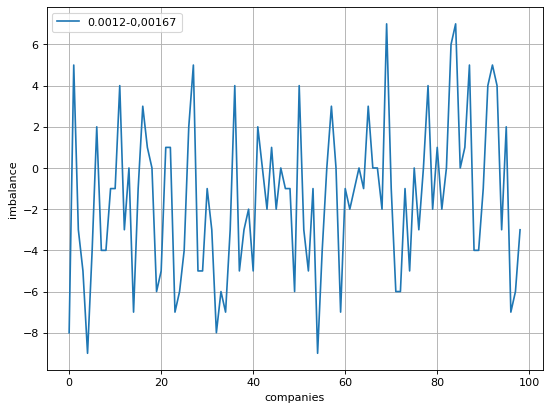

In [180]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='companies', ylabel='imbalance')
#plt.xticks(np.arange(10),  rotation='70')
plt.grid()
#for i in range(10):
plt.plot(np.sum(scores_all_compare_th_no_perm[:,:,0,3], axis=(1))-(np.sum(scores_all_compare_th_no_perm[:,:,1,3], axis=(1))))


#plt.legend(['positive', 'negative'])
plt.legend(["0.0012-0,00167",])


In [181]:
print((np.sum(scores_all_compare_th_no_perm[:,:,0,3], axis=(0,1))))
print((np.sum(scores_all_compare_th_no_perm[:,:,1,3], axis=(0,1))))


552.0
698.0


## as above, but with l2 normalization

In [273]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
thresholds_compare = (0.0012, 0.00167)
names_all=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
comps=np.arange(len(list_of_companies_number))
scores_all_compare_th_norm=np.zeros(shape=(len(comps), 10, 2, 4)) #company, i-th try, threshold, (acc,prec,recall,check_preds)

In [295]:
for c in range(len(comps)):
    print(c)
    X_hold=get_X(comps[c], interval, time_to_skip, time_back, names_all)
    for th in range(2):
        y_hold=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=thresholds_compare[th])
        for i in range(10):
            X,y=permutate_Xy(X_hold,y_hold)
            scores_all_compare_th_norm[c,i,th,0], scores_all_compare_th_norm[c,i,th,1],scores_all_compare_th_norm[c,i,th,2]=(
                logistic_regr(X, np.copy(y),split_percent, comp_id, use_pipe=MyNormalizer(axis=0,norm='l2'),
                              check_up_down=False, local_names=names_all))
            if  scores_all_compare_th_norm[c,i,th,2]>0.9 or  scores_all_compare_th_norm[c,i,th,2]<0.1:
                 scores_all_compare_th_norm[c,i,th,3]=True 
#np will parse above to one, true as if model is super bad, almost always returns either pos or neg class
clear_output()

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled


KeyboardInterrupt: 

In [278]:
for c in range(len(comps)):
    print(c)
    for th in range(2):
        for i in range(10):

            if  scores_all_compare_th_norm[c,i,th,2]>0.9 or  scores_all_compare_th_norm[c,i,th,2]<0.1:
                 scores_all_compare_th_norm[c,i,th,3]=True 
#np will parse above to one, true as if model is super bad, almost always returns either pos or neg class
clear_output()

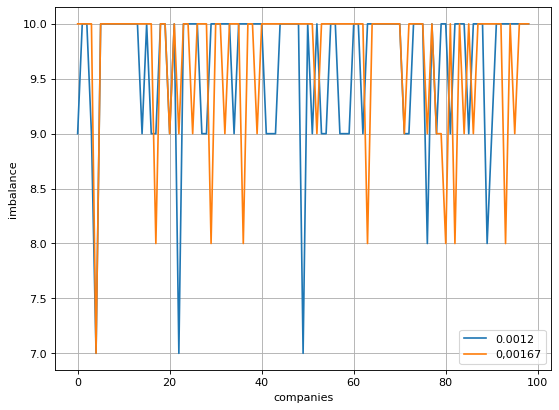

In [279]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='companies', ylabel='imbalance')
#plt.xticks(np.arange(10),  rotation='70')
plt.grid()
#for i in range(10):
plt.plot(np.sum(scores_all_compare_th_norm[:,:,0,3], axis=(1)))#-
plt.plot(np.sum(scores_all_compare_th_norm[:,:,1,3], axis=(1)))


#plt.legend(['positive', 'negative'])
plt.legend(["0.0012","0,00167",])

# time back

In [140]:
interval=1
time_to_skip=30
split_percent = 0.8
threshold = 0.0012
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
backs=[1,3,5,10,15,30]
comp_backs=np.zeros((len(list_of_companies_number), len(intervals),3))

In [296]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    for i in range(len(backs)):
        X_hold=get_X(comp_id, interval, time_to_skip, backs[i], names) 
        print('interval ', backs[i])
        print(X.shape)
        y=get_y(comp_id, interval, time_to_skip, backs[i], y_name='true_price', 
                check='swing_max', swing_interval=60, threshold=threshold)
        print(y.shape)
        X,y=permutate_Xy(X_hold,y)
        comp_backs[comp_id,i,0],comp_backs[comp_id,i,1],comp_backs[comp_id,i,2]=logistic_regr(X, y,split_percent, 
                                                                                           comp_id=comp_id, check_up_down=False, track_params=False, local_names=names)
clear_output()
print("calculations took: {} seconds".format(  time.time()-time_start))

0


NameError: name 'backs' is not defined

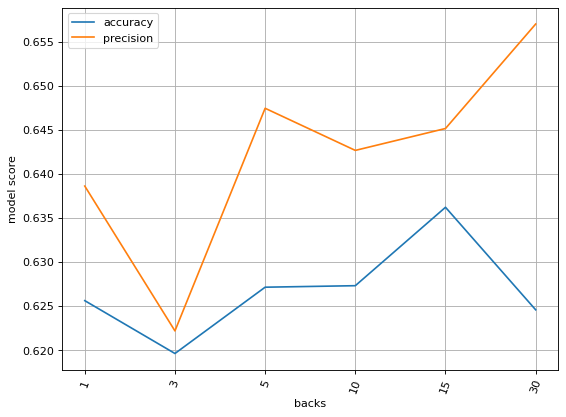

In [143]:
figure(figsize=(8, 6), dpi=80)
plt.axes(xlabel='backs', ylabel='model score')
plt.xticks(np.arange(len(backs)), backs, rotation='70')
plt.grid()
for i in range(2):
    plt.plot(np.sum(comp_backs, axis=0)[:,i]/9)
plt.legend(['accuracy', 'precision', 'recall'])

# scaled vs non scaled

In [58]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
threshold = 0.0012
names=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
comp_nonscaled=np.zeros((len(list_of_companies_number),4)) #acc, prec,rec,time
comp_scaled=np.zeros((len(list_of_companies_number),4))

In [297]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    print(X.shape)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    print(y.shape)
    X,y=permutate_Xy(X_hold,y)
    time_start=time.time()
    comp_scaled[comp_id,0],comp_scaled[comp_id,1],comp_scaled[comp_id,2]=logistic_regr(X, y,split_percent, 
                                                                                       comp_id=comp_id, use_scaling=True, check_up_down=False, track_params=False, local_names=names)
    comp_scaled[comp_id,3]=time.time()-time_start
    comp_nonscaled[comp_id,0],comp_nonscaled[comp_id,1],comp_nonscaled[comp_id,2]=logistic_regr(X, y,split_percent, 
                                                                                       comp_id=comp_id, use_scaling=False, check_up_down=False, track_params=False, local_names=names)
    comp_nonscaled[comp_id,3]=time.time()-time_start
    
clear_output()
print("calculations took: {} seconds".format(  time.time()-time_start))

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)


TypeError: logistic_regr() got an unexpected keyword argument 'use_scaling'

In [172]:
for i in range(comp_nonscaled.shape[0]):
    if math.isnan(comp_nonscaled[i,1]):
        print('nan')
        comp_nonscaled[i,1]=0

nan
nan


In [173]:
#df = pd.DataFrame(np.array)
df=pd.DataFrame(np.array([np.round(np.sum(comp_nonscaled, axis=0)/99, decimals=3), np.round(np.sum(comp_scaled, axis=0)/99, decimals=3)]))
df

,0,1,2,3
0,0.613,0.603,0.885,0.074
1,0.608,0.632,0.807,0.027


In [153]:
np.sum(comp_scaled, axis=0)

array([5.48315789, 5.75128643, 7.76722249, 0.26683545])

In [164]:
comp_scaled.shape

(99, 4)

# normalized vs non normalized

In [256]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
threshold = 0.0012
names_all=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
scalers=[None, preprocessing.StandardScaler(), preprocessing.MaxAbsScaler(), MyNormalizer(norm='l1',axis=0),MyNormalizer(norm='l2',axis=0)]
comp_scalers=np.zeros((len(list_of_companies_number),10, len(scalers),4)) #acc, prec,rec,time


In [225]:
#X_hold=get_X(0, interval, time_to_skip, time_back, names=names_all)
#preprocessing.StandardScaler().
print(np.sum(preprocessing.normalize(X_hold, norm='l1',axis=0), axis=0))
np.unique(preprocessing.normalize(X_hold, norm='l2',axis=0)-
          MyNormalizer(norm='l2', axis=0).fit(X_hold).transform(X_hold))

#preprocessing.normalize(X, norm='l1',axis=0)

[ 0.99999845 -0.05047447  1.0000008   1.0000001   0.9999985   0.9999994
  0.99999744 -1.0000308   0.9999971   0.99999785  0.9999971   0.99999785
  1.0000014   1.0000021   0.18399803]


array([0.], dtype=float32)

In [257]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    y_hold=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    for j in range(10): #average cmoputations
        X,y=permutate_Xy(X_hold,y_hold)
        for i in range(len(scalers)):
            print(scalers[i])
            time_start=time.time()
            comp_scalers[comp_id,j,i,0],comp_scalers[comp_id,j,i,1],comp_scalers[comp_id,j,i,2]=logistic_regr(X, y,split_percent, 
                                                                                               comp_id=comp_id, use_pipe=scalers[i], check_up_down=False, track_params=False, local_names=names_all)
            comp_scalers[comp_id,j,i,3]=time.time()-time_start

    clear_output(wait=True)


calculations took: 0.21847081184387207 seconds


In [272]:
df=pd.DataFrame(np.round(np.nansum(comp_scalers, axis=(0,1))/990, decimals=3))
df

,0,1,2,3
0,0.611,0.602,0.883,0.063
1,0.628,0.634,0.851,0.033
2,0.609,0.626,0.820,0.031
3,0.555,0.427,0.687,0.032
4,0.571,0.569,0.720,0.030


In [267]:
np.nansum(np.arange(1000).reshape(10,10,10), axis=(0,1))
    

array([49500, 49600, 49700, 49800, 49900, 50000, 50100, 50200, 50300,
       50400])

In [270]:
np.sum(np.arange(1000).reshape(10,10,10)[:,:,0])

49500

# permutated vs non permutated

In [128]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
threshold = 0.0016

In [65]:
samples_class=np.zeros((len(list_of_companies_number), 2))

In [129]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    #print(y.shape)
    dlugosc=y.size
    split=int(dlugosc*0.8)
    samples_class[comp_id,0]=np.sum(y[split:])
    samples_class[comp_id,1]=(dlugosc-split)-np.sum(y[split:])
    clear_output(wait=True)

98


In [130]:
counter=0
for pair, comp_id in zip(samples_class, np.arange(len(list_of_companies_number))):
    if  pair[0]/pair[1]>2/1 or pair[0]/pair[1]<1/2:
        counter+=1
        print("company {}, positive/negative ratio: {}".format(comp_id, pair[0]/pair[1]))
print(counter)

company 1, positive/negative ratio: 2.054662379421222
company 2, positive/negative ratio: 2.0351437699680512
company 3, positive/negative ratio: 2.015873015873016
company 5, positive/negative ratio: 2.5185185185185186
company 6, positive/negative ratio: 2.177257525083612
company 8, positive/negative ratio: 2.1147540983606556
company 14, positive/negative ratio: 2.3333333333333335
company 16, positive/negative ratio: 2.074433656957929
company 17, positive/negative ratio: 2.2203389830508473
company 23, positive/negative ratio: 2.7109375
company 26, positive/negative ratio: 2.5849056603773586
company 27, positive/negative ratio: 3.3577981651376145
company 32, positive/negative ratio: 2.177257525083612
company 34, positive/negative ratio: 2.2758620689655173
company 39, positive/negative ratio: 2.3333333333333335
company 44, positive/negative ratio: 2.177257525083612
company 45, positive/negative ratio: 0.46831530139103555
company 46, positive/negative ratio: 5.73758865248227
company 50, po

# models on ALL features

In [122]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
threshold = 0.0016
names_all=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
comps=np.arange(len(list_of_companies_number))
scores_all=np.zeros(shape=(len(comps), 10, 3))

In [298]:

for c in range(len(comps)):
    print(c)
    X=get_X(comps[c], interval, time_to_skip, time_back, names_all)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    X,y=permutate_Xy(X,y)
    for i in range(10):
        scores_all[c,i,0], scores_all[c,i,1],scores_all[c,i,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names_all))
clear_output()

0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,479 was zero!


TypeError: logistic_regr() got an unexpected keyword argument 'use_scaling'

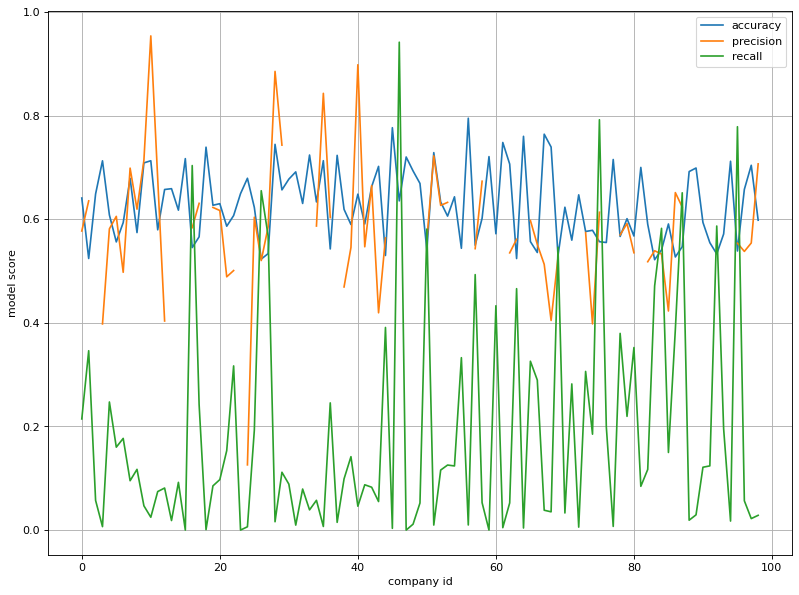

In [124]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model score')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
#plt.yticks(np.arange(11)*0.1)

plt.grid()
for i in range(3):
    plt.plot(np.sum(scores_all, axis=1)[:,i]/10)
#plt.plot(np.sum(scores_true, axis=1)[:,0]/10)
plt.legend(['accuracy', 'precision', 'recall'])
#true price only

# try different features for price swing

In [85]:
interval=1
time_to_skip=30
time_back=1
split_percent = 0.8
threshold=1e-3
names_all=[         
   # 'mid_price',
    'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
names_dict={}
for name in names_all:
    names_dict[name]=[]
param_dict_logreg={}
for n in names_all:
    param_dict_logreg[n]=[]
models={
    'log_reg': logistic_regr,
    'dec_tree': decision_tree,
    'xgb': xgb_model,
    
}

In [86]:
comps=np.arange(len(list_of_companies_number))
comps_X=[]
comps_y=[]
skipped_params=['none']+names_all
names_len=len(names_all)
scores=np.zeros(shape=(len(comps), names_len+1, 3))
pom_acc=0
pom_prec=0
pom_rec=0

In [299]:

for c in range(len(comps)):
   # X,y=get_X_y_classic(comps[c], interval, time_to_skip, time_back, names, y_name='true_price', check_change=True)
    X=get_X(comps[c], interval, time_to_skip, time_back, names_all)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    X,y=permutate_Xy(X,y)
    #for avg in range(10):
    pom_acc, pom_prec, pom_rec=logistic_regr(X, np.copy(y),split_percent, comps[c], True, 
                                             check_up_down=False, local_names=names_all, track_params=False, param_dict_logreg=param_dict_logreg)
    scores[c,0,0]+=pom_acc
    scores[c,0,1]+=pom_prec
    scores[c,0,2]+=pom_rec
    comps_X.append(X)
    comps_y.append(y)
for c in range(len(comps)):
    for i in range(1, names_len+1):
        name=names_all.pop(0)
       # for avg in range(10):
        pom_acc, pom_prec, pom_rec=logistic_regr(np.delete(comps_X[c], i-1, 1), 
                                               np.copy(comps_y[c]),split_percent, 
                                               comps[c], True, check_up_down=False, local_names=names_all, 
                                               track_params=False, param_dict_logreg=param_dict_logreg)
        scores[c,i,0]+=pom_acc
        scores[c,i,1]+=pom_prec
        scores[c,i,2]+=pom_rec
      #  scores[c,i,0],scores[c,i,1],scores[c,i,2]=logistic_regr(np.delete(comps_X[c], i-1, 1), 
       #                                        np.copy(comps_y[c]),split_percent, 
        #                                       comps[c], True, check_up_down=False, local_names=names)
        names_all.append(name)
      #  skipped_params.append(name)
        print('skipped ', name, '\n')
        #AFTER SCALING
clear_output()


38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,479 was zero!
Coefficient impact:
true_price   -0.649581599787235
order_inbalance   -0.8501905568363248
vwaps_buy   2.1008490984889607
vwaps_sell   1.2569471682102777
s2f_impact_buy   0.9848246454446956
s2f_impact_sell   0.5568657080869561
trading_volumes   -0.504385558366707
price_volatilities   0.5424538599551936
vwaps_order_sizes_buy   -0.21467498108377003
vwaps_order_sizes_sell   -0.259626873829718
s2f_order_sizes_buy   -0.21467498108377003
s2f_order_sizes_sell   -0.259626873829718
next_trade_time   0.016132977602695737
next_trade_size   1.6964483223209426
next_trade_price   0.9406535261400757
[[125  93]
 [297 435]]


NameError: name 'scores' is not defined

In [197]:
for k,v in param_dict_logreg.items():
    print(k, np.sum(np.abs(v))/len(v))

true_price nan
order_inbalance nan
vwaps_buy nan
vwaps_sell nan
s2f_impact_buy nan
s2f_impact_sell nan
trading_volumes nan
price_volatilities nan
vwaps_order_sizes_buy nan
vwaps_order_sizes_sell nan
s2f_order_sizes_buy nan
s2f_order_sizes_sell nan
next_trade_time nan
next_trade_size nan
next_trade_price nan


<ipython-input-197-dee38e1b4768>:2: RuntimeWarning: invalid value encountered in double_scalars
  print(k, np.sum(np.abs(v))/len(v))


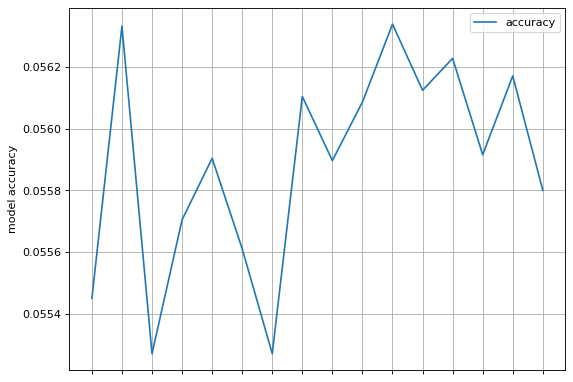

In [57]:
figure(figsize=(8, 6), dpi=80)

plt.axes(ylabel='model accuracy')
plt.xticks(np.arange(len(skipped_params)), [])#, skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
plt.plot(np.sum(scores, axis=0)[:,0]/(len(comps)*10))
#plt.plot(np.sum(scores, axis=0)[:,1]/(len(comps)*10))
#plt.plot(np.sum(scores, axis=0)[:,2]/(len(comps)*10))
plt.legend(['accuracy', 'precision', 'recall'])
#plt.legend(comps)
 ### LOG REg

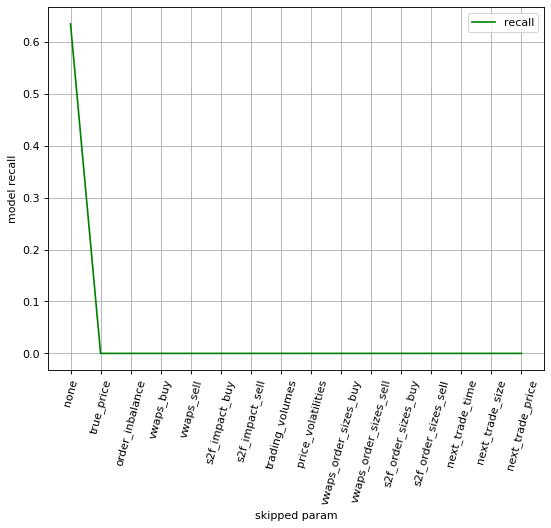

In [181]:
figure(figsize=(8, 6), dpi=80)

plt.axes(xlabel='skipped param', ylabel='model recall')
plt.xticks(np.arange(len(skipped_params)), skipped_params, rotation='75')
plt.grid()
#for c in range(len(comps)):
 #   plt.plot( scores[c])
#plt.plot(np.sum(scores, axis=0)[:,0]/len(comps))
#plt.plot(np.sum(scores, axis=0)[:,1]/len(comps))
plt.plot(np.sum(scores, axis=0)[:,2]/(len(comps)*10), 'g')
plt.legend(['recall'])

# models on not all features

In [96]:
interval=1
time_back=5
time_to_skip=30
split_percent = 0.8
threshold = 0.0016
names=[          
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
      ]
comp_scores=np.zeros((len(list_of_companies_number),10, 3)) 

In [300]:
for comp_id in range(len(list_of_companies_number)):
    print(comp_id)
    X_hold=get_X(comp_id, interval, time_to_skip, time_back, names) 
    print(X.shape)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    print(y.shape)
    
    for i in range(10):
        X,y=permutate_Xy(X_hold,y)
        comp_scores[comp_id,i,0], comp_scores[comp_id,i,1],comp_scores[comp_id,i,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names))

    #comp_scores[comp_id,0],comp_scaled[comp_id,1],comp_scaled[comp_id,2]=logistic_regr(X, y,split_percent, 
     #                                                                                  comp_id=comp_id, use_scaling=True, check_up_down=False, track_params=False, local_names=names)
clear_output()


0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
(4750, 15)
true price at index 9,479 was zero!
(4750,)


TypeError: logistic_regr() got an unexpected keyword argument 'use_scaling'

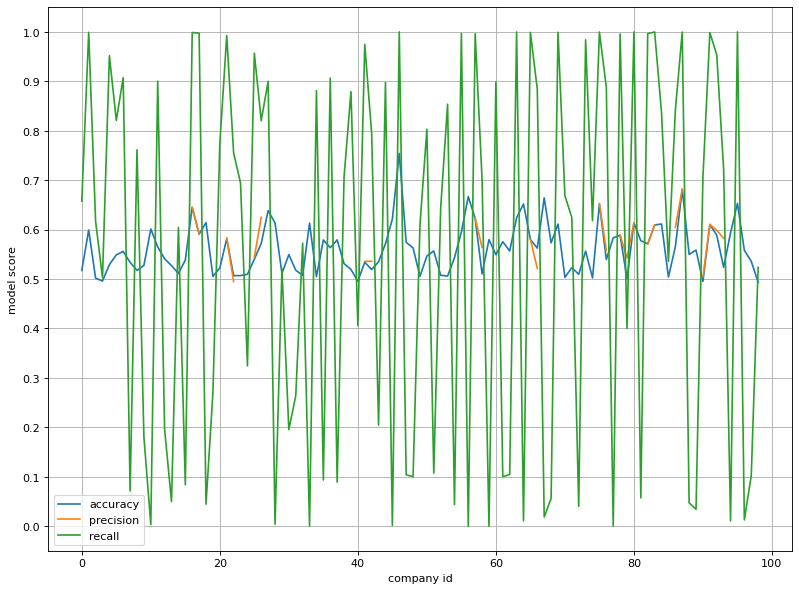

In [98]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model score')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
plt.yticks(np.arange(11)*0.1)

plt.grid()
for i in range(3):
    plt.plot(np.sum(comp_scores, axis=1)[:,i]/10)
#plt.plot(np.sum(scores_true, axis=1)[:,0]/10)
plt.legend(['accuracy', 'precision', 'recall'])
#true price only

In [99]:
arr=np.sum(comp_scores, axis=1)[:,2]
arr[arr>9.9].size

18

In [ ]:
# SCALE VS not scale

In [ ]:
comp_id=9
interval=5
time_to_skip=30
time_back=12
swing_interval=60
split_percent = 0.8
threshold=1e-3
names=[         
   # 'mid_price',
   # 'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]

In [ ]:
X=get_X(comp_id, interval, time_to_skip, time_back, names)
y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)

In [ ]:
log_scale=[]
log=[]
tree_scale=[]
tree=[]
for i in range(100):
    tree_scale.append(decision_tree(X, np.copy(y),split_percent, comp_id , use_scaling=True, check_up_down=False, local_names=names))
    log_scale.append(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names))
    tree.append(decision_tree(X, np.copy(y),split_percent, comp_id, use_scaling=False, check_up_down=False, local_names=names))
    log.append(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=False, check_up_down=False, local_names=names))

In [ ]:
print("log_scale: ", np.sum(log_scale)/100)
print("log: ", np.sum(log)/100)
print("tree_scale: ", np.sum(tree_scale)/100)
print("tree: ", np.sum(tree)/100)

In [ ]:
comps=np.arange(len(list_of_companies_number))
scores=np.zeros(shape=(len(comps), 4))
for c in range(len(comps)):
    print(c)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    scores[c,0]=(decision_tree(X, np.copy(y),split_percent, comp_id , use_scaling=True, check_up_down=False, local_names=names))
    scores[c,1]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names))
    scores[c,2]=(decision_tree(X, np.copy(y),split_percent, comp_id, use_scaling=False, check_up_down=False, local_names=names))
    scores[c,3]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=False, check_up_down=False, local_names=names))

In [ ]:
figure(figsize=(24, 18), dpi=80)

plt.axes(xlabel='comp id', ylabel='model score')
plt.xticks(np.arange(len(comps)), comps, rotation='90')
plt.grid()
for c in range(4):
    plt.plot(scores[:,c])
#plt.plot(np.sum(scores, axis=0)/len(comps))
plt.legend(['tree_scaled', 'log_scaled', 'tree','log'])

In [ ]:
print(['tree_scaled', 'log_scaled', 'tree','log'])
print(np.sum(scores, axis=0)) 

# models only on true price

In [193]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=1
threshold=1e-3
#comp_ths=np.zeros((len(list_of_companies_number),1))

In [122]:
X=get_X(20, interval, time_to_skip, time_back, ['true_price'])
y=get_y(20, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
X,y=permutate_Xy(X,y)
logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=['true_price'])

Coefficient impact:
true_price   -1.8594986026565887
[[522 436]
 [  0   0]]


(0.5448851774530271, 0.5448851774530271, 1.0)

In [79]:
comps=np.arange(len(list_of_companies_number))
scores_true=np.zeros(shape=(len(comps), 10, 3))
for c in range(len(comps)):
    print(c)
 #   X=get_X(comps[c], interval, time_to_skip, time_back, ['true_price'])
  #  y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    for i in range(10):
        X,y=permutate_Xy(np.atleast_2d(X_allcomps[c,:,0]).T,y_allcomps[c]) #IMNPORTANT that 2d only for one feature models
        scores_true[c,i,0], scores_true[c,i,1],scores_true[c,i,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_pipe=preprocessing.MaxAbsScaler(), check_up_down=False, local_names=['true_price']))
clear_output()


In [78]:
np.atleast_2d(X_allcomps[0,:,0]).T.shape

(4750, 1)

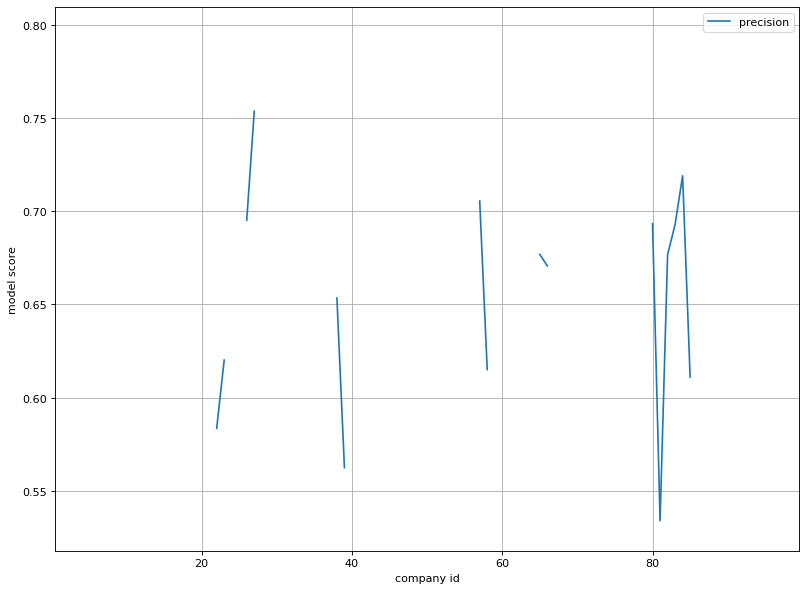

In [82]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model score')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
plt.grid()
#for i in range(3):
 #   plt.plot(np.sum(scores_true, axis=1)[:,i]/10)
plt.plot(np.sum(scores_true, axis=1)[:,1]/10)
plt.legend(['precision', 'precision', 'recall'])
#true price only

In [199]:
np.sum(np.sum(scores_true, axis=1)[:,0])/990

0.5410145294278905

In [198]:
print('avg model acc')
np.sum(scores_true)/(99*10)

avg model acc


nan

In [200]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=1
threshold=1e-3
names=[         
   # 'mid_price',
   # 'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
scores_all=np.zeros(shape=(len(comps), 10, 3))


In [302]:
for c in range(len(comps)):
    print(c)
    X=get_X(comps[c], interval, time_to_skip, time_back, names)
    y=get_y(comps[c], interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    X,y=permutate_Xy(X,y)
    for i in range(10):
        scores_all[c,i,0], scores_all[c,i,1],scores_all[c,i,2]=(logistic_regr(X, np.copy(y),split_percent, comp_id, use_scaling=True, check_up_down=False, local_names=names))
clear_output()


0
38.166666666666664% of intervals were SELL empty
35.791666666666664% of intervals were BUY empty
0.0625% of intervals were set not filled
true price at index 9,479 was zero!


TypeError: logistic_regr() got an unexpected keyword argument 'use_scaling'

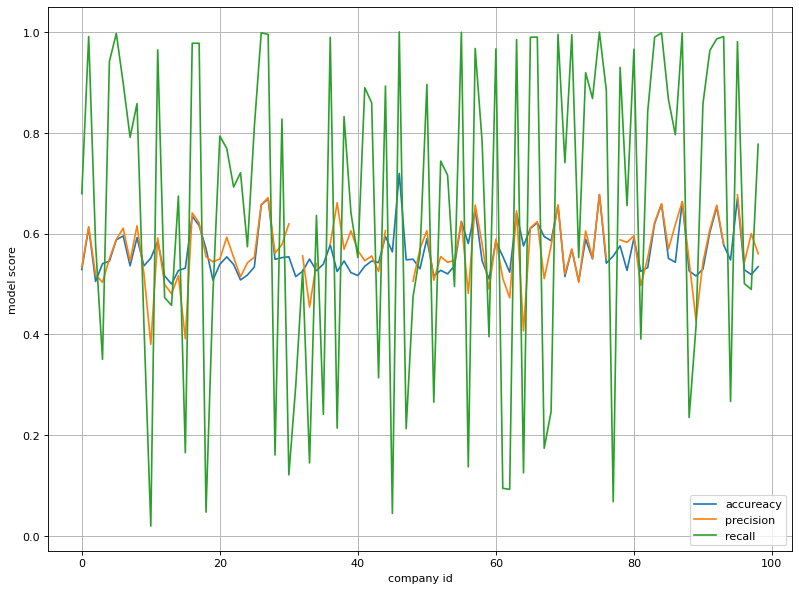

In [205]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model score')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
plt.grid()
for i in range(3):
    plt.plot(np.sum(scores_all, axis=1)[:,i]/10)
#plt.plot(np.sum(scores_all, axis=1)[:,0]/10)
plt.legend(['accureacy', 'precision', 'recall'])
#true price only

In [112]:
print('avg model acc')
np.sum(np.sum(scores_all, axis=1)[:,0])/(99*10)

avg model acc


0.5621939646991838

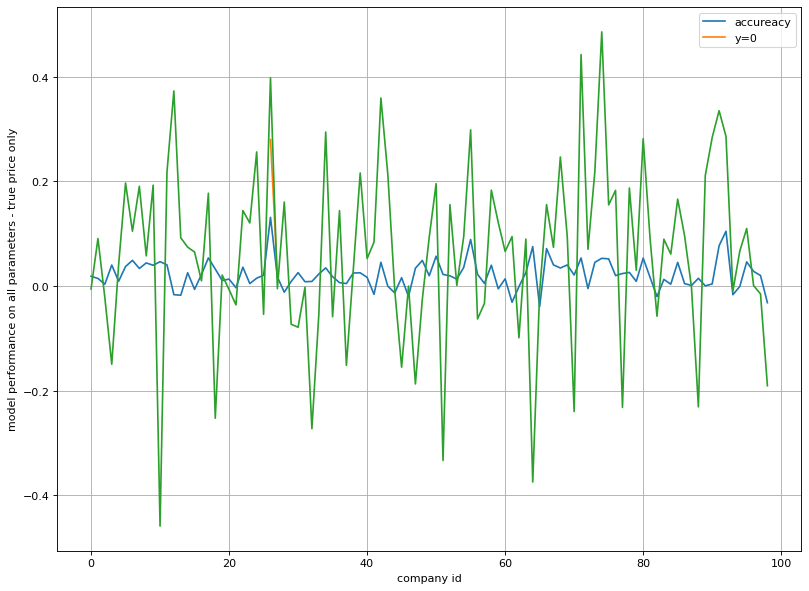

In [204]:
figure(figsize=(12, 9), dpi=80)

plt.axes(xlabel='company id', ylabel='model performance on all parameters - true price only')
#plt.xticks(np.arange(len(comps)), comps, rotation='75')
plt.grid()
for i in range(3):
    plt.plot(np.sum(scores_all, axis=1)[:,i]/10 - np.sum(scores_true, axis=1)[:,i]/10)
#plt.plot(np.sum(scores_all, axis=1)[:,0]/10)
plt.legend(['accureacy', 'y=0',])
#true price only

In [76]:
print('avg model acc')
np.sum(scores_all-scores)/(99*10)

avg model acc


0.0008645958541574415

# compare models

In [ ]:
time_back=1
time_to_skip=30
split_percent = 0.8
interval=5
names=[   
  #  'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    'next_trade_price',
   # 'true_price'
]
threshold=1e-3
comp_ths=np.zeros((len(list_of_companies_number),3))

In [ ]:
time_start=time.time()
for comp_id in range(len(list_of_companies_number)//10):
    print(comp_id)
    X=get_X(comp_id, interval, time_to_skip, time_back, names) 
    print(X.shape)
    y=get_y(comp_id, interval, time_to_skip, time_back, y_name='true_price', 
            check='swing_max', swing_interval=60, threshold=threshold)
    print(y.shape)
    comp_ths[comp_id,0]=logistic_regr(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
    comp_ths[comp_id,1]=decision_tree(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
    comp_ths[comp_id,2],_,_=xgb_model(X, y,split_percent, comp_id, check_up_down=False, track_params=False, local_names=names)
print("calculations took: {} seconds".format(  time.time()-time_start))

In [ ]:
comp_summed=np.sum(comp_ths, axis=0)/9
print("logreg ", comp_summed[0], ", dec tree ", comp_summed[1], ", xgb ", comp_summed[2])

In [ ]:
import tensorflow as tf


# PYTORCH

In [ ]:
from torch import nn
from IPython.display import clear_output


In [ ]:
comp_id=9
interval=5
time_to_skip=30
time_back=12
swing_interval=60
split_percent = 0.8
threshold=1e-3
names=[         
   # 'mid_price',
   # 'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
X=get_X(0, interval, time_to_skip, time_back, names)
y=get_y(0, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)

In [ ]:
X=get_X(0, interval, time_to_skip, time_back, names)
y=get_y(0, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)

In [ ]:
X=np.arange(100).reshape(10,10)
X=torch.tensor( X.reshape((X.shape[0], X.shape[1], 1)))
X

In [104]:



rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5,3,10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

In [108]:
input

tensor([[[-1.0628,  0.5585, -1.0645, -0.0440,  0.5010,  0.6481, -0.7833,
           0.4331,  0.0158, -1.1018],
         [-0.6953, -0.3864,  1.3036,  1.7006,  0.3969, -3.3250,  0.7332,
          -0.1670,  0.4305,  0.8640],
         [-0.6886,  0.0246,  0.5902,  0.7218, -1.0999, -0.5088,  1.5050,
           0.1934, -0.0324, -0.6890]],

        [[-0.6266, -0.7843,  0.5038,  0.0861, -1.0237, -0.0098,  2.1013,
           0.2527,  1.4739,  0.1286],
         [-0.4438, -0.2992,  0.1483, -0.1707,  1.3360, -1.8862, -2.0256,
          -1.8637, -0.3229,  0.4310],
         [-2.5040,  0.5185,  0.5304,  0.1862, -0.6130, -1.8489, -2.6557,
           0.8494,  1.0029, -2.0036]],

        [[ 0.1833,  0.8922, -2.6648, -0.4558,  0.3590,  1.4857, -0.2737,
          -1.1159, -0.1095,  0.0879],
         [-0.8676,  0.7471, -0.0089,  0.4768, -0.1263,  0.5140, -1.5660,
          -1.6823, -0.5825,  0.6293],
         [-1.2264, -0.7090,  0.8310, -0.3566,  1.2700,  0.6331,  0.1159,
           1.6533, -2.1670, -0.0967

In [ ]:
X

In [ ]:
from sklearn.metrics import confusion_matrix
# false positive - truth was false, prediction was true
# false negative - truth was true, prediction was false

In [ ]:
def my_confusion_matrix(y_true, y_pred, labels): # for binary clasification
    if len(labels)!=2:
        raise ValueError("wrong labels fro binary clasiffication")
    if len(y_true)!=len(y_pred):
        raise ValueError("shapes for y differ")
    truth=labels[0]
    tp=0 
    fp=0 #truth was false, prediction was true
    fn=0 #truth was true, prediction was false
    tn=0
    for i in range(len(y_true)):
        if y_true[i]==truth: # true positive or false negative
            if y_true[i]==y_pred[i]:
                tp+=1
            else:
                fn+=1
        else: # true negative or false positive
            if y_true[i]==y_pred[i]:
                tn+=1
            else:
                fp+=1
    return np.array([[tp, fp],[fn, tn]]) 

In [ ]:
test=[0,0,1,1]
pred=[0,1,0,0]
confusion_matrix(test, pred, labels=[1,0]) # 1-true, 0-false

In [ ]:
my_confusion_matrix(test, pred, labels=[1,0]) # 1-true, 0-false

In [ ]:
len(torch.zeros(10))

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)

    def loss(self, Out, Targets):
        return nn.functional.cross_entropy(Out, Targets)

In [ ]:
def compute_error_rate(model, X, y, device="cpu"):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)


    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in zip(X,y):
            x = x.to(device).reshape(1,len(x)) # reshape sample from (num_of_features) to (1, num_of_features)
            y = y.to(device).reshape(1)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples
def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    train_loss = np.array(history["train_losses"])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label="batch train loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    train_errs = np.array(history["train_errs"])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label="batch train error rate")
    val_errs = np.array(history["val_errs"])
    plt.plot(val_errs[:, 0], val_errs[:, 1], label="validation error rate", color="r")
    plt.ylim(0, 0.20)
    plt.legend()

In [ ]:
def SGD(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    alpha=1e-4,
    epsilon=0.1,
    decay=0.01,
    beta=0.95,
    batch_size=100,
    num_epochs=3,
    max_num_epochs=np.nan,
    patience_expansion=1.5,
    log_every=100,
    polyak=False,
    device="cpu",
):

    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    velocities = [torch.zeros_like(m) for m in model.parameters()]
   # if polyak:
    polyaks= [torch.zeros_like(m) for m in model.parameters()]
    #print(velocities)
    #
    alpha0=alpha
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {"train_losses": [], "train_errs": [], "val_errs": []}
    print("Training the model!")
    print("Interrupt at any time to evaluate the best validation model so far.")
    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break
            alpha=alpha0*np.power(beta,epoch)
            
            for counter in range(X_train.size(0)//batch_size):#zip(X_train,y_train):
                x=X_train[counter*batch_size:(counter+1)*batch_size]
                x = x.to(device)#.reshape(1,len(x)) # reshape sample from (num_of_features) to (1, num_of_features)
             #   print(x.shape)
                y=y_train[counter*batch_size:(counter+1)*batch_size]
                y = y.to(device)#.reshape(1)
              #  print(y)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history["train_losses"].append(loss.item())
                history["train_errs"].append(batch_err_rate)

                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v, pol in zip(model.named_parameters(), velocities, polyaks):
                        if "weight" in name:
                            p.grad +=  decay * 2*p   #### pochodna sumy kwadratów więc mamy 2p

                        v[:] = epsilon*v - alpha * p.grad
                        p[:] =p + v
                        pol[:]=0.99*pol + (1-0.99)*p
                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print(
                        "Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}".format(
                            iter_,
                            loss.item(),
                            batch_err_rate * 100.0,
                            num_iter / (time.time() - tstart),
                        )
                    )
                    tstart = time.time()

            val_err_rate = compute_error_rate(model, X_valid, y_valid, device)
            history["val_errs"].append((iter_, val_err_rate))

            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs".format(
                epoch, val_err_rate * 100.0, num_epochs
            )
            print("{0}\n{1}\n{0}".format("-" * len(m), m))

            if(polyak):
                with torch.no_grad():
                    for (name, p), pol in zip(model.named_parameters(), polyaks):
                        p[:]=pol
                        pol[:]=torch.zeros_like(pol)
                  

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" % (best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

In [ ]:
for x,y in zip(X,y):
    print(x,y)

In [ ]:
comp_id=3
interval=1
time_to_skip=30
time_back=5
swing_interval=60
split_percent = 0.6
valid_percent=split_percent+0.2
threshold=1e-3
names=[         
   # 'mid_price',
   # 'true_price', 
    'order_inbalance', 
    'vwaps_buy', 
    'vwaps_sell', 
    's2f_impact_buy', 
    's2f_impact_sell', 
    'trading_volumes', 
    'price_volatilities',
    'vwaps_order_sizes_buy', 
    'vwaps_order_sizes_sell',
    's2f_order_sizes_buy', 
    's2f_order_sizes_sell',
    'next_trade_time',
    'next_trade_size',
    'next_trade_price',
    #'price change'
      ]
no_comps=len(list_of_companies_number)
s=get_X(0, interval, time_to_skip, time_back, names).shape
X=np.zeros(shape=(no_comps, s[0], s[1]))
y=np.zeros(shape=(no_comps, s[0]))
Xy=np.empty(shape=(X.shape[1], X.shape[2]+1))
for i in range(no_comps):
    X_hold=get_X(i, interval, time_to_skip, time_back, names)
    transformer = preprocessing.MaxAbsScaler().fit(X_hold)

    Xy[:,:14]=transformer.transform(X_hold)
    Xy[:,14]=get_y(i, interval, time_to_skip, time_back, y_name='true_price', check='swing_max', threshold=threshold)
    Xy=np.random.permutation(Xy)
    X[i]=Xy[:,:14]
    y[i]=Xy[:,14]
split=int(X.shape[1]*split_percent)
valid=int(X.shape[1]*valid_percent)

## save X and y to csv file, upload the files to colab and train much much faster on cloud gpu

In [ ]:
'X_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, swing_interval)

In [ ]:
import pandas as pd
x_df = pd.DataFrame(torch.flatten(X,start_dim=0, end_dim=1).numpy())
x_df.to_csv('X_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, swing_interval))
y_df = pd.DataFrame(torch.flatten(y,start_dim=0, end_dim=1).numpy())
y_df.to_csv('y_{}_{}_{}_{}.csv'.format(interval,time_to_skip, time_back, swing_interval))

In [ ]:
X=torch.tensor(X, dtype=torch.float32)
y=torch.tensor(y, dtype=torch.long)

In [ ]:
transformer = preprocessing.MaxAbsScaler().fit(X)
transformer.transform(X)
transformer.n_features_in_

In [ ]:
MLP=Model(nn.Linear(len(names), 512), nn.Sigmoid(), 
          nn.Linear(512, 1024), nn.Sigmoid(), nn.Dropout(p=0.2),
          nn.Linear(1024,1024), nn.Sigmoid(),
          nn.Linear(1024,64), nn.Sigmoid(),
          nn.Linear(64,2)
         )
with torch.no_grad():
    # Initialize parameters
    for name, p in MLP.named_parameters():
        if "weight" in name:
            p.normal_(1e-8, 0.2)
        elif "bias" in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)
t_start = time.time()

#X=torch.tensor(X, dtype=torch.float32)
#y=torch.tensor(y, dtype=torch.long)

SGD(MLP, torch.flatten(X[:,:split],start_dim=0, end_dim=1), torch.flatten(y[:,:split],start_dim=0, end_dim=1), 
   torch.flatten( X[:,split:valid],start_dim=0, end_dim=1), torch.flatten(y[:,split:valid],start_dim=0, end_dim=1),
    alpha=4e-1, epsilon=0.6, decay=0.0001,beta=0.98,batch_size=1000, max_num_epochs=30)



test_err_rate = compute_error_rate(MLP, torch.flatten(X[:,valid:],start_dim=0, end_dim=1), torch.flatten(y[:,valid:],start_dim=0, end_dim=1))
m = (
    f"Test error rate: {test_err_rate * 100.0:.3f}%, "
    f"training took {time.time() - t_start:.0f}s."
)
print("{0}\n{1}\n{0}".format("-" * len(m), m))

In [ ]:
X.shape

In [ ]:
y_d=torch.tensor([0,0,0,0,0,1,1,1,1,1])
predictions = torch.tensor([0,0,0,0,1,1,1,1,1,1])
num_errs = (predictions != y_d.data).sum().item()
num_examples = y_d.size(0)
num_errs / num_examples

In [ ]:
y_d=y[0].reshape(1)
MLP.eval()
_, predictions=MLP.forward(torch.flatten( X[:,:split],start_dim=0, end_dim=1)[0:10].shape).data.max(dim=1)
num_errs = (predictions != y_d.data).sum().item()
num_examples = y_d.size(0)
num_errs / num_examples

In [ ]:
torch.flatten( X[:,split:valid],start_dim=0, end_dim=1)

In [ ]:
y.shape